<a href="https://www.kaggle.com/code/jacopodignazi/reddgend?scriptVersionId=100728019" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Progetto Kaggle sui testi di Reddit** # 
Jacopo D'Ignazi

Numero di matricola: 937038


# **Sommario**

Il programma si divide sostanzialmente in tre parti: 
la prima svolge per i due diversi tipi di informazioni (testi dei post e subreddit) funzioni di estrazione delle features e visualizzazione, provandone varie possibilità e -a posteriori- valutarne le conseguenze. 
La seconda si occupa successivamente di usare le features estratte per costruire diversi modelli, testarne diverse architetture ed indagare lo spazio degli iperparametri con cross validation e validazione su un sottinsieme dei dati lasciati a parte.
In ultimo i modelli sceltelti verranno usati in ensamble, con la possibilità di usare diverse strategie e parametrizzare anche il metodo di ensamble.

E' mia premura voler sottolineare che l'intero programma è stato scritto cos com'è per dare il massimo delle possibilità di testare varie scelte, per poi farne considerazioni basandomi innanzitutto sulla visualizzazione ed infine sulla curve di learning osservate.

I modelli scelti sono stati:
- 2 regressioni logistiche basate su 2 diversi modi di dare una score ai subreddit, e dunque agli utenti in base a quanti post avevano scritto in ogni subreddit
- 1 regressione logistica sulle componenti estratte con PCA della feature "numero di post in determinati subreddit"
- 1 rete neurale con hidden layer, che prende in input i testi degli utenti elaborati con word embedding
- 1 regressione logistica sulle componenti LSA dei testi degli utenti

Cercherò di spiegare man mano più nel dettaglio come ho poi parametrizzato ed ottimizzato questi modelli ed il loro ensamble

NB Per ragioni di come ho organizzato il flusso di dati nel programma, alcune operazioni -in particolare visualizzazione- sono fatte in momenti poco intuitivi e a volte lontani dal calcolo delle feature che coinvolgono. Mi scuso se dovesse risultare poco scorrevole da leggere ma avendoci lavorato "in blocchi", doverlo poi mettere insieme in un unico foglio mi ha portato ad adottare soluzioni un po' scomode in implementazion


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

%pylab inline


def perc_compl(num, den, last_step, text=None,step=0.1):
    perc=((num+1)/den)*100
    if int(perc)==100 or perc>=(last_step+step):
        last_step+=step
        to_write=''
        if text!= None:
            to_write+=text
        to_write+=" [{:-<20.20}]".format("="*int(perc/5)+">")
        to_write+="  {:<2.2f} %  completed".format(perc)
        print('\r'+to_write,end='')
        if int(perc)==100: print(end='\n\n')
    return last_step
#needs to be called as stepping=perc_compl(i,up_to,last_step=stepping)

def dictoarr(dictionary):
    return np.array(list((dictionary.values())))

/kaggle/input/datamining2021/sample.csv
/kaggle/input/datamining2021/train_target.csv
/kaggle/input/datamining2021/train_data.csv
/kaggle/input/datamining2021/test_data.csv
Populating the interactive namespace from numpy and matplotlib




**Settings iniziali del programma**

In queste prime celle di codice ci sono le definizioni dei principali parametri usati nei vari modelli. Innanzitutto opzioni di caricamento/salvataggio dei dati ottenuti in varie iterazioni e coordinazione dei nomi dei file; subito dopo le impostazioni per il preprocessing del testo sia per il word embedding che per LSA, i parametri per il modello di embedding e le impostazioni del modello di pca.

Tra queste opzioni, in particolare: ho scelto di calcolare la PCA, la LSA ed il word embedding con i dati di subreddit/di testo di **tutto** il dataset. Nessuna di queste richiedeva le informazioni target per cui non c'è stato "leakeage" di informazioni nel training set (questo mi garantiva che la differenza tra curve training e validation fosse un proxy attendibile per stimare l'errore out of sample), ma mi rendo conto che in una task di machine learning non sia scontato avere già le features di cui trovare le label. 

Provando sia l'opzione di calibrare queste feature extraction sia su tutto il dataset che solo sul training dataset, ho osservato un miglioramento di qualche punto percentuale sulla roc-auc finale, o tuttalpiù variazioni non troppo significative. Ho quindi scelto di tenere le componenti ricavate da tutto il dataset per il semplice fatto che risultava sistematicamente leggermente più funzionale, ed in questo caso la task lo permetteva


In [2]:
LOAD_INPUT_PREFIX="../input/datamining2021/" #kaggle version
SAVE_INPUT_PREFIX="./"
# LOAD_INPUT_PREFIX=""
# SAVE_INPUT_PREFIX=""  #desktop version 

train_data = pd.read_csv(LOAD_INPUT_PREFIX+"train_data.csv", encoding="utf8")
train_target= pd.read_csv(LOAD_INPUT_PREFIX+"train_target.csv", encoding="utf8")
test_data=pd.read_csv(LOAD_INPUT_PREFIX+"test_data.csv", encoding="utf8")
test_target=pd.read_csv(LOAD_INPUT_PREFIX+"sample.csv", encoding="utf8")

all_data=pd.concat([train_data,test_data])

# print(len(all_data), 'total posts, written by', len(all_target),'users')



In [3]:
############################################################## general run settings

# TRY_RUN=False

LOAD_NOTHING=True
LOAD_EVERYTHING=False
# nb SL nothing dominates over SL everything
SAVE_NOTHING=False
SAVE_EVERYTHING=True
# nb per kaggle devo impostare LN True e SE True

def L_BOOL(TorF):
    return (TorF or LOAD_EVERYTHING) and not LOAD_NOTHING

def S_BOOL(TorF):
    return (TorF or SAVE_EVERYTHING) and not SAVE_NOTHING

submission_run_count=0
# ------------------------------------ post count  settings

TO_LOAD_SPC=L_BOOL(True)
TO_SAVE_SPC=S_BOOL(False)

TO_LOAD_UPC=L_BOOL(True)
TO_SAVE_UPC=S_BOOL(False)

TO_LOAD_valid_UPC=L_BOOL(False)
TO_SAVE_valid_UPC=S_BOOL(True)

TO_LOAD_test_UPC=L_BOOL(False)
TO_SAVE_test_UPC=S_BOOL(False)

# SAVE_ALL=(False or SAVE_EVERYTHING) and not SAVE_NOTHING

PC_SL_prefix=SAVE_INPUT_PREFIX+"V4_"

SORTING_SUBREDDIT=True

# ------------------------------------ words embedding SL settings

LOAD_PRETRAINED_EMBEDDING=L_BOOL(True)
SAVE_EMBEDDING=S_BOOL(False)

WEMB_SL_prefix="alldata_"

TRIAL_EMBEDDING_PARAMETERS=False

# ------------------------------------ users embedding SL settings

U2V_MODE='word_avg' #sum, word avg or post avg
P2V_VECT='vers'  #vect or vers

LOAD_PRETRAINED_U2V={'train':L_BOOL(True),
                     'valid':L_BOOL(False),
                     'test':L_BOOL(False) 
                    }
SAVE_U2V={'train':S_BOOL(False),
          'valid':S_BOOL(False),
          'test':S_BOOL(False) 
         }
U2V_SL_prefix={'train':"TRAIN_U2V_"+U2V_MODE+"_"+P2V_VECT+"_;_"+WEMB_SL_prefix,
               'valid':"VALID_U2V_"+U2V_MODE+"_"+P2V_VECT+"_;_"+WEMB_SL_prefix,
               'test':"TEST_U2V_"+U2V_MODE+"_"+P2V_VECT+"_;_"+WEMB_SL_prefix,
            #    'all':"ALL_U2V_"+WEMB_SL_prefix
              }
# ------------------------------------ users embedding SL settings

LOAD_ULSA={
    'train':L_BOOL(False),
    'valid':L_BOOL(False),
    'test': L_BOOL(False),
}

SAVE_ULSA={
    'train':S_BOOL(False),
    'valid':S_BOOL(False),
    'test': S_BOOL(False),
}


In [4]:
# ------------------------- Preprocess Settings for word embedding

LOWER=True
LEMMATIZE=False
REMOVE_PUNCT=True
REMOVE_STOP=True

PRESERVE_MORPHOLOGY=True
SUBSTITUTE_REMOVED=True
TEXT_TO_SUBSTITUTE="-"

REMOVE_MANUALLY=True
mr_set=['\n']
def not_to_keep(word):
    if word in mr_set:
        return True
    if len(word)==1:
        return True

prep_sett={
    'LW':LOWER,
    'LM':LEMMATIZE,
    'RP':REMOVE_PUNCT,
    'RS':REMOVE_STOP,
    'PM':PRESERVE_MORPHOLOGY,
    'RM':REMOVE_MANUALLY,
         }

def preprocess(line):
#              ^^^^^^ preprocess a line of plain text 
#             WARNING NEEDS to be a string
    processed_line=[]
    processed_words=0
    if type(line) is list:
        line=" ".join(line)
        print("WARNING: preprocessed a list line")
    if type(line) is not str:
        line=str(line)
        print("preprocessed a non-string line")
    if LOWER:
        line=line.lower()
    for token in tokenizer(line):
#         print(token)
        word_to_keep=True
        if LEMMATIZE:
            processed_word=token.lemma_
        else:
            processed_word=token.text
        if REMOVE_PUNCT and token.is_punct:
            word_to_keep=False
        if REMOVE_STOP and token.is_stop:
            word_to_keep=False
        if REMOVE_MANUALLY and not_to_keep(token.text):
            word_to_keep=False  
        if not word_to_keep:
            if PRESERVE_MORPHOLOGY:
                if SUBSTITUTE_REMOVED:
                    processed_word=TEXT_TO_SUBSTITUTE
                processed_line.append(processed_word) 
                processed_words+=1
                continue
            else:
                continue
        processed_line.append(processed_word)
        processed_words+=1
        
    return processed_line, processed_words
        
# ------------------------- Embedding model Settings

w2v_params={
    "min_count": 5,
    "size": 100,
    "window": 20,
    "epochs": 5
           }


In [5]:
# ------------------------- Preprocess Settings for word counting

UWC_LOWER=True
UWC_LEMMATIZE=True
UWC_REMOVE_PUNCT=True
UWC_REMOVE_STOP=True

UWC_PRESERVE_MORPHOLOGY=False
UWC_SUBSTITUTE_REMOVED=True
UWC_TEXT_TO_SUBSTITUTE=" "

UWC_REMOVE_MANUALLY=True
UWC_mr_set=['\n', "\n\n", "\n ", "\n\n "]
def UWC_not_to_keep(word):
    if word in UWC_mr_set:
        return True
    if len(word)==1:
        return True

UWC_prep_sett={
    'LW':UWC_LOWER,
    'LM':UWC_LEMMATIZE,
    'RP':UWC_REMOVE_PUNCT,
    'RS':UWC_REMOVE_STOP,
    'PM':UWC_PRESERVE_MORPHOLOGY,
    'RM':UWC_REMOVE_MANUALLY,
         }

def custom_preprocesser(line):
    return line

def custom_tokenizer(line):
#              ^^^^^^ preprocess a line of plain text 
#             WARNING NEEDS to be a string
    processed_line=[]
    if type(line) is list:
        line=" ".join(line)
        print("WARNING: preprocessed a list line")
    if type(line) is not str:
        line=str(line)
        print("preprocessed a non-string line")
    if UWC_LOWER:
        line=line.lower()
    for token in tokenizer(line):
#         print(token)
        word_to_keep=True
        if UWC_LEMMATIZE:
            processed_word=token.lemma_
        else:
            processed_word=token.text
        if UWC_REMOVE_PUNCT and token.is_punct:
            word_to_keep=False
        if UWC_REMOVE_STOP and token.is_stop:
            word_to_keep=False
        if UWC_REMOVE_MANUALLY and UWC_not_to_keep(token.text):
            word_to_keep=False  
        if not word_to_keep:
            if UWC_PRESERVE_MORPHOLOGY:
                if UWC_SUBSTITUTE_REMOVED:
                    processed_word=UWC_TEXT_TO_SUBSTITUTE
                processed_line.append(processed_word) 
                continue
            else:
                continue
        processed_line.append(processed_word)
        
    return processed_line

# ------------------------------------------ LSA settings

UWC_ON_DATA='train+valid+test'
# UWC_ON_DATA='train'

LSA_N_components=500

EXP_GIVEN_VAR_LSA=LSA_N_components
GIVEN_VAR_LSA=0.9



In [6]:
################################################################################################## settings per le features extraction

# # ------------------------------------------------------------------------------------------------------------- settings della normalizzazione delle features
# NORMALZE_UPC_ON_DATA='train+valid+test'


# # ------------------------------------------------------------------------------------------------------------- settings della pca sui dati grezzi (o normalizzati)

# PCA_ON_DATA='train+valid+test'           

# PCA_FITS_ON_NORMALIZED_FEATS=True
# PCA_DIM_REDUCTION=None          #<------ un valore intero, oppure None se non voglio che la faccia

# GIVEN_VAR=0.9

# ------------------------------------------------------------------------------------------------------------- settings della TF-IDF

# TFIDF_ON_DATA='train'                     #<------- LO POSSO FARE SU TUTTO IL DATASET MA SECONDO ME E' CHEAKY
TFIDF_ON_DATA='train+valid+test'      
# TFIDF_FITS_ON_NORMALIZED_FEATS=True

# FEAT_TO_TFIDF='UPC'  #<------ di feature di tipo conteggio ho solo upc e aupc
FEAT_TO_TFIDF='AUPC'  
# NB FORSE GLI UPC SONO ORDINATI DIVERSAMENTE TRA TRAIN E VALID/TEST

# ------------------------------------------------------------------------------------------------------------- settings della pca sui dati TFIDF

PCA_TFIDF_ON_DATA=TFIDF_ON_DATA            #<------ DEVE ESSERE LO STESSO SU CUI HO FATTO TFIDF
# PCA_TFIDF_ON_DATA='train+valid+test'

# FEAT_TO_PCA_TFIDF='AUPC_TFIDF' #<---- nb ho solo UPC per fare conteggio-->tfidf (NB posso implementarla per conteggio parole)
FEAT_TO_PCA_TFIDF=FEAT_TO_TFIDF+'_TFIDF'
PCA_TFIDF_DIM_REDUCTION=1000 #<------ None oppure un int

GIVEN_VAR_PCATFIDF=0.9


In [7]:
#------------------------------------- names coordination settings

def prefixer(w2v_parameters, preprocess_settings, pre_prefixer):
    prefix_w2v_save=SAVE_INPUT_PREFIX
    prefix_w2v_save+=pre_prefixer

    for el in w2v_parameters:
        prefix_w2v_save+=el
        prefix_w2v_save+=str(w2v_parameters[el])
        prefix_w2v_save+="_"

    prefix_w2v_save    

    for el in preprocess_settings:
        prefix_w2v_save+=el
        prefix_w2v_save+=str(int(preprocess_settings[el]))

    return prefix_w2v_save


In [8]:
# # ----------------------------------- model training settings
# TRAIN_DATA=train_data
# TRAIN_TARGET=train_target
TV_SPLIT=0.8

FINAL_MODEL_BLIND_TRAIN=True

submission_run_count=12

In [9]:
# #################################################################### DATA SPLITTING

In [10]:
TRAIN_USERS=list(train_target.author.unique())[:int(train_target.author.nunique()*TV_SPLIT)]
VALID_USERS=list(train_target.author.unique())[int(train_target.author.nunique()*TV_SPLIT):]
TEST_USERS=list(test_target.author.unique())

In [11]:
TRAIN_DATA=train_data[train_data.author.isin(TRAIN_USERS)]
TRAIN_TARGET=train_target[train_target.author.isin(TRAIN_USERS)]
VALID_DATA=train_data[train_data.author.isin(VALID_USERS)]
VALID_TARGET=train_target[train_target.author.isin(VALID_USERS)]
TEST_DATA=test_data

print("training on", len(TRAIN_DATA),"posts, written by", len(TRAIN_TARGET),"users")
print("validation on", len(VALID_DATA),"posts, written by", len(VALID_TARGET),"users")
print("test will be on", len(TEST_DATA),"posts, written by", len(TEST_USERS),"users")

PC_DATA=TRAIN_DATA
PC_TARGET=TRAIN_TARGET
WEMB_DATA=all_data

training on 242187 posts, written by 4000 users
validation on 53855 posts, written by 1000 users
test will be on 1107946 posts, written by 15000 users


 # **Feature extraction**


# **feature derivate da scoring sui subreddit**

I primi modelli ricavati sono quelli di "score" degli utenti, basati su un punteggio attribuito ad ogni subreddit per quanti post di maschi e femmine ci fossero.

- la prima score attribuisce un punteggio ai subreddit dato dalla percentuale di post femminili/post totali
- la seconda score atribuisce un punteggio basato sulla differenza post femminili - post maschili (non è stata poi usata come modello poiché contenente le stesse informazioni della prima, solo diversamente normalizzate)
- la terza score basata sulle probabilità naive bayes dei subreddit

ogni utente poi pesava i propri post su questi punteggi dei subreddit, ottenendo quindi un singolo valore di score. Quest'ultimo verrà poi confrontato con un bias da ricavare con SGD in un modello di regressione logistica (quest'ultimo ha anche evitato -credo- il problema del training set sbilanciato, evitando di dover aggiungere quel bias a mano nelle score calcolate).

Come si può osservare dalla visualizzazione dei punteggi dei subreddit, la prima e la terza score attribuiscono punteggi in modo molto diverso poiché la Naive Bayes Score peserà meno i subreddit con pochi post mentre quella basata su percentuale attribuisce valori 0/1 in subreddit con solo post maschili/femminili a prescindere di quanti post ci siano.


In [12]:
# #################################################################### FEATURE EXTRACTION

In [13]:
#-----------------------------------------------------   OCCURRENCE COUNTING

ref_users_list=TRAIN_USERS
ref_subreddit_list=list(TRAIN_DATA.subreddit.unique())

def user_subreddit_post_count(data, users_list=None, display=True, use_ref_list=True):
    if use_ref_list:
        subreddit_list=ref_subreddit_list
    if users_list is None:
        users_list=ref_users_list
    UPC={}
    for user in users_list:
        UPC[user]={subreddit_name: 0 for subreddit_name in subreddit_list}

    total_posts=len(data)
    stepping=-1
    for count, (_, row) in enumerate(data.iterrows()):
        if display:
            stepping=perc_compl(count,total_posts,last_step=stepping, step=0.001,
            text="     {:>6d}".format(count+1)+" posts elaborated from data  ")
        if row.author in users_list and row.subreddit in subreddit_list:
            UPC[row.author][row.subreddit]+=1
        
    return UPC
get_UPC=user_subreddit_post_count

def UPC_slice(user_list, UPC):
    UPC_S={}
    for user in user_list:
        UPC_S[user]=UPC[user]
    return UPC_S

def subreddit_gender_post_count(data, data_target, display=True):
    subreddit_list=ref_subreddit_list
    users_list=ref_users_list
    SPC={}
    counter=0
    for subreddit_name in subreddit_list:
        SPC[subreddit_name]=[0,0]
             
    total_posts=len(data)
    stepping=-1
    for count, (_, row) in enumerate(data.iterrows()):
        if display:
            stepping=perc_compl(count,total_posts,last_step=stepping, step=0.001,
            text="     {:>6d}".format(count+1)+" posts elaborated from data  ")
#        print(raw.author)
#        print(train_target[train_target.author==raw.author].iloc[0]['gender'])
        if row.subreddit in subreddit_list and row.author in users_list: 
            SPC[row.subreddit][int(data_target[data_target.author==row.author].gender.values[0])]+=1
#         print()
    return SPC

def SPC_from_UPC(UPC, data=train_data, target=train_target):
    SPC={}
    if ref_subreddit_list != None:
        for subreddit in ref_subreddit_list:
            SPC[subreddit]=[0,0]
    for user in UPC:
        user_gender=int(target[target.author==user].gender.values[0])
        for subreddit in UPC[user]:
            # if subreddit not in SPC:
            #     SPC[subreddit]=[0,0]
            SPC[subreddit][user_gender]+=UPC[user][subreddit]
    return SPC

# def NPC_from_UPC(UPC):
#     NPC={}
#     if ref_subreddit_list!= None:
#         for subreddit in ref_subreddit_list:
#             NPC[subreddit]


In [14]:
# ############################################ PERCENTAGE BASED SCORE

def build_subreddit_gender_percentage(SPC, ref_subreddit_list=None, sorting_subreddit=SORTING_SUBREDDIT):
    SPBS_temp={}
    for name, values in SPC.items():

        SPBS_temp[name]=0
        if values[0]==0 and values[1]==0:
            print(" no data available for subreddit", name)

        else:
            SPBS_temp[name]=(values[1]/(values[0]+values[1]))
            
    if sorting_subreddit and ref_subreddit_list is None:
        print(" sorting reference subreddit list according to SPBS")
        spbs_sorted=sorted(SPBS_temp, key= lambda x:SPBS_temp[x], reverse=False)
        SPBS={subreddit_name: SPBS_temp[subreddit_name] for subreddit_name in spbs_sorted}

    else:
        SPBS=SPBS_temp
    return SPBS

def SPBS_from_UPC(UPC):
    SPC=SPC_from_UPC(UPC)
    return build_subreddit_gender_percentage(SPC)

   
def user_percentage_based_score(list_of_users, SPBS, UPC):
    UPBS={}
    for user in list_of_users:
        UPBS[user]=0
        user_post_count=0
        if np.array(list(UPC[user].values())).sum()!=0:
            for subreddit_name in UPC[user]:
                if subreddit_name in SPBS:
                    user_post_count+=UPC[user][subreddit_name]
                    UPBS[user]+=UPC[user][subreddit_name]*SPBS[subreddit_name] 
            if user_post_count==0:
                user_post_count=1
            UPBS[user]/=user_post_count 
        else:
            UPBS[user]=1/2      
    return UPBS
UPBS=user_percentage_based_score


In [15]:
# ############################################# DIFFERENCE BASED SCORE

def subreddit_difference_based_score(SPC, this_ref_subreddit_list=None): 
    SDBS={}
    total_gender_post=[0,0]
    if this_ref_subreddit_list is None:
        for name in SPC:
            values=SPC[name]
            if values[0]==0 and values[1]==0:
                print(" no data available for subreddit", name)
            else:
                SDBS[name]=(values[1]-values[0])/(values[1]+values[0])
    return SDBS

def SDBS_from_UPC(UPC):
    SPC=SPC_from_UPC(UPC)
    return subreddit_difference_based_score(SPC)

def user_difference_based_score(list_of_users, SDBS, UPC):
    UDBS={}
    for user in list_of_users:
        UDBS[user]=0
        user_post_count=0
        if np.array(list(UPC[user].values())).sum()!=0: 
            for subreddit in UPC[user]:
                if subreddit in SDBS:
                    user_post_count+=UPC[user][subreddit]
                    UDBS[user]+=UPC[user][subreddit]*SDBS[subreddit]
            if user_post_count==0:
                user_post_count=1
            UDBS[user]/=user_post_count
        else:
            UDBS[user]=0        
    return UDBS
UDBS=user_difference_based_score

In [16]:
# ############################################# NAIVE BAYES SCORE

def subreddit_naive_bayes_score(SPC, this_ref_subreddit_list=None): 
    SNBS_temp={}
    total_gender_post=[0,0]
    if this_ref_subreddit_list is None:
        for name in SPC:
            values=SPC[name]
            total_gender_post[0]+=values[0]
            total_gender_post[1]+=values[1]
        for name in SPC:
            values=SPC[name]
            if values[0]==0 and values[1]==0:
                print(" no data available for subreddit", name)
            else:
                SNBS_temp[name]=np.log((values[1]+1)/(total_gender_post[1]+len(SPC)))-np.log((values[0]+1)/(total_gender_post[0]+len(SPC)))+np.log(total_gender_post[1])-np.log(total_gender_post[0])
    
#     sorted_sgp= sorted(subreddit_gender_preferences_temp, key=subreddit_gender_preferences_temp.get)
        
#     subreddit_gender_preferences={}
#     for subreddit_name in sorted_sgp:
#         subreddit_gender_preferences[subreddit_name]=subreddit_gender_preferences_temp[subreddit_name]

    return SNBS_temp

def SNBS_from_UPC(UPC):
    SPC=SPC_from_UPC(UPC)
    return subreddit_naive_bayes_score(SPC)

def user_naive_bayes_score(list_of_users, SNBS, UPC):
    UNBS={}
    for user in list_of_users:
        UNBS[user]=0
        user_post_count=0
        if np.array(list(UPC[user].values())).sum()!=0:
            for subreddit in UPC[user]:
                if subreddit in SNBS:
                    user_post_count+=UPC[user][subreddit]
                    UNBS[user]+=UPC[user][subreddit]*SNBS[subreddit]
            if user_post_count==0:
                user_post_count=1
            UNBS[user]/=user_post_count
        else:
            UNBS[user]=0        
    return UNBS
UNBS=user_naive_bayes_score

In [17]:
# ############################## computing percentage based subreddit score
if TO_LOAD_SPC:
    TRAIN_SPC=np.load(PC_SL_prefix+"SPC_TRAIN.npy", allow_pickle=True).item()
    print("loaded ", len(TRAIN_SPC), "training SPC")
else:
    TRAIN_SPC=subreddit_gender_post_count(PC_DATA,PC_TARGET)

TRAIN_SPBS=build_subreddit_gender_percentage(TRAIN_SPC)
ref_subreddit_list=list(TRAIN_SPBS.keys())

if SORTING_SUBREDDIT:
    print(" sorting SPC according to reference subreddit list")
    sorted_spc={subreddit: TRAIN_SPC[subreddit] for subreddit in ref_subreddit_list}
    TRAIN_SPC=sorted_spc

if TO_SAVE_SPC:
    np.save(PC_SL_prefix+"SPC_TRAIN.npy",TRAIN_SPC)
    print("Saved training SPC")
    TO_LOAD_SPC=True
print("\n\n\n")

# for n, subreddit_name in enumerate(subreddit_gender_preferences):
#     print(n, subreddit_name)

     242187 posts elaborated from data   [====================]  100.00 %  completed

 sorting reference subreddit list according to SPBS
 sorting SPC according to reference subreddit list
Saved training SPC






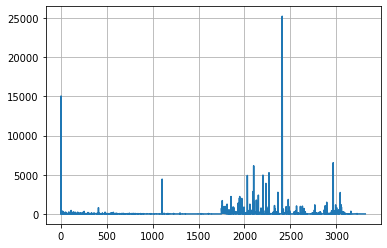

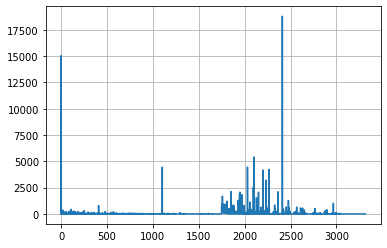

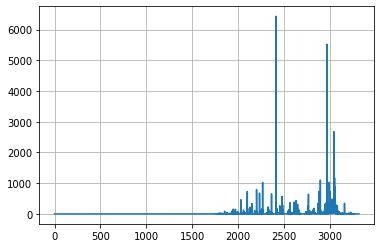

In [18]:
def visualize_SPC(SPC, what='a+m+f'):
    if 'a' in what:
        plt.plot( range(len(ref_subreddit_list)), [el[0] + el[1] for el in SPC.values()]  )
        plt.grid()
        plt.show()
    if 'm' in what:
        plt.plot( range(len(ref_subreddit_list)), [el[0]  for el in SPC.values()]  )
        plt.grid()
        plt.show()
    if 'f' in what:
        plt.plot( range(len(ref_subreddit_list)), [el[1]  for el in SPC.values()]  )
        plt.grid()
        plt.show()

visualize_SPC(TRAIN_SPC)


subreddit whith higest percentage of sex 0
['DragonsDogma', 'buildapcsales', 'ExploreFiction', 'democrats', 'skrillex', 'regularshow', 'dayz', 'worldpolitics', 'Triumph', 'Warthunder', 'dresdenfiles', 'fantasybball', 'pcgaming', 'stobuilds', 'deeproute', 'BitMarket', 'SecretSubreddit', 'Smite', 'cigars', 'Texans', 'Bandnames', 'Naruto', 'AnimeFigures', 'knifeclub', 'TF2fashionadvice', 'vfx', 'photocritique', 'wargame', 'ems', 'CookieClicker', 'ImaginaryTechnology', 'Hotwife', 'newtothenavy', 'Bass', 'nethack', 'buildapcforme', 'KansasCityChiefs', 'toosoon', 'canadaguns', 'Metalcore', 'Monitors', 'Shitty_Car_Mods', 'angelsbaseball', 'frugalmalefashion', 'minnesota', 'wildhockey', 'pebble', 'steelers', 'KerbalSpaceProgram', 'Cricket']
subreddit whith higest percentage of sex 1
['Etsy', 'SexToys', 'brasil', 'discworld', 'mturk', 'predaddit', 'Thailand', 'auto', 'ketorage', 'Methadone', 'Iowa', 'appstate', 'RedditLaqueristaSwap', 'SingleParents', 'etymology', 'TeenParenting', 'RandomActsOf

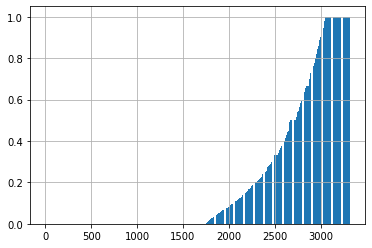

In [19]:
print("subreddit whith higest percentage of sex 0")
print(ref_subreddit_list[:50])
print("subreddit whith higest percentage of sex 1")
print(ref_subreddit_list[-50:])

plt.bar(range(len(TRAIN_SPBS)), TRAIN_SPBS.values())
plt.grid()
plt.show()

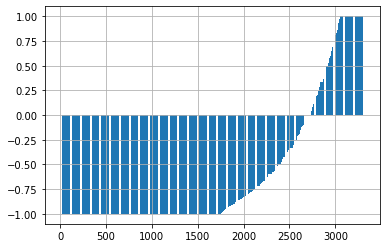

In [20]:
# ############################## computing and visualizing difference based subreddit score

TRAIN_SDBS=subreddit_difference_based_score(TRAIN_SPC)


plt.bar(range(len(TRAIN_SDBS)), TRAIN_SDBS.values())
plt.grid()
plt.show()

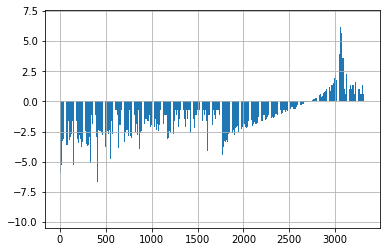

In [21]:
# ############################## computing and visualizing naive bayes subreddit score

TRAIN_SNBS=subreddit_naive_bayes_score(TRAIN_SPC)


plt.bar(range(len(TRAIN_SNBS)), TRAIN_SNBS.values())
plt.grid()
plt.show()

In [22]:

if TO_LOAD_UPC:
    TRAIN_UPC=np.load(PC_SL_prefix+"UPC_TRAIN.npy", allow_pickle=True).item()
    print("loaded UPC")
    
else:    
    TRAIN_UPC=get_UPC(TRAIN_DATA)
    if TO_SAVE_UPC:
        np.save(PC_SL_prefix+"UPC_TRAIN.npy",TRAIN_UPC)
        TO_LOAD_UPC=True
    
# train_user_gender={}
# # dev'essere ordinata come l'array dove tengo gli score
# for username in data.author.unique():
#     train_user_gender[username]=target[target.author==username].gender.values[0]

     242187 posts elaborated from data   [====================]  100.00 %  completed



In [23]:
# check_subreddit_order(TRAIN_UPC) la definisco più avanti nel codice

In [24]:
# PERCENTAGE BASED USER SCORE
print("evaluating percentage based user score")  
PB_train_user_scores=UPBS(TRAIN_USERS, TRAIN_SPBS, TRAIN_UPC)
PB_train_user_scores_values=np.array(list(PB_train_user_scores.values())).reshape(-1,1)
print()

# DIFFERENCE BASED USER SCORE
print("evaluating difference based user score")  
DB_train_user_scores=UDBS(TRAIN_USERS, TRAIN_SDBS, TRAIN_UPC)
DB_train_user_scores_values=np.array(list(DB_train_user_scores.values())).reshape(-1,1)   
print()

# NAIVE BAYES USER SCORE 
print("evaluating naive bayes user score") 
NB_train_user_scores=UNBS(TRAIN_USERS, TRAIN_SNBS, TRAIN_UPC)
NB_train_user_scores_values=np.array(list(NB_train_user_scores.values())).reshape(-1,1)

evaluating percentage based user score

evaluating difference based user score

evaluating naive bayes user score


In [25]:
train_user_gender={}
for user in TRAIN_USERS:
    train_user_gender[user]=int(TRAIN_TARGET[TRAIN_TARGET.author==user].gender.values[0])

In [26]:

def score_visualization(US, score, steps=100, UG=None, color='b', graph_prefix="", min=None, max=None, y_max=None):
    if type(US) is dict:
        US_values=dictoarr(US)
    else:
        US_values=US
    if score is 'PB':
        min_score=0
        max_score=1
    if score is 'DB':
        min_score=-1
        max_score=1
    if score is 'NB':
        min_score=US_values.min()
        max_score=US_values.max()

    if min!= None:
        min_score=min
    if max!= None:
        max_score=max
    delta=(max_score-min_score)/100
    count_occ=np.zeros(steps)
    # print(min_score)
    # print(max_score)
    # print(delta)
    # print(arange(min_score,max_score,delta))
    for value in US_values:
        for i in range(steps):
            if value<(min_score+(i+1)*delta):
                count_occ[i]+=1
                break
    # print(count_occ)
    fig, ax= plt.subplots(1)
    plt.title(graph_prefix+score+" score occurrences")
    if y_max!= None:
        ax.set_ylim(0,y_max)
    plt.bar(arange(min_score,max_score,delta),count_occ,width=delta, color=color)
    plt.grid()
    plt.show()
    if UG is not None and type(US) is dict:
        y_max=np.array(count_occ).max()
        gender_values=[[],[]]
        gender_values[0]=np.array([US[user] for user in US if UG[user]==0])
        gender_values[1]=np.array([US[user] for user in US if UG[user]==1])
        score_visualization(gender_values[0], score, color='g', graph_prefix='sex0 ', min=min_score, max=max_score, y_max=y_max)
        score_visualization(gender_values[1], score, color='r', graph_prefix='sex1 ', min=min_score, max=max_score,y_max=y_max)



PB score visualization:


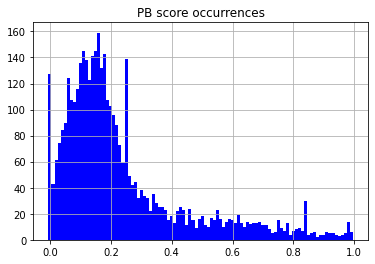

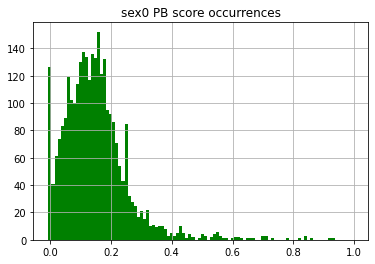

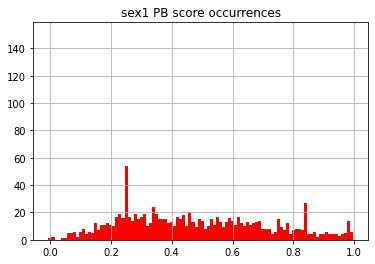

In [27]:
print()
print("PB score visualization:")
score_visualization(PB_train_user_scores, 'PB', UG=train_user_gender)
print()


DB score visualization:


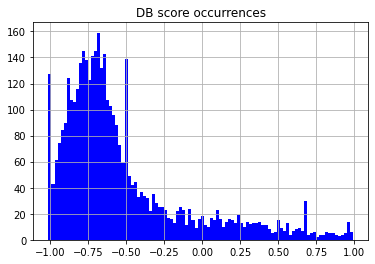

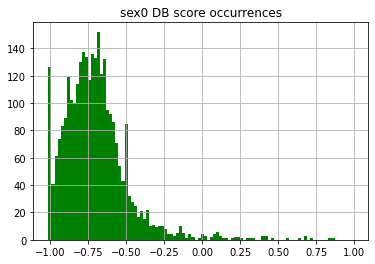

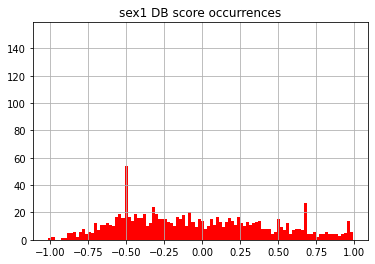

In [28]:
print()
print("DB score visualization:")
score_visualization(DB_train_user_scores, 'DB', UG=train_user_gender)
print()


NB score visualization:


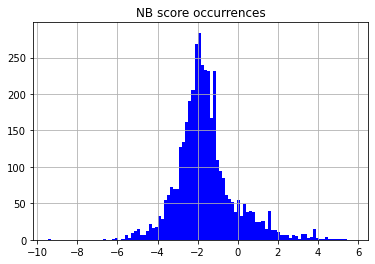

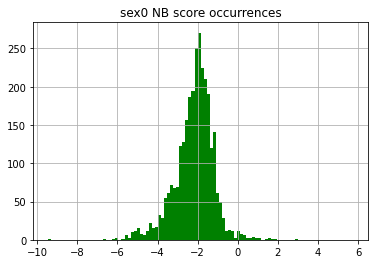

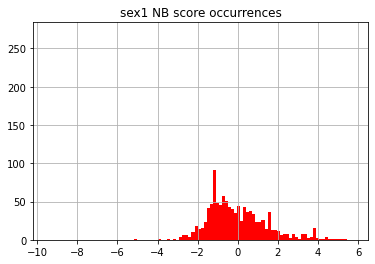

In [29]:
print()
print("NB score visualization:")
score_visualization(NB_train_user_scores, 'NB', UG=train_user_gender)
print()

In [30]:
# NB_train_user_scores

In [31]:
# for n, user in enumerate(UPC):
#     if n>5:
#         break
#     print(list(UPC[user].keys())[:10])
# print(list(NBS.keys())[:10])
# print(list(SGP.keys())[:10])

# for n, user in enumerate(UPC):
#     if n>5:
#         break
#     print(list(UPC[user].keys())[-10:])
# print(list(NBS.keys())[-10:])
# print(list(SGP.keys())[-10:])

In [32]:
# user dict è in forma {user: {UPBS:..., UNBS:...}} dict di dict
# feat_renorm si aspetta un dizionario in questa forma e seleziona feat da una stringa

#NB GLI POTREI FAR FARE UN TFIDF
def feat_renorm(USERS_FEATS, feat, out_type='dict', feat_col_avgs=None, feat_col_stds=None, get_parameters=False, JUST_get_parameters=False):
    if type(feat) is not str:
        print("feat deve essere una sola, passata come nome della feature")
        return

    feat_matrix=[]
    for user in USERS_FEATS:
        feat_matrix.append( np.array(USERS_FEATS[user][feat])  )
    feat_matrix=np.array(feat_matrix)#.reshape(-1,-1)

    if feat_col_avgs is None or feat_col_stds is None:
        print(" number of users to compute avgs and stds:", len(USERS_FEATS))
        print(" computing avgs and stds on feature columns...")
        fc_avg=[]
        # fc_var=[]
        fc_std=[]
        for feat_column in feat_matrix.T:
            fc_avg.append(feat_column.mean())
            # fc_var.append(feat_column.var())
            fc_std.append(feat_column.std())
    else:
        fc_avg=feat_col_avgs
        fc_std=feat_col_stds

    if JUST_get_parameters:
        return fc_avg, fc_std

    if out_type is 'nparr':
        normed_feat=[]
    elif out_type is 'dict':
        normed_feat={}

    tot_users=len(USERS_FEATS)
    stepping=-1
    for n, (user, user_row) in enumerate(zip(USERS_FEATS.keys(),feat_matrix)):
        if out_type is 'nparr':
            normed_feat.append( np.array([ (el-fc_avg[n])/fc_std[n] for n, el in enumerate(user_row) ]) ) 
        elif out_type is 'dict':
            normed_feat[user] = np.array([ (el-fc_avg[n])/fc_std[n] for n, el in enumerate(user_row) ]) 

        stepping=perc_compl(n,tot_users,last_step=stepping, step=0.001,
        text="     {:>6d}".format(n+1)+" user renormalization ( of feat "+feat+" ) elaborated")

    print()
    if out_type is 'nparr':
        normed_feat=np.array(normed_feat)

        # for column in normed_feat.T:
        #     print( column.mean(), column.var() )
        #     break
            
    if not get_parameters:
        return normed_feat
    else:
        return normed_feat, fc_avg, fc_std

In [33]:
def feat_visualize(USER_FEATS_DICT, feature, prefix=''):
    avg, std= feat_renorm(USER_FEATS_DICT, feature,  JUST_get_parameters=True)
    plt.plot(avg)
    plt.title(prefix+" averages of feature "+feature)
    plt.show()
    plt.title(prefix+" stdevs of feature "+ feature)
    plt.plot(std, color='r')
    plt.show()

def TVT_feat_vis(feature):
    feat_visualize(TRAIN_USERS_FEATS, feature, prefix='TRAIN ')
    feat_visualize(VALID_USERS_FEATS, feature, prefix='VALID ')
    feat_visualize(TEST_USERS_FEATS, feature, prefix='TEST')


# ****Features derivate da word embedding****

Qui lavoro al modello con feature basate sul word embedding. Innanzitutto ho calcolato i vettori parole, preprocessandole eliminando stopwords, maiuscole e parole poco frequenti. Il lavoro di visualizzazione e valutazione di questi vettori è preso dal progetto che portai l'anno scorso per l'esame di reti neurali, ma in breve osserva qualche proprietà geometrica dei vettori (usando la norma o la metrica di cosine similarity) e valutazioni semantiche-sintattiche. Ho allenato e testato diversi modelli in una griglia di iperparametri, ma non ho osservato differenze molto significative quando ho poi passato i diversi embedding al modello di classificazione.

Per poi attribuire ad ogni utente il suo vettore di parole, ho innanzitutto considerato solo i versori dei vettori parole (per evitare di dover rinormalizzare in seuito, e per evitare che parole con norme molto grandi "nascondessero" le informazioni delle altre), poi calcolato la media di parole tra tutte quelle usate dall'utente. 

Provando varie opzioni su come normalizzare e come sommare, o in generale come ottenere un vettore documento dai vettori parole, ho scelto questo metodo perché abbastanza semplice da implementare ma anche abbastanza efficace: come si vede dalla visualizzazione i vettori così ricavati per gli utenti mostrano già una leggera distinzione tra vettori maschili e femminili (usando la cosine similarity, i vettori attribuiti ad utenti femminili sono leggermente più diversi da quelli maschili rispetto a quanto tutti i vettori indistintamente siano diversi tra loro) ma una scelta più efficace sarebbe forse stata sostituire la media diretta con una media pesata sui tf-idf delle parole

In [34]:
# #################################################################### TEXT BASED MODEL

In [35]:
print(" importing spacy utils... ")
import spacy
from spacy.lang.en import English
# from spacy.tokenizer import Tokenizer
print(" importing tokenizer... ")
nlp = spacy.load('en_core_web_sm')
tokenizer=nlp.Defaults.create_tokenizer(nlp)

print()
print(" Importing Gensim utils...")
import gensim as gs
from gensim.models import Word2Vec
from gensim.models.word2vec import Word2VecVocab
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.test.utils import datapath
from gensim import utils
import gensim.downloader as api
import gzip


 importing spacy utils... 
 importing tokenizer... 

 Importing Gensim utils...


In [36]:
if LOAD_PRETRAINED_EMBEDDING:
    default_vects=Word2VecKeyedVectors.load(prefixer(w2v_params,prep_sett,WEMB_SL_prefix)+'.vectors')
    
    
if not LOAD_PRETRAINED_EMBEDDING:
    Corpus=WEMB_DATA.body.values
    total_posts=len(Corpus)

    # se il corpus inizia ad avere dimensioni troppo grosse, posso fare un corpus holder che non lo deve tenere in memoria
    print(" evaluating word embeddings over a corpus of",total_posts,"posts, written by", WEMB_DATA.author.nunique())

# ################################# BUILDING VOCABULARY AND CORPUS PREPROCESS
    vocab={}
    stepping=-1
    for count, post in enumerate(Corpus):
        stepping=perc_compl(count,total_posts,last_step=stepping, step=0.001,
                            text="     {:>6d}".format(count+1)+" posts elaborated from corpus  ")

        tkn_post, _ =preprocess(post)

        Corpus[count]=tkn_post
#        ^^^^^ WARNING: this line preprocess data for reference
#       if I save preprocessed Corpus here, also input data will be preprocessed
        for word in tkn_post:
            if word is TEXT_TO_SUBSTITUTE:
                continue
            if word not in vocab:
                vocab[word]=1
            else:
                vocab[word]+=1


    tmp_vocab=sorted(vocab, key= lambda x:vocab[x], reverse=True)
    vocab={word: vocab[word] for word in tmp_vocab}
    print(len(vocab))

#     # for n, word in enumerate(vocab):
#     #     if n<len(vocab)-50:
#     #         continue
#     #     print(word,"\t", vocab[word])

#     occurrence_count=[]    
#     vocab_values=np.array(list(vocab.values()))
#     for i in range(vocab_values.max()+1) :
#         if i%1000==0:
#             print("\r",i, "occurrence count", end='')
#         occurrence_count.append(np.array([vocab_values==i]).sum())

#     for el in vocab:
#         if vocab[el]>5000:
#             print(el)

#     # plt.scatter(range(len(occurrence_count)),occurrence_count)
#     # plt.show()
#     occurrence_count[1]
#     np.array(occurrence_count[5:]).sum()

 evaluating word embeddings over a corpus of 1403988 posts, written by 20000
     1359356 posts elaborated from corpus   [===================>]  96.82 %  completedpreprocessed a non-string line
     1403988 posts elaborated from corpus   [====================]  100.00 %  completed

446682


In [37]:
###################################################### TRAINING EMBEDDING

if not LOAD_PRETRAINED_EMBEDDING:
    
    print()
    print("     Initializing Embedding Model...", end='')

    model=Word2Vec(min_count=w2v_params["min_count"],
                   vector_size=w2v_params["size"],
                   window=w2v_params["window"],
                   cbow_mean=1,           #1 for using mean of cbow vects, def=1
                   compute_loss=True,
                   negative=5,           #negative sampling  if >0, def =5
                   hs=0)                 #hierarchical softmax for hs=1, def =0

    model.build_vocab_from_freq(vocab)

    print("     Training Embedding Model...")
    print()
    model.train(Corpus,
                total_examples=len(Corpus), 
    #           total_words=Corpus.tot_wrd,
                epochs=w2v_params["epochs"])
    
    default_vects=model.wv
    if SAVE_EMBEDDING:
        model.wv.save(prefixer(w2v_params, prep_sett, WEMB_SL_prefix)+'.vectors')


     Initializing Embedding Model...     Training Embedding Model...



In [38]:
######################################################## embedding parameters trial
if TRIAL_EMBEDDING_PARAMETERS:

    trial_w2v_params=[]
    for min_count in range(4,11,3):
        for size in range(50,150,25):
            for window in range(10,21,5):
                for epochs in range(5,11,5):
                    trial_w2v_params.append({"min_count": min_count,"size": size,"window": window,"epochs": epochs})

    print(len(trial_w2v_params), "trials to train... \n\n")
#     print(trial_w2v_params)    

    for n, trial in enumerate(trial_w2v_params):
        print("trial",str(n+1)+" of", len(trial_w2v_params),":", trial)

        del model
        print("     Initializing Model...", end='')

        model=Word2Vec(min_count=trial["min_count"],
                       vector_size=trial["size"],
                       window=trial["window"],
                       cbow_mean=1,           #1 for using mean of cbow vects, def=1
                       compute_loss=True,
                       negative=5,           #negative sampling  if >0, def =5
                       hs=0)                 #hierarchical softmax for hs=1, def =0

        model.build_vocab_from_freq(vocab)

        print("     Training Model...")
        model.train(Corpus, 
                  total_examples=len(Corpus), 
                  epochs=trial["epochs"])
        model.wv.save(prefixer(trial,prep_sett, WEMB_SL_prefix)+'.vectors')
        print("saving model vectors as ", prefixer(trial,prep_sett, WEMB_SL_prefix)+'.vectors')
        print()

    trial_prefixes=[]
    for n, trial in enumerate(trial_w2v_params):
        trial_prefixes.append(prefixer(trial,prep_sett, WEMB_SL_prefix))
    np.save(SAVE_INPUT_PREFIX+"trial 3003.1.npy", trial_prefixes)

In [39]:
# default_vects=model.wv
wv=default_vects

# %%

print()
print("     Importing sci-kit utils...")
from sklearn.metrics.pairwise import cosine_similarity

print("     Importing numpy utils...")
import numpy as np
from numpy.linalg import norm

print("     Importing matplot utils...")
import matplotlib.pyplot as plt

# def freq(word):
#     return sorted_dict_f[word]



     Importing sci-kit utils...
     Importing numpy utils...
     Importing matplot utils...


In [40]:
# ################################################ analysis function definition

#return position of the word in the vocab
def word_to_index(word,vects=default_vects):
    if type(word)!= str: 
        print('necessario inserire parola in formato str')
        return
    for i, word_v in enumerate(vects.key_to_index ): 
#     for i, word_v in enumerate(vects): should make a dictionary from model if want it to work
        if word==word_v:
            return i
w2i=word_to_index

def index_to_word(index,vects=default_vects):
    for idx, word in enumerate(vects.key_to_index ):
        if idx==index:
            return word
    else:
        print("     word not found")
    #     return word_in_range(n_max=index, window=1, write=False)[0]
i2w=index_to_word


def w_norm(word):
    return norm(wv[word])

def w_versor(word):
    return wv[word]/w_norm(word)   


#comparing both from string and from vector 
def cos_sim(a,b, vects=default_vects):
    if type(a) is str:
        a=vects[a]
    if type(b) is str:
        b=vects[b]
    return cosine_similarity([a],[b])[0][0]
sim=cos_sim

n_max_vocab=1000000

#top similarity in subset of vocab both from string and from vector
# vects needs to be a dictionary of {'word': (vector)}
# default vectors will be model processed ones; needs to tell if different
# "mode" is not needed but will keep it for now 
def topn_sim(thing, n=10, vects=default_vects, metric_f=cos_sim, N_vocab=n_max_vocab):
#     Sim_list={}
#     if mode=='C':
#         if type(thing) is str:
#             vect=vects[thing]
#         else:
#             vect=thing
#         for el in vects:
#             if type(thing) is str and el==thing:
#                 continue
#             Sim_list[el]=sim(vect,vects[el], N_vocab=n_max_vocab, vects=vects)
#         Sim_list=sorted(Sim_list, reverse=True, key=lambda x:x[1])
#         return Sim_list
            
    if type(thing) is str:
        return vects.similar_by_word(thing,topn=n,restrict_vocab=N_vocab)
    return vects.similar_by_vector(thing,topn=n,restrict_vocab=N_vocab)


#return k-st similar word, both from vector and for word 
# andrebbe ottimizzato per trovare i *meno* simili perché così conta sempre tutti dal primo all'ultimo
def nearest_word(vector_or_word, vects=default_vects, k=1, metric_f=cos_sim, N_vocab=n_max_vocab):
    nearest=topn_sim(vector_or_word, n=k, vects=vects, metric_f=metric_f, N_vocab=N_vocab)
    return nearest[k-1][0]
nw=nearest_word

def operation_vs_expected(vector, word, n=1, vects=default_vects, N_vocab=n_max_vocab):
    print("comparing vectors:", sim(vector,word))
    print("\n comparing", word," with nearest word:")
    for i in range(1,n+1):
        w_v=nearest_word(vector,k=i)
        if n!=1: print("{:3} ".format(i), end='')
        print("{:>20}".format(w_v), "vs", "{:<20}".format(word),":", sim(w_v, word, vects=vects))
        



In [41]:
# 1     ########################################################################  NORMS


# %%
# NORM ANALYSIS
vocab_size=len(default_vects.key_to_index )

vec_norms=[]
vec_index=[]
stepping=-1

def norm_glob_analisys(vects=default_vects, n_skip=1):
    global vec_norms
    global vec_index
    
    stepping=-1
    for i, x in enumerate(vects.key_to_index ):
        stepping=perc_compl(i,vocab_size,last_step=stepping, step=1,
                            text="     {:>8d}".format(i+1)+" words elaborated;  ")
        if i%n_skip==0:
            vec_index.append(i)
            vec_norms.append(w_norm(x))
        
        
print("     Computing vector's norm:")
norm_glob_analisys()


# %%
# NORMS MEAN

n_mean=np.mean(vec_norms)
n_std=np.std(vec_norms)

print("     mean of the norms:",n_mean)
print("     standard dev.    :",n_std)


# %%
# BIGGEST NORM INFO
mult_norm=4
max_tell=15


count=0
flag_stop=False
print("   \"far\" words, with bigger norm than {:3.3f}".format(n_mean+mult_norm*n_std),"( mean +",mult_norm,"* st.dev):\n")
for i, word, this_norm in zip(vec_index,wv.key_to_index,vec_norms):
    if(this_norm>n_mean+mult_norm*n_std):
        count+=1
        if flag_stop: continue
        if count>max_tell:
            print()
            print("      ... and more...")
            flag_stop=True
            continue
        print("   _{:_<3d}_index:__{:_>6d}_______{:_<30}_norm={:_<9.2f}".format(count,i,word,this_norm))
        
#     if i>100000: break
#     if i>143753 and i%12345==0: print(i,'\t', end='\r')
print("\n     Total amount of \"far\" words:", count)




#----------------------------------------  NORMS_MEAN 

norms_mean=[]
window=25
l=len(vec_norms)-1
start=0
end=0
stepping=-1
print("     Norms mean Analysis:")
for i in range(l+1):
    stepping=perc_compl(i,l+1,last_step=stepping, step=1,
                        text="     {:>8d}".format(i+1)+" words elaborated;  ") 
    if i-window<0: start=0
    else: start=i-window
    if i+window>l: end=l
    else: end=i+window
    norms_mean.append(np.mean(vec_norms[start:end]))

     Computing vector's norm:
        75983 words elaborated;   [====================]  100.00 %  completed

     mean of the norms: 3.371984
     standard dev.    : 4.4663253
   "far" words, with bigger norm than 21.237 ( mean + 4 * st.dev):

   _1___index:_______5_______hours__________________________norm=26.52____
   _2___index:_______6_______happened_______________________norm=22.89____
   _3___index:_______7_______lost___________________________norm=22.56____
   _4___index:_______8_______50_____________________________norm=24.05____
   _5___index:_______9_______ready__________________________norm=23.42____
   _6___index:______10_______fix____________________________norm=24.82____
   _7___index:______11_______expected_______________________norm=23.80____
   _8___index:______12_______event__________________________norm=25.06____
   _9___index:______13_______people_________________________norm=21.35____
   _10__index:______14_______dollar_________________________norm=24.85____
   _11

In [42]:
# type(wv.key_to_index ) 
# wv.key_to_index

In [43]:
# 3     ###############################################################################  TOP(10)SIM MEAN


# %%


def avg_sim_with_topn_sim(word_or_vec,n=10, vects=default_vects,N_vocab=n_max_vocab):
    n_most_similar=topn_sim(word_or_vec,n,vects=vects, N_vocab=N_vocab)
    summ=0
    for word_and_value in n_most_similar:
        summ+=word_and_value[1]
    return summ/n
avgsim=avg_sim_with_topn_sim

N_bins=100
N_topn_words_to_average=10

hist_avgsim=[]
hist_avgsim.append([])
hist_avgsim.append([])

for i in range(N_bins):
    hist_avgsim[0].append(i/N_bins)
    hist_avgsim[1].append(0)
# hist[0] for x-axis, hist[1] for y-axis

# compute on all vocab word but could be sampled or window-selected
N_word_in_model_vocab=len(wv.key_to_index )
stepping=-1
print()
print("     Processing Avg_sim Histogram:")
wind_start=int(vocab_size/10)
wind_size=1000
for j, word in enumerate(wv.key_to_index ):
    if j<wind_start:continue
    if j>=wind_start+wind_size: break
    stepping=perc_compl(j-wind_start,wind_size,last_step=stepping, step=0.001,
                                     text="     {:>6d}".format(j+1-wind_start)+" words elaborated from model's vocab  ")
    sim_value=avgsim(word,n=N_topn_words_to_average)
    for i in range(N_bins):
        if sim_value <= i/N_bins:
#           in bin 'x' we have value in ]x-1/Nbin,x]
            hist_avgsim[1][i]+=1
            break

# %%
# AVERAGE OF TOP(10)MEAN
# when model performs well 
# mean is around 0.7 and variance  (????)

avgsim=[]
for i,_ in enumerate(hist_avgsim[0]):
    for n in range(hist_avgsim[1][i]):
        avgsim.append(hist_avgsim[0][i])
print("     avg= ",np.mean(avgsim))
print("     std= ",np.std(avgsim))  



     Processing Avg_sim Histogram:
       1000 words elaborated from model's vocab   [====================]  100.00 %  completed

     avg=  0.7274700000000001
     std=  0.09386212814548794


In [44]:
# 4     ###############################################################################  KST WORD MEAN SIMILARITY


# %%
# KST WORD MEAN SIMILARITY

K_max=len(wv.key_to_index )
# ^^^^^ K up to
N_min=int(vocab_size/5)
# ^^^^^ Index of first word look
sample_size=100
# ^^^^^ How many words to look at
N_max=N_min+sample_size

hist_Kst_sim=[]
for i in range(K_max):
    if i== len(wv.key_to_index )-1: break
    hist_Kst_sim.append([])
    hist_Kst_sim[i]=0
stepping=-1
print()
print("     Processing Kst_sim Histogram: ")
for n in range(N_min,N_max):
    word=i2w(n)
    stepping=perc_compl(n-N_min,N_max-N_min,last_step=stepping, step=1,
                        text="     {:>6d}".format(n+1-N_min)+" words elaborated from model's vocab  ")
    for K, Kst_word in enumerate(topn_sim(word,n=K_max+1)):
        hist_Kst_sim[K]+=Kst_word[1]
for i,_ in enumerate(hist_Kst_sim):
    hist_Kst_sim[i]/=sample_size

# %%
# KST WORD MEAN SIMILARITY INFO

print("    Vocab words in indexes [{},{}[ :".format(N_min,N_max))
print()
for i in range(11):
    curr=int(i*(K_max/10))
    if curr>=K_max:
        curr=K_max-2
    print("     {:<4d} st word's cos_sim is averagely {:1.5f}".format(curr+1,hist_Kst_sim[curr]) )




     Processing Kst_sim Histogram: 
        100 words elaborated from model's vocab   [====================]  100.00 %  completed

    Vocab words in indexes [15196,15296[ :

     1    st word's cos_sim is averagely 0.75505
     7599 st word's cos_sim is averagely 0.32971
     15197 st word's cos_sim is averagely 0.26826
     22795 st word's cos_sim is averagely 0.22370
     30394 st word's cos_sim is averagely 0.18351
     37992 st word's cos_sim is averagely 0.14359
     45590 st word's cos_sim is averagely 0.10153
     53189 st word's cos_sim is averagely 0.05489
     60787 st word's cos_sim is averagely -0.00068
     68385 st word's cos_sim is averagely -0.07640
     75982 st word's cos_sim is averagely -0.46224


In [45]:
######################################################### SEMANTIC TESTS

file_out=sys.stdout

list_of_words_contxt_recognition=['sound','wave','army','king','achilles','cave','quantum','machine']
list_of_words_gender_recognition=['king','man','son','father','grandfather','husband','boyfriend']
list_of_words_plural_recognition_numerable=['car','house','tree']
list_of_words_plural_recognition_not_numer=['sand','man','water']

def_n_ctx=7
def_n_gnd=7
def_n_plr=7
def_n_oth=10

def tell_topn_sim_contxt_recognition(list_of_words,n=5,vects=default_vects, file=file_out):
    for word in list_of_words:
        if word not in vects:
            print(word, "not in model")
            continue
        to_be_evaluated=word
        
        print(file=file)
        print("     word:", word, file=file)
        print("     most similar:", topn_sim(to_be_evaluated,n=n,vects=vects), file=file)
        
def tell_topn_sim_gender_recognition(l_o_w,n=5,vects=default_vects, file=file_out):
    for word in l_o_w:
        if word not in vects:
            print(word, "not in model")
            continue
        to_be_evaluated=w_versor(word)-w_versor('male')+w_versor('female')
        print(file=file)
        print("     "+word,"- male + female:", file=file)
        print("nearest words:", topn_sim(to_be_evaluated,n=n, vects=vects), file=file)

def tell_topn_sim_plural_recognition(l_o_w_numerable,l_o_w_not_numer,n=5,vects=default_vects, file=file_out):
    if LEMMATIZE:
        return
    print("    {:.^55}".format("Numerable words"), file=file)
    for i, word in enumerate(l_o_w_numerable):
        if word not in vects:
            print(word, "not in model")
            continue
        for j, word_comp in enumerate(l_o_w_numerable):
            if j==i: continue                
            to_be_evaluated=w_versor(word+'s')-w_versor(word)+w_versor(word_comp)
            print(file=file)
            print("     "+word+'s',"-",word,'+',word_comp,":", file=file)
            print("     nearest words:", topn_sim(to_be_evaluated,n=n, vects=vects), file=file)
    print(file=file)
    print("  {:.^55}".format("Not numerable words"), file=file)
    for word in l_o_w_numerable:
        if word not in vects:
            print(word, "not in model")
            continue
        for word_comp in l_o_w_not_numer:
            to_be_evaluated=w_versor(word+'s')-w_versor(word)+w_versor(word_comp)
            print(file=file)
            print("     "+word+'s',"-",word,'+',word_comp,":", file=file)
            print("     nearest words:", topn_sim(to_be_evaluated,n=n, vects=vects), file=file)

def other_tests(n=def_n_oth, file=file_out):
    if LEMMATIZE:    
        return
    print("     husband - male vs wife - female :",sim(w_versor('husband')-w_versor('male'), w_versor('wife')-w_versor('female')), file=file)
    print("     king - male vs queen - female :",sim(w_versor('king')-w_versor('male'),w_versor('queen')-w_versor('female')), file=file)
    print("     birds-cars vs bird - car",sim(w_versor('birds')-w_versor('cars'), w_versor('bird')-w_versor('car')), file=file)
    print(file=file)
    print("     france-paris+italy",topn_sim(w_versor('france')-w_versor('paris')+w_versor('italy'),n=def_n_oth,vects=default_vects), file=file)
    
    print(file=file)
    avg_cos_sim=0
    count=0
    bigger_l_o_w_numerable=['dog','cat','chair','hat','king','bed','windmill','rainbow','wall','boat']
    bigger_l_o_w_numerable+=list_of_words_plural_recognition_numerable
    for i, word1 in enumerate(list_of_words_plural_recognition_numerable):
        for j, word2 in enumerate(list_of_words_plural_recognition_numerable):
            if j<= i: continue
            count+=1
            avg_cos_sim+=sim(w_versor(word1+'s')-w_versor(word2+'s'),w_versor(word1)-w_versor(word2))
    avg_cos_sim/=count
    print("     Average result (on sample of {:3d} words) for numerable plural recognition: {:2.4f}".format(len(bigger_l_o_w_numerable), avg_cos_sim), file=file)
    print("     Against average top similarity (between vocab words) of: {:2.4f}".format(hist_Kst_sim[0]), file=file)
    print("     rating on (very) small sample task: {:2.2f}".format(avg_cos_sim/hist_Kst_sim[0]), file=file)

    
def testing(l_o_w_ctx, l_o_w_gnd, l_o_w_plr, l_o_w_plrnn, other=None,
            n_ctx=5,n_gnd=5,n_plr=5,
            vects=default_vects, 
            file=file_out):
    print(file=file)   
    print("    {:#^55}".format(" Testing on some task examples "),file=file)    
    print(file=file)
    print("    {:-^55}".format("context recognition (topn_sim)"), file=file)
    tell_topn_sim_contxt_recognition(l_o_w_ctx,n=n_ctx,vects=vects, file=file)
    print(file=file)
    print("    {:-^55}".format("gender recognition"), file=file)
    tell_topn_sim_gender_recognition(l_o_w_gnd,n=n_gnd,vects=vects, file=file)
    print(file=file)
    if LEMMATIZE:
        return
    print("    {:-^55}".format("plural recognition"),'\n', file=file)
    tell_topn_sim_plural_recognition(l_o_w_plr,l_o_w_plrnn,n=n_gnd,vects=vects, file=file)
    if other != None:
        print(file=file)
        print("    {:-^55}".format(" other tests"), file=file)
        other(file=file)

        
# %%
# CALLING TESTING FUNCTIONS

testing(list_of_words_contxt_recognition,  
       list_of_words_gender_recognition,  
       list_of_words_plural_recognition_numerable,  
       list_of_words_plural_recognition_not_numer, 
        n_ctx=def_n_ctx, 
        n_gnd=def_n_gnd,
        n_plr=def_n_plr,
       other=other_tests,
       file=file_out)

# if file_out is not None:
#     testing(list_of_words_contxt_recognition,  
#            list_of_words_gender_recognition,  
#            list_of_words_plural_recognition_numerable,  
#            list_of_words_plural_recognition_not_numer, 
#             n_ctx=def_n_ctx, 
#             n_gnd=def_n_gnd,
#             n_plr=def_n_plr,
#            other=other_tests,
#            file=file_out) 


    ############ Testing on some task examples ############

    ------------context recognition (topn_sim)-------------

     word: sound
     most similar: [('sounds', 0.7937794923782349), ('sounding', 0.7695176005363464), ('sounded', 0.6029306054115295), ('bass', 0.5838062763214111), ('audiophile', 0.5834758281707764), ('louder', 0.5821611881256104), ('timbre', 0.5717329382896423)]

     word: wave
     most similar: [('waves', 0.6973341703414917), ('movement', 0.5379598736763), ('shockwave', 0.5126328468322754), ('burst', 0.5100696086883545), ('tidal', 0.5096985101699829), ('spinning', 0.5028355121612549), ('outwards', 0.49758297204971313)]

     word: army
     most similar: [('troops', 0.8525010943412781), ('soldiers', 0.8052316904067993), ('armies', 0.7847877740859985), ('military', 0.7801160216331482), ('naval', 0.7659944891929626), ('stationed', 0.7631117701530457), ('deployed', 0.7606291770935059)]

     word: king
     most similar: [('throne', 0.821224570274353), ('queen',

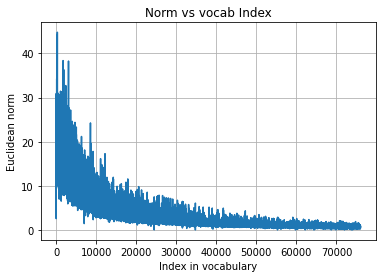

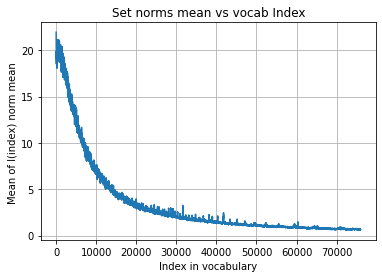

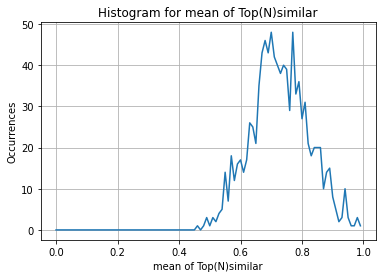

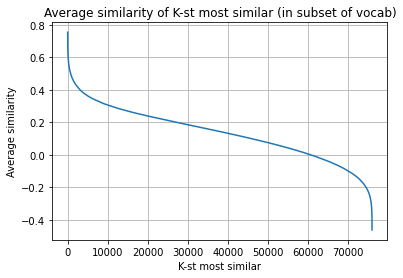

In [46]:
# ##################################################### vector space graphs

st=0
en=len(vec_index)

graph_name='Norm vs vocab Index'

fig_NvI, graph_NvI = plt.subplots()
graph_NvI.plot(vec_index[st:en],vec_norms[st:en])
graph_NvI.set(xlabel='Index in vocabulary', ylabel='Euclidean norm',
       title=graph_name)
graph_NvI.grid()

# this_pathname_save_img=pathname_save_img+graph_name+'.png'
# if SAVE_FIG:
#     fig_NvI.savefig(this_pathname_save_img)


graph_name='Set norms mean vs vocab Index'

fig_NMvI, graph_NMvI = plt.subplots()
graph_NMvI.plot(vec_index[st:en],norms_mean[st:en])
graph_NMvI.set(xlabel='Index in vocabulary', ylabel='Mean of I(index) norm mean ',
       title=graph_name)
graph_NMvI.grid()

# this_pathname_save_img=pathname_save_img+graph_name+'.png'
# if SAVE_FIG:
#     fig_NMvI.savefig(this_pathname_save_img)

    
graph_name='Histogram for mean of Top(N)similar'

fig_TSMvI, graph_TSMvI = plt.subplots()
graph_TSMvI.plot(hist_avgsim[0],hist_avgsim[1])
graph_TSMvI.set(xlabel='mean of Top(N)similar', ylabel='Occurrences',
       title=graph_name)
graph_TSMvI.grid()

# this_pathname_save_img=pathname_save_img+graph_name+'.png'
# if SAVE_FIG:
#     fig_TSMvI.savefig(this_pathname_save_img)

    
graph_name='Average similarity of K-st most similar'

fig_KSTM, graph_KSTM = plt.subplots()
graph_KSTM.plot(range(1,K_max),hist_Kst_sim)
graph_KSTM.set(xlabel='K-st most similar', ylabel='Average similarity',
       title=graph_name+' (in subset of vocab)')
graph_KSTM.grid()

In [47]:
# ######################################################### USER EMBEDDINGS FUNCTIONS
from numpy.linalg import norm

def post2vec(post, mode, vect, word_vectors=default_vects):
    if type(post) is not list:
        print("\n WARNING post not preprocessed")
        if type(post) is str:
            post=preprocess(post)
        else:
            print("\n WARNING post is not a string")
            post=preprocess(str(post))
    
    postVec=np.zeros(w2v_params['size']) 
    word_counter=0
    for n_words, word in enumerate(post):
        if word in word_vectors:
            if vect is 'vect':
                wv=word_vectors[word]
            elif vect is 'vers':
                wv=word_vectors[word]/norm(word_vectors[word])
            postVec+=wv
            word_counter+=1
    if mode is 'sum':
        return np.array(postVec), word_counter
    elif mode is 'avg':
        return np.array(postVec)/(n_words+1), word_counter
    print(" no match for this call")
    

def get_users_u2v(mode, data, users_list, wv=default_vects, preprocess_lines=False, display=True, p2v_vect=P2V_VECT):
# NB usable modes: 'sum', 'word_avg','post_avg'
    u2v={user: np.zeros(w2v_params['size']) for user in users_list}
    uwc={user: 0 for user in users_list}
    upc={user: 0 for user in users_list}

    if mode is 'sum' or mode is 'word_avg':
        p2v_mode='sum'
    elif mode is 'post_avg':
        p2v_mode='avg'
    else:
        print("no match for this call (p2v with u2v mode",mode,")")

    total_posts=len(data)
    flag_check_preprocess=False
    stepping=-1
    for n, (_,post_row) in enumerate(data.iterrows()):
            
        if not flag_check_preprocess:
            if preprocess_lines and type(post_row.body) is list:
                print("\nWARNING: input data already preprocessed")
                preprocess_lines=False
                flag_check_preprocess=True
            elif not preprocess_lines and type(post_row.body) is not list:
                print("\nWARNING: input data to be preprocessed")
                preprocess_lines=True    
                flag_check_preprocess=True
            print()
            print("  computing U2V: u2v mode is "+mode+"; p2v mode is "+p2v_mode+" with "+ P2V_VECT)
            print("  in line preprocessing:",preprocess_lines)
            print("  evaluating", len(users_list),"users with", total_posts,"posts")
            print()
        
        if display:
            stepping=perc_compl(n,total_posts,last_step=stepping, step=0.001,
                                text="     {:>6d}".format(n+1)+" posts elaborated from data  ")       
        user=post_row.author
        if user not in u2v:
            continue       
        if preprocess_lines or type(post_row.body) is not list:
            post, _ =preprocess(post_row.body)
        else:
            post =row.body
            
        vectorized_post, n_words=post2vec(post, p2v_mode, p2v_vect, word_vectors=wv)    
        u2v[user]+=vectorized_post
        uwc[user]+=n_words
        upc[user]+=1

    for user in u2v:
        if uwc[user]== 0:
            uwc[user]=1
        if upc[user]==0:
            upc[user]=1

    if mode is 'sum':
        to_return_u2v=u2v
    elif mode is 'word_avg':
        to_return_u2v={user: u2v[user]/uwc[user] for user in u2v}
    elif mode is 'post_avg':
        to_return_u2v={user: u2v[user]/upc[user] for user in u2v}


    return to_return_u2v


In [48]:
LOAD_PRETRAINED_U2V['train']

False

In [49]:
SAVE_U2V['train']

True

In [50]:
prefixer(w2v_params,prep_sett, U2V_SL_prefix['train'])

'./TRAIN_U2V_word_avg_vers_;_alldata_min_count5_size100_window20_epochs5_LW1LM0RP1RS1PM1RM1'

In [51]:
if not LOAD_PRETRAINED_U2V['train']: 
    TRAIN_U2V=get_users_u2v(U2V_MODE, TRAIN_DATA, TRAIN_USERS, p2v_vect=P2V_VECT) 
    if SAVE_U2V['train']:
        np.save(prefixer(w2v_params,prep_sett, U2V_SL_prefix['train'])+'.npy',TRAIN_U2V)
        LOAD_PRETRAINED_U2V['train']=True
else:    
    # TRAIN_U2V=np.load(prefixer(w2v_params,prep_sett, U2V_SL_prefix['train'])+'.npy', allow_pickle=True).item()
   TRAIN_U2V=np.load(prefixer(w2v_params,prep_sett, U2V_SL_prefix['train'])+'.npy', allow_pickle=True).item()
   print("loaded", len(TRAIN_U2V),"U2V for training")



  computing U2V: u2v mode is word_avg; p2v mode is sum with vers
  in line preprocessing: True
  evaluating 4000 users with 242187 posts

     242187 posts elaborated from data   [====================]  100.00 %  completed



   extractions evaluated 9000

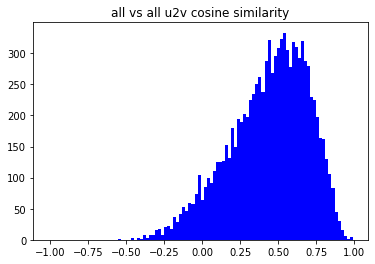

 in trial of 9999.0 :
 avg= 0.4585798579857987
 var= 0.06559350274861456
   extractions evaluated 9000

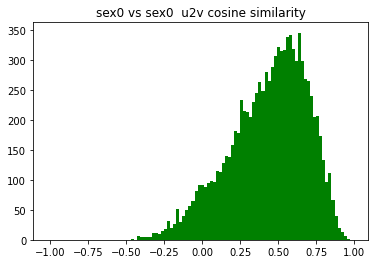

 in trial of 10000.0 :
 avg= 0.454978
 var= 0.06446825951600008
   extractions evaluated 9000

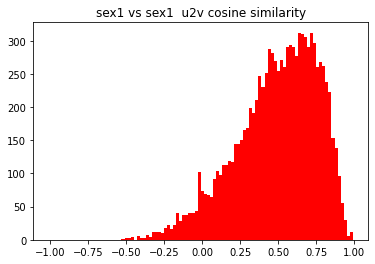

 in trial of 10000.0 :
 avg= 0.51118
 var= 0.07090532760000012
   extractions evaluated 9000

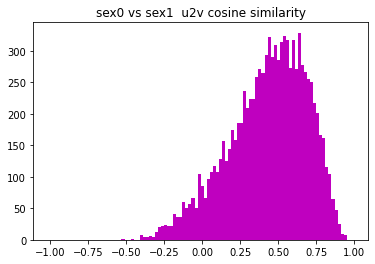

 in trial of 10000.0 :
 avg= 0.45200799999999997
 var= 0.065842607936


In [52]:
def visualize_u2v_similarity(u2v,u2v_comp=None, UG=None, size_trial=10000, hist_steps=100, graph_prefix='all vs all',color='b'):
    if type(u2v) is dict:
        u2v_data=dictoarr(u2v)
    else:
        u2v_data=u2v
    if u2v_comp is not None:
        if type(u2v_comp) is dict:
            u2v_comp_data=dictoarr(u2v_comp)
        else:
            u2v_comp_data=u2v_comp
    else:
        u2v_comp_data=u2v_data
    count_sim_val=np.zeros(hist_steps)
    size_sample1=len(u2v_data)
    size_sample2=len(u2v_comp_data)

    for s in range(size_trial):
        if s%1000==0:
            print("\r   extractions evaluated",s,end='')
        n=np.random.randint(size_sample1)
        m=np.random.randint(size_sample2)
        user_vector1=u2v_data[n]
        user_vector2=u2v_comp_data[m]
        similarity=cos_sim(user_vector1,user_vector2)

        min_sim=-1
        max_sim=1
        delta=(max_sim-min_sim)/hist_steps
        for i in range(hist_steps):
            soglia=min_sim+(i+1)*delta
            if similarity<=soglia:
                count_sim_val[i]+=1
                break
    plt.title(graph_prefix+" u2v cosine similarity")
    plt.bar(arange(min_sim,max_sim,delta),count_sim_val, width=delta, color=color)
    plt.show()
    sim_values=np.array([min_sim+(i+1)*delta for i in range(hist_steps)])
    count_sim_val=np.array(count_sim_val)
    N_extractions=count_sim_val.sum()
    sim_avg=(count_sim_val*sim_values).sum()/N_extractions
    sim_var=(count_sim_val*sim_values**2).sum()/N_extractions-sim_avg**2
    print(" in trial of", N_extractions,":")
    print(" avg=", sim_avg)
    print(" var=", sim_var)

    if UG is not None and type(u2v) is dict:
        # y_max=np.array(count_sim_val).max()
        gender_values=[[],[]]
        gender_values[0]=np.array([u2v[user] for user in u2v if UG[user]==0])
        gender_values[1]=np.array([u2v[user] for user in u2v if UG[user]==1])
        visualize_u2v_similarity(gender_values[0], color='g', graph_prefix='sex0 vs sex0 ')
        visualize_u2v_similarity(gender_values[1], color='r', graph_prefix='sex1 vs sex1 ')
        visualize_u2v_similarity(gender_values[0], u2v_comp=gender_values[1], color='m', graph_prefix='sex0 vs sex1 ')

visualize_u2v_similarity(TRAIN_U2V, UG=train_user_gender)

  found 6  users with null u2v in sample of 4000.0 users of all gender


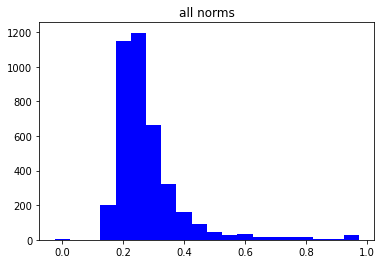

  found 4  users with null u2v in sample of 2932.0 users of sex0  gender


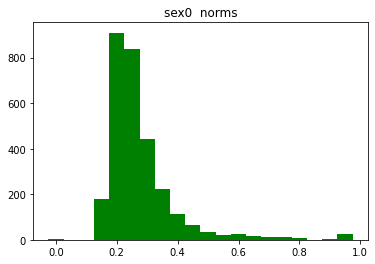

  found 2  users with null u2v in sample of 1068.0 users of sex1  gender


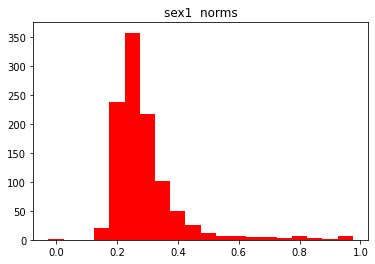

In [53]:

def visualize_u2v_norms(u2v, UG=None, hist_steps=100, graph_prefix='all',color='b'):

    if type(u2v) is not dict:
        u2v_data=u2v
        norms_data=[]
        for s, user_vector in enumerate(u2v_data):
            # if s%1000==0:
            #     print("\r   norms computed",s,end='')
            norms_data.append(norm(user_vector))
        norms_data=np.array(norms_data)

    else:
        norms={}
        for s, user in enumerate(u2v):
            # if s%1000==0:
            #     print("\r   norms computed",s,end='')
            norms[user]=norm(u2v[user])
        norms_data=dictoarr(norms)
    null_norm_counter=0
    for el in norms_data:
        if el==0:
            null_norm_counter+=1
    print("  found", null_norm_counter," users with null u2v", end='')
    min_norm=0
    max_norm=norms_data.max()
    delta=(max_norm-min_norm)/hist_steps
    count_norm_val=np.zeros(hist_steps)
    for s, this_norm in enumerate(norms_data):
        # if (s+1)%1000==0:
        #     print("\r   norms evaluated",(s+1),end='')

        for i in range(hist_steps):
            soglia=min_norm+(i+1)*delta
            if this_norm<=soglia:
                count_norm_val[i]+=1
                break
    print(" in sample of", count_norm_val.sum(), "users of", graph_prefix,"gender")
    plt.title(graph_prefix+" norms")
    plt.bar(arange(min_norm,max_norm,delta),count_norm_val, width=delta, color=color)
    plt.show()
    # sim_values=np.array([min_sim+(i+1)*delta for i in range(hist_steps)])
    # count_sim_val=np.array(count_sim_val)
    # N_extractions=count_sim_val.sum()
    # sim_avg=(count_sim_val*sim_values).sum()/N_extractions
    # sim_var=(count_sim_val*sim_values**2).sum()/N_extractions-sim_avg**2
    # print(" in trial of", N_extractions,":")
    # print(" avg=", sim_avg)
    # print(" var=", sim_var)

    if UG is not None and type(u2v) is dict:
        # y_max=np.array(count_sim_val).max()
        gender_values=[[],[]]
        gender_values[0]=np.array([norms[user] for user in u2v if UG[user]==0])
        gender_values[1]=np.array([norms[user] for user in u2v if UG[user]==1])
        visualize_u2v_norms(gender_values[0], color='g', graph_prefix='sex0 ',hist_steps=hist_steps)
        visualize_u2v_norms(gender_values[1], color='r', graph_prefix='sex1 ',hist_steps=hist_steps)

visualize_u2v_norms(TRAIN_U2V, UG=train_user_gender, hist_steps=20)

In [54]:
# ######################################################################################################### UWC MODEL

# **Features LSA**

Qui lavoro alle features di LSA: ho quindi calcolato innanzitutto la sparse matrix del conteggio utente-parole usate, poi ripesata su tf-idf ed infine dimensionality reduction con TruncatedSVD. Ho scelto di usare solo i lemmi delle parole (per cercare di estrarre informazioni specificamente inerenti al contenuto), rimuovere stopword e considerare solo gli 1-gram (per evitare calcoli troppo intensivi al programma che già stavo faticando a far girare senza intoppi).

Ho infine scelto la dimensione a cui ridurre le features sul solo criterio di allenabilità del modello: una varianza del 90% avrebbe richiesto un numero di parametri nell'ordine di qualche migliaio, mentre il train_dataset era composto di 4000 utenti (togliendo i 1000 di validazione) rischiando dunque overfitting. 

Considerando come indicazione di avere una dimensione dello spazio delle features ridotte di circa un decimo della dimensione del dataset, ho scelto valori tra i 500 e 1000 con l'intenzione poi di regolarizzare in seguito la regressione logistica per evitare overfitting

In [55]:
if not LOAD_ULSA['train']:
    print(" using", UWC_ON_DATA, "datasets to evaluate word counting model...\n\n")

    Corpus_UWC={}

    if 'train' in UWC_ON_DATA:
        UWC_DATA=TRAIN_DATA
        for user in TRAIN_USERS:
            Corpus_UWC[user]=""
    if 'valid' in UWC_ON_DATA:
        UWC_DATA=pd.concat([UWC_DATA, VALID_DATA])
        for user in VALID_USERS:
            Corpus_UWC[user]=""
    if 'test' in UWC_ON_DATA:
        UWC_DATA=pd.concat([UWC_DATA, TEST_DATA])
        for user in TEST_USERS:
            Corpus_UWC[user]=""

    tot_posts=len(UWC_DATA)
    stepping=-1
    for n, (_, row) in enumerate(UWC_DATA.iterrows()):
        user=row.author
        post=row.body
        if type(post) is not str:
            print("\n WARNING got a non-string post")
            post=str(post)

        Corpus_UWC[user]+=" "+post

        stepping=perc_compl(n,tot_posts,last_step=stepping, step=0.001,
                                    text="     {:>6d}".format(n+1)+" posts appended in UWC Corpus  ") 

    len(Corpus_UWC)

 using train+valid+test datasets to evaluate word counting model...


     1359356 posts appended in UWC Corpus   [===================>]  96.82 %  completed
 WARNING got a non-string post
     1403988 posts appended in UWC Corpus   [====================]  100.00 %  completed



In [56]:
# print(Corpus_UWC['Riddance'])
# print( custom_preprocesser(Corpus_UWC['Riddance']) )
# print( custom_tokenizer(Corpus_UWC['Riddance']) )

In [57]:
# class sklearn.feature_extraction.text.CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)[source]¶

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

if not LOAD_ULSA['train']:

    DATA_TO_WC=list( Corpus_UWC.values() )

    WC_MODEL=CountVectorizer(
        # input=DATA_TO_CV,
        preprocessor=custom_preprocesser,
        tokenizer=custom_tokenizer
    )
    print("   fitting word-count model to", UWC_ON_DATA, "data...")
    WC_MODEL.fit(DATA_TO_WC)

    UWC=WC_MODEL.transform(DATA_TO_WC)

    UWC.shape

   fitting word-count model to train+valid+test data...


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [59]:
from sklearn.feature_extraction.text import TfidfTransformer

if not LOAD_ULSA['train']:
    UWC_TFIDF_MODEL=TfidfTransformer()

    UWC_TFIDF_MODEL.fit(UWC)

    UWC_TFIDF=UWC_TFIDF_MODEL.transform(UWC)

    UWC_TFIDF.shape

In [60]:
print(" importing sklearn tool for PCA analisys... ")
from sklearn.decomposition import PCA

 importing sklearn tool for PCA analisys... 


In [61]:
print(" importing sklearn tool for SVD analisys... ")
from sklearn.decomposition import TruncatedSVD

if not LOAD_ULSA['train']:

    # PCA_UWC_TFIDF_MODEL=PCA()
    # print()
    # print()
    # print("   fitting PCA transformation... ")
    # PCA_UWC_TFIDF_MODEL.fit(UWC_TFIDF.toarray())

    LSA_MODEL=TruncatedSVD(n_components=LSA_N_components, algorithm='arpack')
    print()
    print()
    print("   fitting SVD transformation... ")
    LSA_MODEL.fit(UWC_TFIDF)


 importing sklearn tool for SVD analisys... 


   fitting SVD transformation... 


In [62]:
# EXP_GIVEN_VAR_LSA
# GIVEN_VAR_LSA=0.9

  26.56%  of variance is explained by 500  components


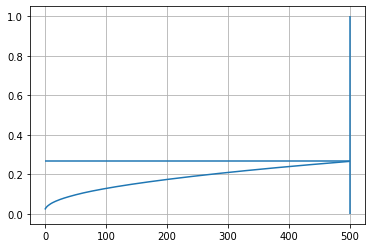

In [63]:
if not LOAD_ULSA['train']:

    cumulative_explained_variance=np.cumsum(LSA_MODEL.explained_variance_ratio_)
    plt.plot(cumulative_explained_variance)

    EXP_GIVEN_VAR_LSA=len(cumulative_explained_variance) - len(cumulative_explained_variance[cumulative_explained_variance>GIVEN_VAR_LSA])
    if EXP_GIVEN_VAR_LSA == len(cumulative_explained_variance):
        GIVEN_VAR_LSA=max(cumulative_explained_variance)
    plt.hlines(GIVEN_VAR_LSA, 0, len(cumulative_explained_variance))
    plt.vlines(EXP_GIVEN_VAR_LSA, 0,1)
    plt.grid()
    print("  "+"{:5.2f}".format(GIVEN_VAR_LSA*100)+"%  of variance is explained by",EXP_GIVEN_VAR_LSA," components")
    plt.show()

In [64]:
def LSA_TRANSFORMATION(raw_text_dataframe, user_list, dataset):

    if dataset in UWC_ON_DATA:
        if dataset=='train':
            uwc_tfidf=UWC_TFIDF[:4000]
        elif dataset=='valid':
            uwc_tfidf=UWC_TFIDF[4000:5000]
        elif dataset=='test':
            uwc_tfidf=UWC_TFIDF[5000:]

    else:   
        raw_texts={}
        for user in user_list:
            raw_texts[user]=""

        stepping=-1
        tot_posts=len(raw_text_dataframe)
        for n, (_, row) in enumerate(raw_text_dataframe.iterrows()):
            user=row.author
            post=row.body
            if type(post) is not str:
                print("\n WARNING got a non-string post")
                post=str(post)

            raw_texts[user]+=" "+post

            stepping=perc_compl(n,tot_posts,last_step=stepping, step=0.001,
                                        text="     {:>6d}".format(n+1)+" posts appended in LSA transformer  ")
        raw_text_list= list(raw_texts.values())     

        print()
        print("  word-count transformation...")
        uwc=WC_MODEL.transform( raw_text_list )
        print()
        print("  tfidf transformation...")
        uwc_tfidf=UWC_TFIDF_MODEL.transform(uwc)
    print()
    print("  SVD transformation...")
    ulsa=LSA_MODEL.transform(uwc_tfidf)

    ULSA={}
    print("\n  building user-lsa dictionary... ")
    for user_name, user_lsa in zip(user_list, ulsa):
        ULSA[user_name]=user_lsa  
        
    return ULSA



In [65]:

prefixer({'size': EXP_GIVEN_VAR_LSA, "on_": UWC_ON_DATA}, UWC_prep_sett , "TRAIN_ULSA__")

'./TRAIN_ULSA__size500_on_train+valid+test_LW1LM1RP1RS1PM0RM1'

In [66]:
if LOAD_ULSA['train']:
    TRAIN_ULSA=np.load(prefixer({'size': EXP_GIVEN_VAR_LSA, "on_": UWC_ON_DATA}, UWC_prep_sett , "TRAIN_ULSA__")+".npy", allow_pickle=True ).item()
    print("  loaded ", len(TRAIN_ULSA), "user latent semantic analisys data")
else:
    print("  transforming train users text data... \n\n")
    TRAIN_ULSA=LSA_TRANSFORMATION(TRAIN_DATA, TRAIN_USERS, 'train')
    if SAVE_ULSA['train']:
        np.save(prefixer({'size': EXP_GIVEN_VAR_LSA, "on_": UWC_ON_DATA}, UWC_prep_sett , "TRAIN_ULSA__"), TRAIN_ULSA)


  transforming train users text data... 



  SVD transformation...

  building user-lsa dictionary... 


In [67]:
if LOAD_ULSA['valid']:
    VALID_ULSA=np.load(prefixer({'size': EXP_GIVEN_VAR_LSA, "on_": UWC_ON_DATA}, UWC_prep_sett , "VALID_ULSA__")+".npy", allow_pickle=True ).item()
    print("  loaded ", len(VALID_ULSA), "user latent semantic analisys data")
else:
    print("  transforming validation users text data...\n\n ")
    VALID_ULSA=LSA_TRANSFORMATION(VALID_DATA, VALID_USERS, 'valid')
    if SAVE_ULSA['valid']:
        np.save(prefixer({'size': EXP_GIVEN_VAR_LSA, "on_": UWC_ON_DATA}, UWC_prep_sett , "VALID_ULSA__"), VALID_ULSA)

  transforming validation users text data...

 

  SVD transformation...

  building user-lsa dictionary... 


In [68]:
if LOAD_ULSA['test']:
    TEST_ULSA=np.load(prefixer({'size': EXP_GIVEN_VAR_LSA, "on_": UWC_ON_DATA}, UWC_prep_sett , "TEST_ULSA__")+".npy", allow_pickle=True ).item()
    print("  loaded ", len(TEST_ULSA), "user latent semantic analisys data")
else:
    print("  transforming test users text data... \n\n")
    TEST_ULSA=LSA_TRANSFORMATION(TEST_DATA, TEST_USERS, 'test')
    if SAVE_ULSA['test']:
        np.save(prefixer({'size': EXP_GIVEN_VAR_LSA, "on_": UWC_ON_DATA}, UWC_prep_sett , "TEST_ULSA__"), TEST_ULSA)



  transforming test users text data... 



  SVD transformation...

  building user-lsa dictionary... 


In [69]:
len(TRAIN_ULSA['Riddance'])

500

In [70]:
def check_subreddit_order(user_upc_dict):
    clean=True
    align=True
    for n, user1 in enumerate(user_upc_dict):
        N_subreddits=len(user_upc_dict[user1])
        for m, user2 in enumerate(user_upc_dict):
            if (m+1)%100==0:
                print("\r  checked keys of",m+1,"users", end='')
            srdl1=list(user_upc_dict[user1].keys())
            srdl2=list(user_upc_dict[user1].keys())
            if srdl1!=srdl2:
                print("found not coordinated keys")
                clean=False
            if srdl2!=ref_subreddit_list:
                print("found keys not aligned with reference sr list")
                align=False
            if not align or not clean:
                break
        break
    print()
    print("  correctly ordered:", clean)
    print("  aligned with ref sr list:", align)
    print("  number of subreddits in this upc dict:", N_subreddits)
    return 


check_subreddit_order(TRAIN_UPC)

  checked keys of 4000 users
  correctly ordered: True
  aligned with ref sr list: True
  number of subreddits in this upc dict: 3317


In [71]:
print(type(TRAIN_UPC))
print(len(TRAIN_UPC))
print(type(TRAIN_UPC['Riddance']))
print(len(TRAIN_UPC['Riddance']))
print()
print(type(PB_train_user_scores))
print(len(PB_train_user_scores))
print(type(PB_train_user_scores['Riddance']))
print()
print(type(NB_train_user_scores))
print(len(NB_train_user_scores))
print(type(NB_train_user_scores['Riddance']))
print()
print(type(TRAIN_U2V))
print(len(TRAIN_U2V))
print(type(TRAIN_U2V['Riddance']))
print(len(TRAIN_U2V['Riddance']))
print()

print(type(train_user_gender))
print(len(train_user_gender))
print(type(train_user_gender['Riddance']))

<class 'dict'>
4000
<class 'dict'>
3317

<class 'dict'>
4000
<class 'float'>

<class 'dict'>
4000
<class 'numpy.float64'>

<class 'dict'>
4000
<class 'numpy.ndarray'>
100

<class 'dict'>
4000
<class 'int'>


In [72]:
TRAIN_USERS_FEATS={}
# nb saranno shallow copy
for user in TRAIN_USERS:
    TRAIN_USERS_FEATS[user]={
        'UPC': np.array( list(TRAIN_UPC[user].values()) ),
        'UPBS': PB_train_user_scores[user],
        'UDBS': DB_train_user_scores[user],
        'UNBS': NB_train_user_scores[user],
        'U2V':TRAIN_U2V[user],
        'ULSA': TRAIN_ULSA[user],
        'gender': train_user_gender[user]
        }

len(TRAIN_USERS_FEATS)

4000

In [73]:
def get_users_feat(feat, users_feats_dict, users=None, mode='nparr'):
    
    if type(feat) is str:

        if type(users) is str:
            if mode is 'nparr':
                to_return=np.array(users_feats_dict[users][feat])
            if mode is 'dict':
                return {users: users_feats_dict[users][feat]}

        if type(users) is list:
            if mode is 'nparr':
                to_return=np.array([users_feats_dict[usr][feat] for usr in users])
            if mode is 'dict':
                return {usr: users_feats_dict[usr][feat] for usr in users }

        if users is None:
            if mode is 'nparr':
                to_return=np.array([users_feats_dict[usr][feat] for usr in users_feats_dict])
            if mode is 'dict':
                return {usr: users_feats_dict[usr][feat] for usr in users_feats_dict}
                
        if feat is 'gender':
            return to_return
        if feat is 'UPBS' or feat is 'UDBS' or feat is 'UNBS':
            return to_return.reshape(-1,1)
        if type(users) is str and not (feat is 'UPBS' or feat is 'UDBS' or feat is 'UNBS'):
            return to_return.reshape(-1,len(to_return))
        elif (users is None or type (users) is list) and not (feat is 'UPBS' or feat is 'UDBS' or feat is 'UNBS'):
            # print(type(to_return))            
            # print(len(to_return))
            # print(type(to_return[0]))
            # print(len(to_return[0]))

            return to_return.reshape(len(to_return),len(to_return[0]))

    elif type(feat) is list:
        if mode is 'nparr':
            for n, ft in enumerate(feat):
                if n==0:
                    feats=get_users_feat(ft, users_feats_dict, users=users, mode=mode)
                else:
                    feats=np.hstack( (feats, get_users_feat(ft, users_feats_dict, users=users, mode=mode)) )
            return feats
        if mode is 'dict':
            print("not implemented call")
    print(" ERROR: no match found for this call")
    return None
    
def GUF(feats, t_users=None, t_mode='nparr'): #un modo per chiamare velocemente GUF specificando i dati di validazione
    return get_users_feat(feats, TRAIN_USERS_FEATS, users=t_users, mode=t_mode)


In [74]:
len(GUF('U2V'))

4000

In [75]:
if TO_LOAD_valid_UPC:
    VALID_UPC=np.load(PC_SL_prefix+"UPC_VALID.npy", allow_pickle=True).item()
    print("loaded validation UPC")
    
else:    
    VALID_UPC=get_UPC(VALID_DATA, users_list=VALID_USERS)
    if TO_SAVE_valid_UPC:
        np.save(PC_SL_prefix+"UPC_VALID.npy",VALID_UPC)
        print("saved validation UPC data")
        TO_LOAD_valid_UPC=True


      53855 posts elaborated from data   [====================]  100.00 %  completed

saved validation UPC data


In [76]:
check_subreddit_order(VALID_UPC)


  checked keys of 1000 users
  correctly ordered: True
  aligned with ref sr list: True
  number of subreddits in this upc dict: 3317


In [77]:
if LOAD_PRETRAINED_U2V['valid']: 
   VALID_U2V=np.load(prefixer(w2v_params,prep_sett, U2V_SL_prefix['valid'])+'.npy', allow_pickle=True).item()
   print("loaded validation", len(VALID_U2V),"U2V")

else:    
    VALID_U2V=get_users_u2v(U2V_MODE, VALID_DATA, VALID_USERS, p2v_vect=P2V_VECT) 
    if SAVE_U2V['valid']:
        np.save(prefixer(w2v_params,prep_sett, U2V_SL_prefix['valid'])+'.npy',VALID_U2V)
        LOAD_PRETRAINED_U2V['valid']=True    




  computing U2V: u2v mode is word_avg; p2v mode is sum with vers
  in line preprocessing: True
  evaluating 1000 users with 53855 posts

      53855 posts elaborated from data   [====================]  100.00 %  completed



In [78]:
VALID_GENDER={user: VALID_TARGET[VALID_TARGET.author==user].gender.values[0] for user in VALID_USERS}

In [79]:
# VALID_SPC=SPC_from_UPC(VALID_UPC, data=VALID_DATA, target=) NON DEVO CALCOLARE QUESTO
VALID_UPBS=UPBS(VALID_USERS, TRAIN_SPBS, VALID_UPC)  #<------- calcolati sulle score in training e gli upc in valid
VALID_UDBS=UDBS(VALID_USERS, TRAIN_SDBS, VALID_UPC)
VALID_UNBS=UNBS(VALID_USERS, TRAIN_SNBS, VALID_UPC)

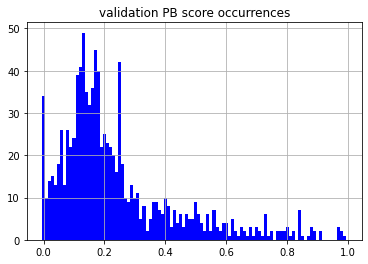

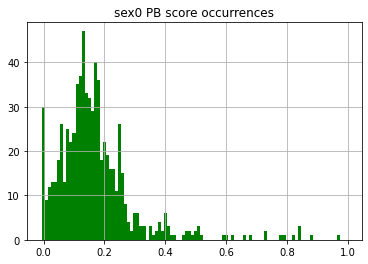

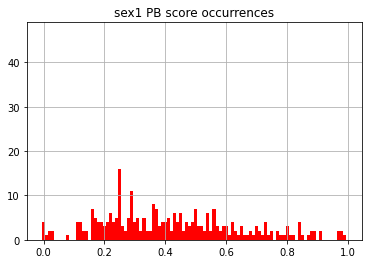

In [80]:
score_visualization(VALID_UPBS,'PB', UG=VALID_GENDER, graph_prefix="validation ")

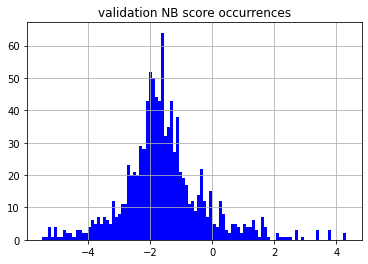

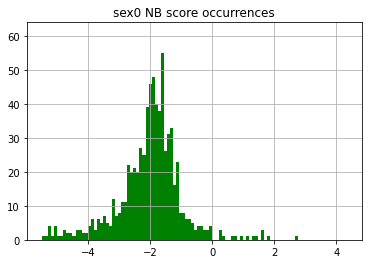

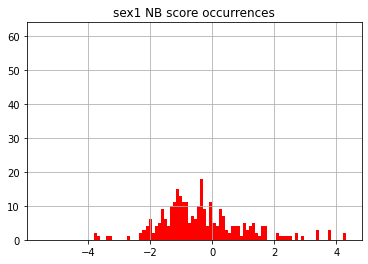

In [81]:
score_visualization(VALID_UNBS,'NB', UG=VALID_GENDER, graph_prefix="validation ")

   extractions evaluated 9000

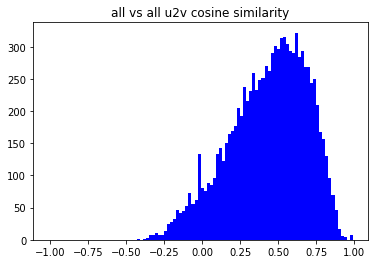

 in trial of 9992.0 :
 avg= 0.45419535628502816
 var= 0.06467247104328772
   extractions evaluated 9000

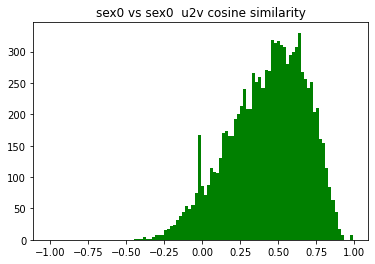

 in trial of 9996.0 :
 avg= 0.449139655862345
 var= 0.06273951591040572
   extractions evaluated 9000

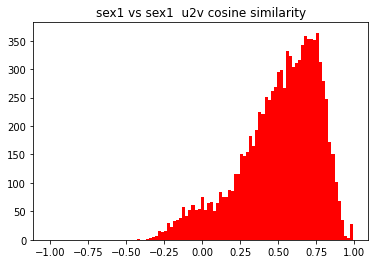

 in trial of 9994.0 :
 avg= 0.5286932159295578
 var= 0.06694135815489693
   extractions evaluated 9000

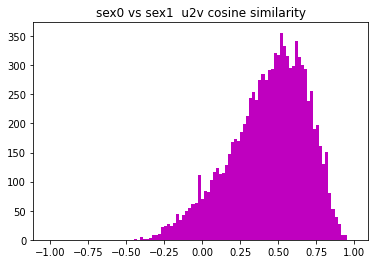

 in trial of 10000.0 :
 avg= 0.4562240000000001
 var= 0.06282422182399997


In [82]:
visualize_u2v_similarity(VALID_U2V, UG=VALID_GENDER)

  found 3  users with null u2v in sample of 1000.0 users of all gender


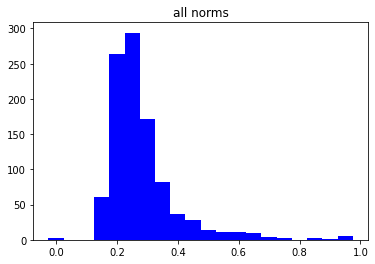

  found 3  users with null u2v in sample of 719.0 users of sex0  gender


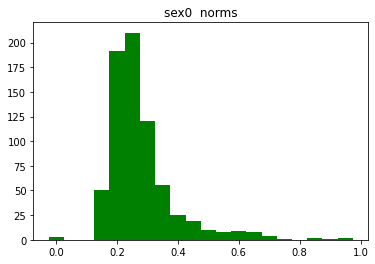

  found 0  users with null u2v in sample of 281.0 users of sex1  gender


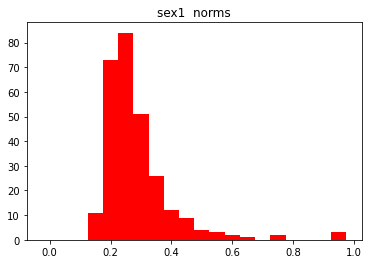

In [83]:
visualize_u2v_norms(VALID_U2V, UG=VALID_GENDER, hist_steps=20)

In [84]:
VALID_USERS_FEATS={}
# nb saranno shallow copy
for user in VALID_USERS:
    VALID_USERS_FEATS[user]={
        'UPC': np.array( list(VALID_UPC[user].values()) ),
        'UPBS': VALID_UPBS[user],
        'UDBS': VALID_UDBS[user],
        'UNBS': VALID_UNBS[user],
        'U2V':VALID_U2V[user],
        'ULSA':VALID_ULSA[user],
        'gender': VALID_GENDER[user]
        }

len(VALID_USERS_FEATS)

1000

In [85]:
def V_GUF(feats, v_users=None, v_mode='nparr'): #un modo per chiamare velocemente GUF specificando i dati di validazione
    return get_users_feat(feats, VALID_USERS_FEATS, users=v_users, mode=v_mode)

In [86]:
print(len(GUF('UPC')))
print(len(GUF('UPC')[0]))
print(len(V_GUF('UPC')))
print(len(V_GUF('UPC')[0]))
print(len(GUF('U2V')))
print(len(GUF('U2V')[0]))
print(len(V_GUF('U2V')))
print(len(V_GUF('U2V')[0]))

4000
3317
1000
3317
4000
100
1000
100


In [87]:
print(TO_LOAD_test_UPC)
print(TO_SAVE_test_UPC)

False
True


In [88]:

if TO_LOAD_test_UPC:
    TEST_UPC=np.load(PC_SL_prefix+"UPC_TEST.npy", allow_pickle=True).item()
    print("loaded",len(TEST_UPC),"test UPC")
    
else:    
    TEST_UPC=get_UPC(TEST_DATA, users_list=TEST_USERS)
    if TO_SAVE_test_UPC:
        np.save(PC_SL_prefix+"UPC_TEST.npy",TEST_UPC)
        print("saved",len(TEST_UPC),"test UPC data")
        TO_LOAD_test_UPC=True

check_subreddit_order(TEST_UPC)

     1107946 posts elaborated from data   [====================]  100.00 %  completed

saved 15000 test UPC data
  checked keys of 15000 users
  correctly ordered: True
  aligned with ref sr list: True
  number of subreddits in this upc dict: 3317


In [89]:
if LOAD_PRETRAINED_U2V['test']: 
   TEST_U2V=np.load(prefixer(w2v_params,prep_sett, U2V_SL_prefix['test'])+'.npy', allow_pickle=True).item()
   print("loaded test", len(TEST_U2V),"U2V")

else:    
    TEST_U2V=get_users_u2v(U2V_MODE, TEST_DATA, TEST_USERS, p2v_vect=P2V_VECT) 
    if SAVE_U2V['test']:
        np.save(prefixer(w2v_params,prep_sett, U2V_SL_prefix['test'])+'.npy',TEST_U2V)
        print("saved",len(TEST_U2V),"test U2V data")
        LOAD_PRETRAINED_U2V['test']=True 



  computing U2V: u2v mode is word_avg; p2v mode is sum with vers
  in line preprocessing: True
  evaluating 15000 users with 1107946 posts

     1063318 posts elaborated from data   [===================>]  95.97 %  completedpreprocessed a non-string line
     1107946 posts elaborated from data   [====================]  100.00 %  completed

saved 15000 test U2V data


In [90]:
# VALID_SPC=SPC_from_UPC(VALID_UPC, data=VALID_DATA, target=) NON DEVO CALCOLARE QUESTO
print("  elaborating test UPBS score...")
TEST_UPBS=UPBS(TEST_USERS, TRAIN_SPBS, TEST_UPC)  #<------- calcolati sulle score in training e gli upc in test
print("  elaborating test UDBS score...")
TEST_UDBS=UNBS(TEST_USERS, TRAIN_SDBS, TEST_UPC)
print("  elaborating test UNBS score...")
TEST_UNBS=UNBS(TEST_USERS, TRAIN_SNBS, TEST_UPC)

  elaborating test UPBS score...
  elaborating test UDBS score...
  elaborating test UNBS score...


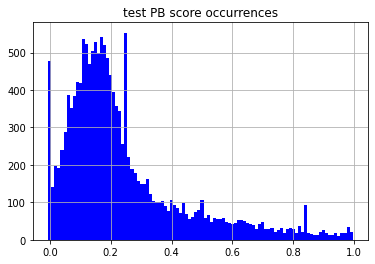

In [91]:
score_visualization(TEST_UPBS,'PB', graph_prefix="test ")

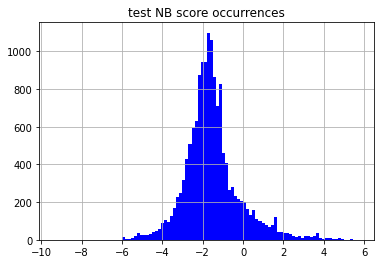

In [92]:
score_visualization(TEST_UNBS,'NB', graph_prefix="test ")

   extractions evaluated 9000

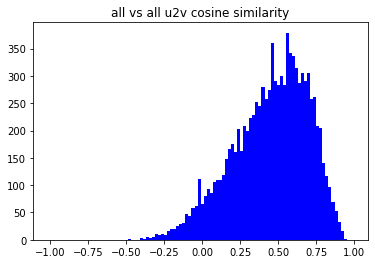

 in trial of 10000.0 :
 avg= 0.47053200000000006
 var= 0.060657716975999976


In [93]:
visualize_u2v_similarity(TEST_U2V)

  found 37  users with null u2v in sample of 15000.0 users of all gender


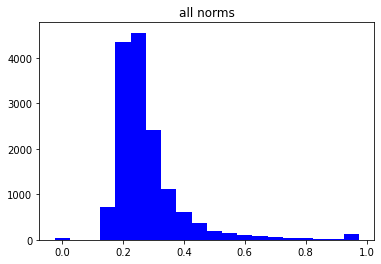

In [94]:
visualize_u2v_norms(TEST_U2V, hist_steps=20)


In [95]:
TEST_USERS_FEATS={}
# nb saranno shallow copy
for user in TEST_USERS:
    TEST_USERS_FEATS[user]={
        'UPC': np.array( list(TEST_UPC[user].values()) ),
        'UPBS': TEST_UPBS[user],
        'UDBS': TEST_UDBS[user],
        'UNBS': TEST_UNBS[user],
        'U2V': TEST_U2V[user],
        'ULSA':TEST_ULSA[user]
        # 'gender': 'unk'
        }

In [96]:
def T_GUF(feats, t_users=None, t_mode='nparr'): #un modo per chiamare velocemente GUF specificando i dati di test
    return get_users_feat(feats, TEST_USERS_FEATS, users=t_users, mode=t_mode)

len(TEST_USERS_FEATS)


15000

In [97]:
LOAD_AUPC=False 

In [98]:
SAVE_AUPC=True

In [99]:
if LOAD_AUPC:
    ALL_AUPC=np.load(SAVE_INPUT_PREFIX+"ALL_AUPC"+'.npy', allow_pickle=True).item()
    print("loaded ", len(ALL_AUPC)," users AUPC")
else:
    print(" searching subreddits...")
    subreddit_index={}
    n_tot_subreddits=all_data.subreddit.nunique()
    for n_to_index, subreddit_name in enumerate(all_data.subreddit.unique()):
        subreddit_index[subreddit_name]=n_to_index

    print(" initializing AUPC...\n")
    ALL_AUPC={}
    for user in all_data.author.unique():
        ALL_AUPC[user]=np.zeros(n_tot_subreddits)
    
    stepping=-1
    total_posts=len(all_data)
    for n,( _,row) in enumerate( all_data.iterrows() ):
        user=row.author
        subreddit=row.subreddit
        ALL_AUPC[user][ subreddit_index[subreddit] ] +=1
        stepping=perc_compl(n, total_posts, last_step=stepping, step=0.001,
                                text="     {:>6d}".format(n+1)+" posts elaborated from data  ") 
         
        

 searching subreddits...
 initializing AUPC...

     1403988 posts elaborated from data   [====================]  100.00 %  completed



In [100]:
len(ALL_AUPC)

20000

In [101]:
len(ALL_AUPC['Riddance'])

4033

In [102]:
if SAVE_AUPC:
    np.save(SAVE_INPUT_PREFIX+"ALL_AUPC"+'.npy', ALL_AUPC)
    print("Saved AUPC in file", "ALL_AUPC"+'.npy')



Saved AUPC in file ALL_AUPC.npy


In [103]:
for n, user in enumerate(TRAIN_USERS_FEATS):
    if (n+1)%100==0:
        print("\r    ", n+1," train AUPC kept in memory", end='')
    TRAIN_USERS_FEATS[user]['AUPC']=ALL_AUPC[user]

print()
print()
for n, user in enumerate(VALID_USERS_FEATS):
    if (n+1)%100==0:
        print("\r    ", n+1," valid AUPC kept in memory", end='')
    VALID_USERS_FEATS[user]['AUPC']=ALL_AUPC[user]

print()
print()
for n, user in enumerate(TEST_USERS_FEATS):
    if (n+1)%100==0:
        print("\r    ", n+1," test AUPC kept in memory", end='')
    TEST_USERS_FEATS[user]['AUPC']=ALL_AUPC[user]


     4000  train AUPC kept in memory

     1000  valid AUPC kept in memory

     15000  test AUPC kept in memory

 number of users to compute avgs and stds: 4000
 computing avgs and stds on feature columns...


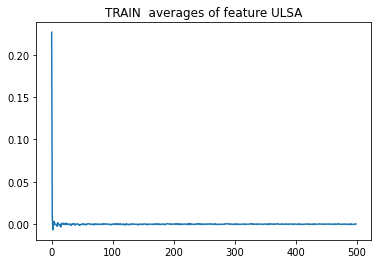

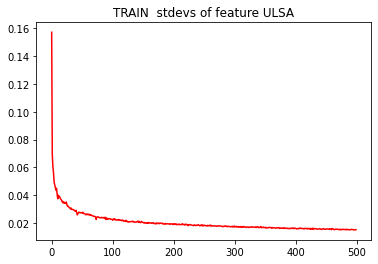

 number of users to compute avgs and stds: 1000
 computing avgs and stds on feature columns...


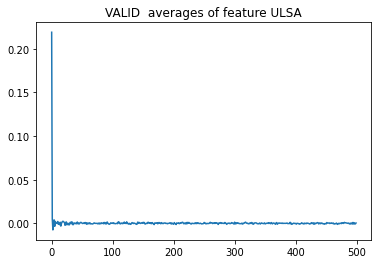

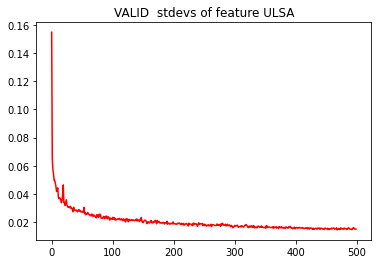

 number of users to compute avgs and stds: 15000
 computing avgs and stds on feature columns...


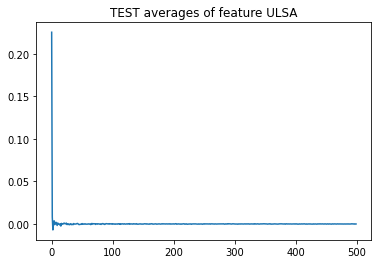

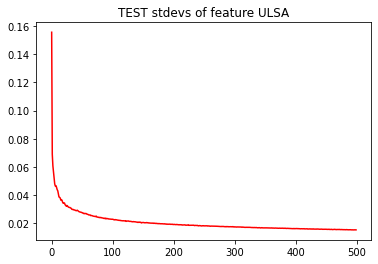

In [104]:
TVT_feat_vis('ULSA')

 number of users to compute avgs and stds: 4000
 computing avgs and stds on feature columns...


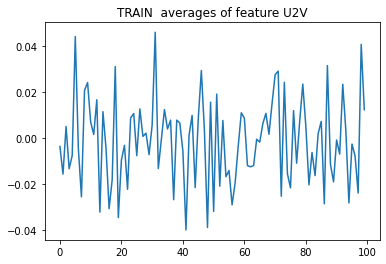

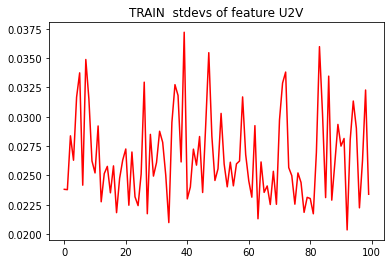

 number of users to compute avgs and stds: 1000
 computing avgs and stds on feature columns...


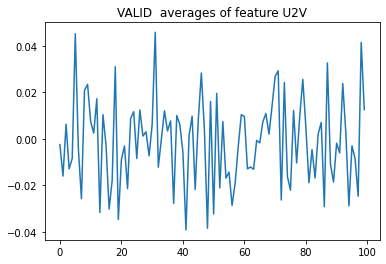

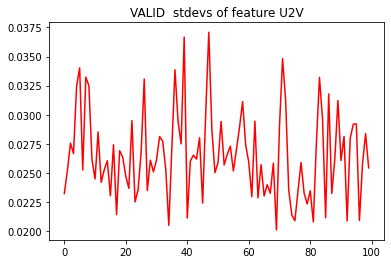

 number of users to compute avgs and stds: 15000
 computing avgs and stds on feature columns...


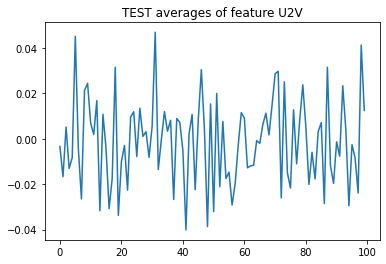

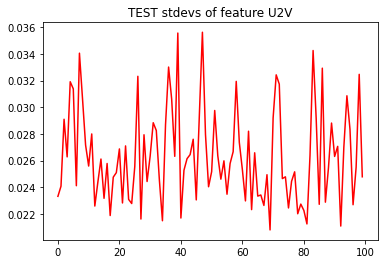

In [105]:
TVT_feat_vis('U2V')

 number of users to compute avgs and stds: 4000
 computing avgs and stds on feature columns...


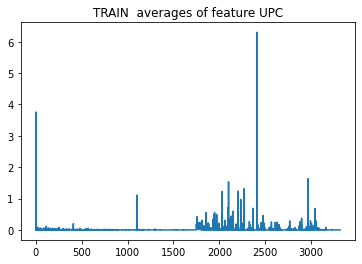

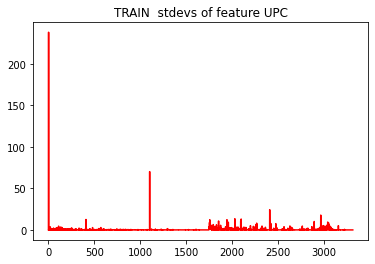

 number of users to compute avgs and stds: 1000
 computing avgs and stds on feature columns...


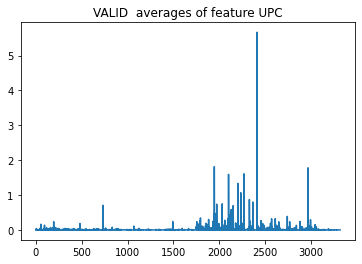

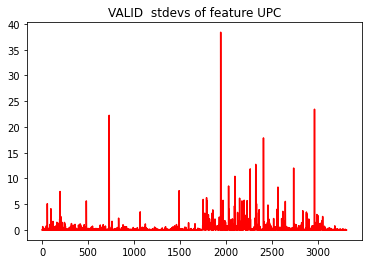

 number of users to compute avgs and stds: 15000
 computing avgs and stds on feature columns...


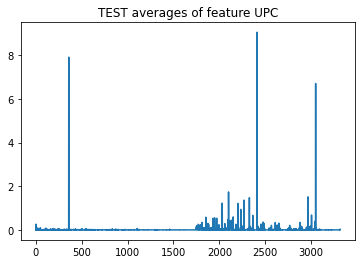

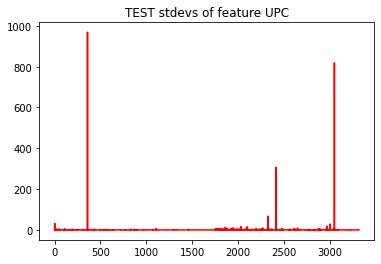

In [106]:
TVT_feat_vis('UPC')

 number of users to compute avgs and stds: 4000
 computing avgs and stds on feature columns...


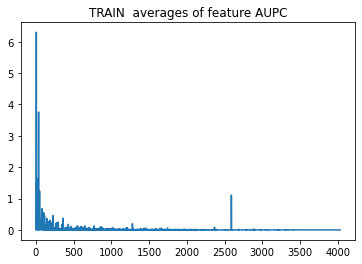

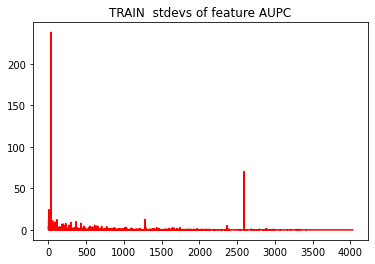

 number of users to compute avgs and stds: 1000
 computing avgs and stds on feature columns...


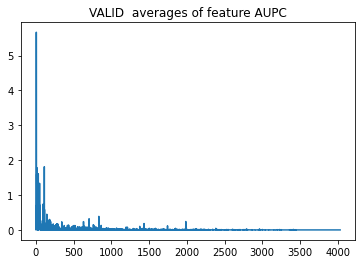

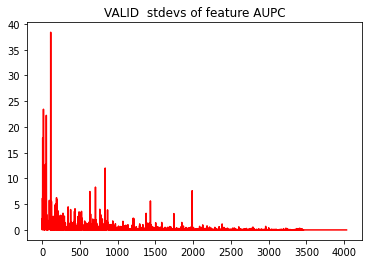

 number of users to compute avgs and stds: 15000
 computing avgs and stds on feature columns...


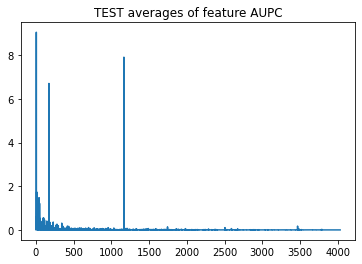

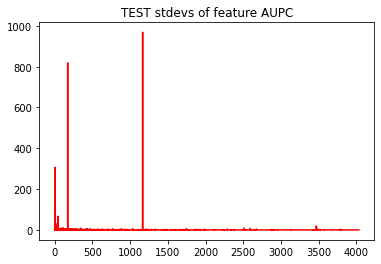

In [107]:
TVT_feat_vis('AUPC')

# TF-IDF e PCA sul conteggio di post nei subreddit

Qui lavoro alla PCA per i vettori utenti-post in subreddit. La prima parte di questo paragrafo è commentata poiché dopo aver testato entrambe le opzioni ho osservato che usare i tf-idf per pesare i subreddit invece di rinormalizzazione gaussiana sembrava più efficace nell'estrarre features dai dati. Nello specifico ho notato che a parità di componenti della pca, si catturava più varianza dopo aver fatto preprocessing con tf-idf.

Come detto in precedenza ho usato le informazioni di tutti gli utenti (sia train set che test set) per calcolare le componenti della PCA, ed ho scelto una dimensione di circa 1000 per le features da passare poi al classificatore. 

Mi è questo sembrato un buon compromesso tra "non perdere troppa varianza nei dati" e "non avere troppe componenti da rendere difficile il training, poiché ho notato che per dimensioni maggiori non riuscivo poi ad evitare l'overfitting neanche regolarizzando il modello.

In [108]:
########################################################################### BLOCCO DI RINORMALIZZAZIONE DELLE FEATURES


In [109]:

# if NORMALZE_UPC_ON_DATA == 'train':
#     TRAIN_UPC_NORMED, UPC_FC_AVGS, UPC_FC_STDS = feat_renorm(TRAIN_USERS_FEATS, 'UPC', get_parameters=True)
# else:
#     if NORMALZE_UPC_ON_DATA == 'train+valid':
#         all_user_dict={**TRAIN_USERS_FEATS, **VALID_USERS_FEATS}      
#     elif NORMALZE_UPC_ON_DATA == 'train+valid+test':
#         all_user_dict={**TRAIN_USERS_FEATS, **VALID_USERS_FEATS, **TEST_USERS_FEATS}
#     else:
#         print("  ERROR no match for call", NORMALZE_UPC_ON_DATA)
#     UPC_FC_AVGS, UPC_FC_STDS= feat_renorm(all_user_dict, 'UPC', JUST_get_parameters=True) 
#     TRAIN_UPC_NORMED= feat_renorm(TRAIN_USERS_FEATS, 'UPC', feat_col_avgs=UPC_FC_AVGS, feat_col_stds=UPC_FC_STDS)
  
# secondo me è cheaky farglielo fare su tutti i dati (per data leakeage) ma ho già i dati del test quindi si può fare (non è detto che migliori le performance)



In [110]:

# visualize_SPC(TRAIN_SPC)
# print()
# print()
# plt.plot(range(len(UPC_FC_AVGS)), UPC_FC_AVGS)
# plt.title(" avgs number of posts in subreddits by any user")
# plt.grid()
# plt.show()

In [111]:
# VALID_UPC_NORMED= feat_renorm(VALID_USERS_FEATS, 'UPC')  
# VALID_UPC_NORMED= feat_renorm(VALID_USERS_FEATS, 'UPC', feat_col_avgs=UPC_FC_AVGS, feat_col_stds=UPC_FC_STDS)  
# 
# queste per controllo       
# VALID_UPC_NORMED= feat_renorm(VALID_USERS_FEATS, 'UPC', out_type='nparr') 
# VALID_UPC_NORMED= feat_renorm(VALID_USERS_FEATS, 'UPC', out_type='nparr', feat_col_avgs=UPC_FC_AVGS, feat_col_stds=UPC_FC_STDS) 
# for column in VALID_UPC_NORMED.T:
#     print( column.mean(), column.var() )

# NB potrei usare anche il valid e test set per la rinormalizzazione ma sarebbe cheaky


In [112]:
# TEST_UPC_NORMED= feat_renorm(TEST_USERS_FEATS, 'UPC', feat_col_avgs=UPC_FC_AVGS, feat_col_stds=UPC_FC_STDS)  


In [113]:
# for user in TRAIN_USERS_FEATS:
#     TRAIN_USERS_FEATS[user]['UPC_NORMED']=TRAIN_UPC_NORMED[user]

# for user in VALID_USERS_FEATS:
#     VALID_USERS_FEATS[user]['UPC_NORMED']=VALID_UPC_NORMED[user]

# for user in TEST_USERS_FEATS:
#     TEST_USERS_FEATS[user]['UPC_NORMED']=TEST_UPC_NORMED[user]

In [114]:
########################################################################### BLOCCO DI PCA SUGLI UPC GREZZI o normalizzati

In [115]:

# #nb PCA si aspetta i dati in forma -tensoriale- di np array (get_users_feats di default ritorna un array)
# if PCA_FITS_ON_NORMALIZED_FEATS:
#     FEAT_TO_PCA='UPC_NORMED'
# else:
#     FEAT_TO_PCA='UPC'

# if PCA_ON_DATA == 'train':
#     pca_data_dict={**TRAIN_USERS_FEATS}
# elif PCA_ON_DATA == 'train+valid':
#     pca_data_dict={**TRAIN_USERS_FEATS, **VALID_USERS_FEATS}
# elif PCA_ON_DATA == 'train+valid+test':
#     pca_data_dict={**TRAIN_USERS_FEATS, **VALID_USERS_FEATS, **TEST_USERS_FEATS} 
# else:
#     print("ERROR no match for call", PCA_ON_DATA)

# PCA_DATA=get_users_feat(FEAT_TO_PCA, pca_data_dict)

# PCA_DATA.shape

In [116]:
# print("  -------== evaluating PCA ==-------- \n")
# print("  pca on data:", PCA_ON_DATA, ", sample of ", len(PCA_DATA),"users")
# print()
# print("  on normalized feats:", PCA_FITS_ON_NORMALIZED_FEATS)
# if PCA_FITS_ON_NORMALIZED_FEATS:
#      print("     ( normalization of UPC features was done on ", NORMALZE_UPC_ON_DATA,")")

# print()
# print("  with dimensionality reduction:", PCA_DIM_REDUCTION)

# PCA_EMBEDDER=PCA(n_components=PCA_DIM_REDUCTION)
# print()
# print()
# print("  fitting PCA embedder... ")
# PCA_EMBEDDER.fit(PCA_DATA)

In [117]:
# cumulative_explained_variance=np.cumsum(PCA_EMBEDDER.explained_variance_ratio_)
# plt.plot(cumulative_explained_variance)

# EXP_GIVEN_VAR=len(cumulative_explained_variance) - len(cumulative_explained_variance[cumulative_explained_variance>GIVEN_VAR])
# plt.hlines(0.9, 0, len(cumulative_explained_variance))
# plt.vlines(EXP_GIVEN_VAR, 0,1)
# plt.grid()
# print("  "+str(GIVEN_VAR*100)+"% of variance is explained by",EXP_GIVEN_VAR," components")
# plt.show()


In [118]:
# def UPCA_TRANSFORMER(users_UPC_normed, PCA_EMB=PCA_EMBEDDER, size_truncate=EXP_GIVEN_VAR): #<------- gli devo passare un array di upc (di singolo user o list of users)
#     return PCA_EMB.transform(users_UPC_normed)[:,:size_truncate]

In [119]:
# GUF('U2V', t_users='Riddance').shape
# TRAIN_USERS_FEATS['Riddance']['UPC_NORMED'].shape

In [120]:
# for n, user in enumerate(TRAIN_USERS_FEATS):
#     if (n+1)%100==0:
#         print("\r    ", n+1," train UPC transformed", end='')
#     TRAIN_USERS_FEATS[user]['UPCA']=UPCA_TRANSFORMER(GUF(FEAT_TO_PCA, t_users=user))[0] #<----- nb [0] giusto per averlo in forma array come le altre feats

# print()
# print()
# for n, user in enumerate(VALID_USERS_FEATS):
#     if (n+1)%100==0:
#         print("\r    ", n+1," valid UPC transformed", end='')
#     VALID_USERS_FEATS[user]['UPCA']=UPCA_TRANSFORMER(V_GUF(FEAT_TO_PCA, v_users=user))[0]


In [121]:
# TRAIN_USERS_FEATS['Riddance'].keys()
# len(VALID_USERS_FEATS)

# GUF('UPCA')[:,:200].shape

In [122]:
######################################################################################################################################## BLOCCO DI PCA SUGLI UPC TFIDF

In [123]:
if TFIDF_ON_DATA == 'train':
    tfidf_data_dict={**TRAIN_USERS_FEATS}
elif TFIDF_ON_DATA == 'train+valid':
    tfidf_data_dict={**TRAIN_USERS_FEATS, **VALID_USERS_FEATS}
elif TFIDF_ON_DATA == 'train+valid+test':
    tfidf_data_dict={**TRAIN_USERS_FEATS, **VALID_USERS_FEATS, **TEST_USERS_FEATS}
else:
    print("  ERROR no match for call", TFIDF_ON_DATA)

TFIDF_DATA=get_users_feat(FEAT_TO_TFIDF, tfidf_data_dict) 

In [124]:
print("  -------== evaluating TF-IDF ==-------- \n")
print("  tf-idf on data:", TFIDF_ON_DATA, ", sample of", len(TFIDF_DATA),"users")
print("  evaluating feature:", FEAT_TO_TFIDF)

tfidf_M=TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True) #<----- nb default sono norm='l2', use_idf=True, smooth_idf=True
print()
print()
print("  fitting tf-idf transformer...")
tfidf_M.fit(TFIDF_DATA)

  -------== evaluating TF-IDF ==-------- 

  tf-idf on data: train+valid+test , sample of 20000 users
  evaluating feature: AUPC


  fitting tf-idf transformer...


TfidfTransformer()

In [125]:
def TFIDF_TRANSFORMER(users_UPC, TFIDF_MODEL=tfidf_M): #<------- gli devo passare un array di upc (di singolo user o list of users)
    return TFIDF_MODEL.transform(users_UPC)

In [126]:
# TFIDF_TRANSFORMER(GUF('UPC', t_users='Riddance')).toarray()[0].shape
for n, user in enumerate(TRAIN_USERS_FEATS):
    if (n+1)%100==0:
        print("\r    ", n+1," train",FEAT_TO_TFIDF,"transformed with tfidf", end='')
    TRAIN_USERS_FEATS[user][FEAT_TO_TFIDF+'_TFIDF']=TFIDF_TRANSFORMER(GUF(FEAT_TO_TFIDF, t_users=user)).toarray()[0] #<----- nb [0] giusto per averlo in forma array come le altre feats

print()
print()
for n, user in enumerate(VALID_USERS_FEATS):
    if (n+1)%100==0:
        print("\r    ", n+1," valid",FEAT_TO_TFIDF,"transformed with tfidf", end='')
    VALID_USERS_FEATS[user][FEAT_TO_TFIDF+'_TFIDF']=TFIDF_TRANSFORMER(V_GUF(FEAT_TO_TFIDF, v_users=user)).toarray()[0]

print()
print()
for n, user in enumerate(TEST_USERS_FEATS):
    if (n+1)%100==0:
        print("\r    ", n+1," test",FEAT_TO_TFIDF,"transformed with tfidf", end='')
    TEST_USERS_FEATS[user][FEAT_TO_TFIDF+'_TFIDF']=TFIDF_TRANSFORMER(T_GUF(FEAT_TO_TFIDF, t_users=user)).toarray()[0]    

     4000  train AUPC transformed with tfidf

     1000  valid AUPC transformed with tfidf

     15000  test AUPC transformed with tfidf

In [127]:
TRAIN_USERS_FEATS['Riddance'][FEAT_TO_TFIDF+'_TFIDF'].shape

(4033,)

 number of users to compute avgs and stds: 4000
 computing avgs and stds on feature columns...


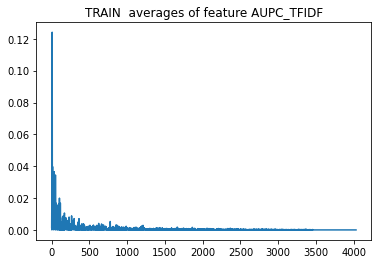

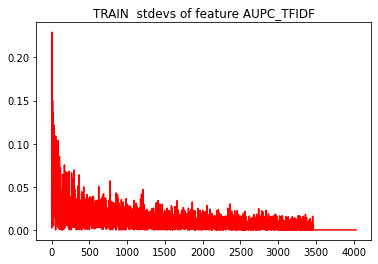

 number of users to compute avgs and stds: 1000
 computing avgs and stds on feature columns...


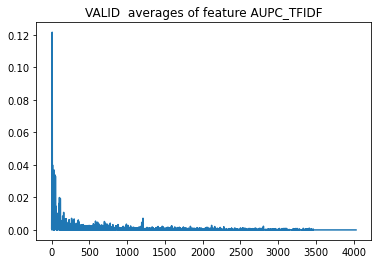

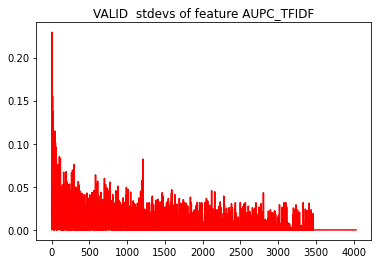

 number of users to compute avgs and stds: 15000
 computing avgs and stds on feature columns...


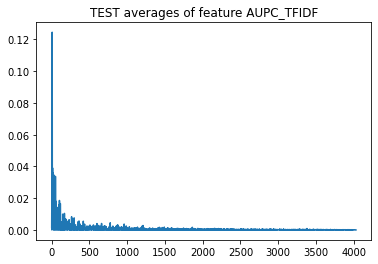

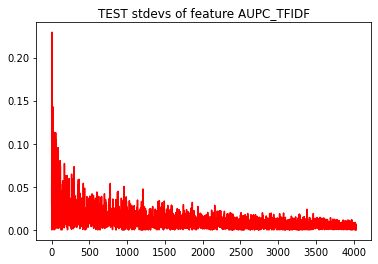

In [128]:

TVT_feat_vis(FEAT_TO_TFIDF+'_TFIDF')

In [129]:
# ---------------------------------------------------------------------------------------------- blocco di pca su questi tfidf

In [130]:
if PCA_TFIDF_ON_DATA == 'train':
    pcatfidf_data_dict={**TRAIN_USERS_FEATS}
elif PCA_TFIDF_ON_DATA == 'train+valid':
    pcatfidf_data_dict={**TRAIN_USERS_FEATS, **VALID_USERS_FEATS}
elif PCA_TFIDF_ON_DATA == 'train+valid+test':
    pcatfidf_data_dict={**TRAIN_USERS_FEATS, **VALID_USERS_FEATS, **TEST_USERS_FEATS}
else:
    print("  ERROR no match for call", PCA_TFIDF_ON_DATA)

PCA_TFIDF_DATA=get_users_feat(FEAT_TO_PCA_TFIDF, pcatfidf_data_dict)

In [131]:
PCA_TFIDF_DIM_REDUCTION=1000

In [132]:
print("  -------== evaluating PCA on TF-IDF ==-------- \n")
print("   transforming feature:", FEAT_TO_PCA_TFIDF )
print()
print("   pca on data:", PCA_TFIDF_ON_DATA, ", sample of", len(PCA_TFIDF_DATA),"users")
print()
print("   predefined dim reduction:", PCA_TFIDF_DIM_REDUCTION)
PCA_TFIDF_EMBEDDER=PCA(n_components=PCA_TFIDF_DIM_REDUCTION)
print()
print()
print("   fitting PCA transformation on", PCA_TFIDF_ON_DATA)
PCA_TFIDF_EMBEDDER.fit(PCA_TFIDF_DATA)


  -------== evaluating PCA on TF-IDF ==-------- 

   transforming feature: AUPC_TFIDF

   pca on data: train+valid+test , sample of 20000 users

   predefined dim reduction: 1000


   fitting PCA transformation on train+valid+test


PCA(n_components=1000)

In [133]:
GIVEN_VAR_PCATFIDF=0.9

  83.80% of variance is explained by 1000  components


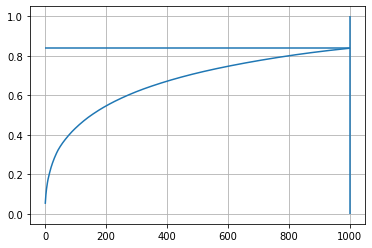

In [134]:

cumulative_explained_variance=np.cumsum(PCA_TFIDF_EMBEDDER.explained_variance_ratio_)
plt.plot(cumulative_explained_variance)

EXP_GIVEN_VAR_TFIDF=len(cumulative_explained_variance) - len(cumulative_explained_variance[cumulative_explained_variance>GIVEN_VAR_PCATFIDF])
if EXP_GIVEN_VAR_TFIDF==len(cumulative_explained_variance):
    GIVEN_VAR_PCATFIDF=max(cumulative_explained_variance)
plt.hlines(GIVEN_VAR_PCATFIDF, 0, len(cumulative_explained_variance))
plt.vlines(EXP_GIVEN_VAR_TFIDF, 0,1)
plt.grid()
print("  "+"{:5.2f}".format(GIVEN_VAR_PCATFIDF*100)+"% of variance is explained by",EXP_GIVEN_VAR_TFIDF," components")
plt.show()

In [135]:
def UPCA_TFIDF_TRANSFORMER(users_UPC_TFIDF, PCA_TFIDF_EMB=PCA_TFIDF_EMBEDDER, size_truncate=EXP_GIVEN_VAR_TFIDF): #<------- gli devo passare un array di upc tfidf
    return PCA_TFIDF_EMB.transform(users_UPC_TFIDF)[:,:size_truncate]


In [136]:
# UPCA_TFIDF_TRANSFORMER(GUF(FEAT_TO_PCA_TFIDF, t_users='Riddance'))[0].shape

In [137]:
for n, user in enumerate(TRAIN_USERS_FEATS):
    if (n+1)%100==0:
        print("\r    ", n+1," train",FEAT_TO_PCA_TFIDF,"transformed with PCA on",FEAT_TO_PCA_TFIDF, end='')
    TRAIN_USERS_FEATS[user]['AUPCA_TFIDF']=UPCA_TFIDF_TRANSFORMER(  GUF(FEAT_TO_PCA_TFIDF, t_users=user)  )[0] #<----- nb [0] giusto per averlo in forma array come le altre feats

print()
print()
for n, user in enumerate(VALID_USERS_FEATS):
    if (n+1)%100==0:
        print("\r    ", n+1," train",FEAT_TO_PCA_TFIDF,"transformed with PCA on",FEAT_TO_PCA_TFIDF, end='')
    VALID_USERS_FEATS[user]['AUPCA_TFIDF']=UPCA_TFIDF_TRANSFORMER(  V_GUF(FEAT_TO_PCA_TFIDF, v_users=user)  )[0]

print()
print()
for n, user in enumerate(TEST_USERS_FEATS):
    if (n+1)%100==0:
        print("\r    ", n+1," test",FEAT_TO_PCA_TFIDF,"transformed with PCA on",FEAT_TO_PCA_TFIDF, end='')
    TEST_USERS_FEATS[user]['AUPCA_TFIDF']=UPCA_TFIDF_TRANSFORMER(  T_GUF(FEAT_TO_PCA_TFIDF, t_users=user)  )[0]


     4000  train AUPC_TFIDF transformed with PCA on AUPC_TFIDF

     1000  train AUPC_TFIDF transformed with PCA on AUPC_TFIDF

     15000  test AUPC_TFIDF transformed with PCA on AUPC_TFIDF

In [138]:
len(TRAIN_USERS_FEATS['Riddance']['AUPCA_TFIDF'])

1000

In [139]:
for user in TRAIN_USERS_FEATS:
    print("features kept in memory for training set:", TRAIN_USERS_FEATS[user].keys() )
    break

for user in VALID_USERS_FEATS:
    print("features kept in memory for validation set:", VALID_USERS_FEATS[user].keys() )
    break

for user in TEST_USERS_FEATS:
    print("features kept in memory for training set:", TEST_USERS_FEATS[user].keys() )
    break

features kept in memory for training set: dict_keys(['UPC', 'UPBS', 'UDBS', 'UNBS', 'U2V', 'ULSA', 'gender', 'AUPC', 'AUPC_TFIDF', 'AUPCA_TFIDF'])
features kept in memory for validation set: dict_keys(['UPC', 'UPBS', 'UDBS', 'UNBS', 'U2V', 'ULSA', 'gender', 'AUPC', 'AUPC_TFIDF', 'AUPCA_TFIDF'])
features kept in memory for training set: dict_keys(['UPC', 'UPBS', 'UDBS', 'UNBS', 'U2V', 'ULSA', 'AUPC', 'AUPC_TFIDF', 'AUPCA_TFIDF'])


 number of users to compute avgs and stds: 4000
 computing avgs and stds on feature columns...


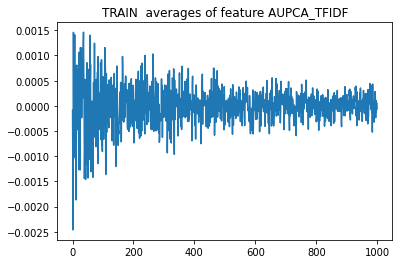

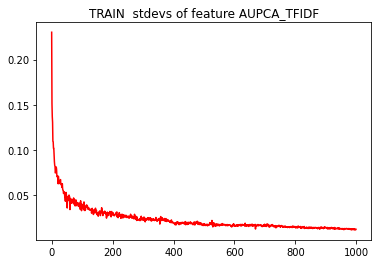

 number of users to compute avgs and stds: 1000
 computing avgs and stds on feature columns...


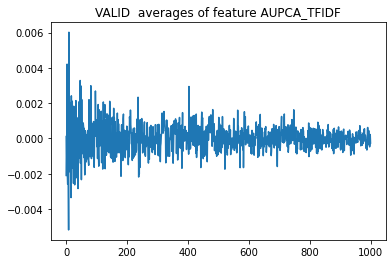

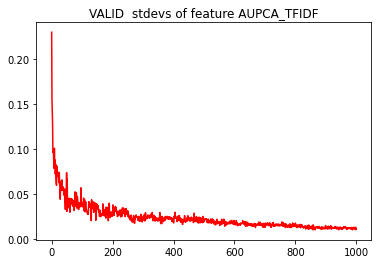

 number of users to compute avgs and stds: 15000
 computing avgs and stds on feature columns...


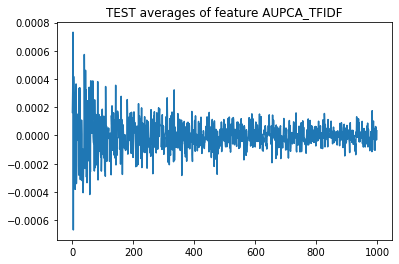

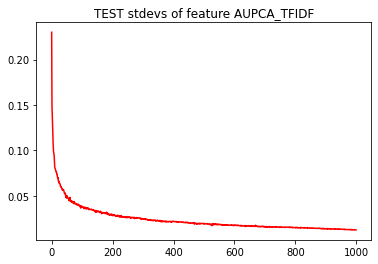

In [140]:
TVT_feat_vis('AUPCA_TFIDF')

# Training e Validazione dei modelli

Qui inizia la parte di training. Il dataset dotato di label era stato diviso fin dall'inizio in training set (4000), validation set(1000), per cui ho potuto per ogni modello valutare sia la cross validation sul training set che una validazione sul validation set. 

Nel caso dei modelli di score non ho potuto usare la cross validation, poiché i punteggi attribuiti ai subreddit erano calcolati sui dati del solo training set: sarebbe stato più laborioso che utile implementare cross validation anche per questi modelli poiché essendo modelli semplici mi aspettavo in ogni caso un bias sinificativo.
Sugli altri tre modelli ho invece lavorato testando diverse dimensioni dell'hidden layer -quando presente-, ottimizzatori SGD e ADAM (provando vari parametri per il learning rate e momento di SGD) e quando necessario aggiungendo e testando combinazioni di regolarizzatori L1 ed L2.

In particolare per il modello di PCA sui subreddit ho aggiunto una regolarizzazione L1 per cercare di fare un'ulteriore feature selection, e regolarizzazione L2 per evitare valori in output troppo "netti" e rendere difficile il training. Dal momento che risultava ciononostante piuttosto difficile da allenare ho implementato una ricerca a griglia sui diversi iperparametri del modello, per poi valutare in quale range avessi buoni risultati (questa parte non sarà attiva nell'istanza che consegnerò per l'esame perché molto intensiva per il programma)

Le valutazioni di quali iperparametri fossero buoni sono state fatte solamente "ad occhio", valutando innanzitutto l'errore medio (e varianza) nella cross validation, la distanza tra la curva della loss sul test set e valid set, oltre che le fluttuazioni della curva (ad evitare di avere learning rate troppo alto). Ho anche provato diversi learning rate decay ma avendo sempre una quantità di momento nel gradiente non ho osservato differenze utili nelle curve di learning. 

Le metriche usate sono state la binary crossentropy (come loss), accuratezza binaria e roc auc. Essendo alla fine il risultato valutato sulla roc auc mi sono preoccupato soprattutto di ottimizzare quest'ultima, fintantoché il modello non mostrava comportamenti patologici nella loss function


Un'aggiunta utile per ottimizzare il risultato finale sarebbe stata automatizzare il processo di ricerca dei migliori iperparametri, ma ho trovato didatticamente più utile prendere tutto questo come semplicemente un esercizio e lavorare osservando direttamente le caratteristiche di tutte le curve delle diverse metriche. 

In ultimo, ho trovato utile oltre che interessante andare a valutare le possibilità di un modello (in particolare di quelli regolarizzati) visualizzando i parametri interni dei modelli.

In [141]:
############################################################# MODEL TRAINING PREPARATION

In [142]:

def train_model(data, target, model, mode='SKlin'):
    if mode is 'SKlin':
        model.fit(data,target)
    elif mode is 'tf':
        model.fit(data, target)
    return model
    
def evaluate_model(data, target, model, mode='SKlin'):
    if mode is 'SKlin':
        predictions=model.predict(data)
    elif mode is 'tf':
        # predictions=model.predict_classes(data)
        predictions=np.array([el[0] for el in (model.predict(data) > 0.5).astype("int32")])
    # print(predictions[:10])
    score=np.array([predictions == target])
    # print(target[:10])
    # print(score[:10])
    # print(len(score))
    # print(score.sum())
    return score.sum()/len(target)

from sklearn.metrics import roc_auc_score

def evaluate_rocauc(data, target, model, mode='SKlin', predict='class'):
    if mode is 'SKlin':
        predictions=model.predict(data)
    elif mode is 'tf':
        # predictions=model.predict_classes(data)
        if predict is 'class':
            predictions=(model.predict(data) > 0.5).astype("int32")
        elif predict is 'proba':
            predictions=model.predict(data)
    return roc_auc_score(target, predictions)

def compare_results(results1, results2, in_type='nparr', predict='class', prefix=""):
    
    
    tot_res=len(results1)
    if len(results2) != tot_res:
        print("lenght of array does not match")
        return
    if predict is 'class':
        count_differences=0
        confusion_matrix=[[0,0],[0,0]]
        for res1,res2 in zip(results1, results2):
            confusion_matrix[res1][res2]+=1
            if res1!=res2:
                count_differences+=1

        print(prefix, "total differences:", count_differences,"  ( {:4.2f}% )".format(count_differences/tot_res*100))
        print(prefix, "confusion matrix:\n ")
        print("      "+"{:^15}".format("mod2:0")+"{:^15}".format("mod2:1") )
        print("mod1:0"+"{:^15.0f}".format(confusion_matrix[0][0])+"{:^15.0f}".format(confusion_matrix[0][1]))
        print("mod1:1"+"{:^15.0f}".format(confusion_matrix[1][0])+"{:^15.0f}".format(confusion_matrix[1][1]))
# NB SE CHIAMATA CON I TARGET, RESULTS1 DEVE ESSERE I TARGET 
    print("\n\n"+prefix+" "+predict+" roc_auc score:", roc_auc_score(results1,results2))

def model_results(model, T_data, T_target, V_data, V_target, mode='SKlin', predict='class'):
    if type(T_data) is dict:
        T_data=dictoarr(T_data)
        if type(T_data[0]) is list or type(T_data[0]) is numpy.ndarray:
            T_data=T_data.reshape(-1,len(T_data[0]))
        else:
            T_data=T_data.reshape(-1,1)
    if type(V_data) is dict:
        V_data=dictoarr(V_data)
        if type(V_data[0]) is list or type(V_data[0]) is numpy.ndarray:
            V_data=V_data.reshape(-1,len(V_data[0]))
        else:
            V_data=V_data.reshape(-1,1)
    if type(T_target) is dict:
        T_target=dictoarr(T_target)
    if type(V_target) is dict:
        V_target=dictoarr(V_target)

    print(" train set of size", len(T_target))
    print(" valid set of size", len(V_target))
    # print()
    # print("    evaluating binary accuracy... ")
    IS_acc=evaluate_model(T_data,T_target, model, mode=mode)
    OS_acc=evaluate_model(V_data,V_target, model, mode=mode)
    # print()
    # print("    evaluating roc auc... ")
    IS_auc=evaluate_rocauc(T_data,T_target, model, mode=mode, predict=predict)
    OS_auc=evaluate_rocauc(V_data,V_target, model, mode=mode, predict=predict)
    print()
    print()
    print(" in sample binary accuracy:", IS_acc)
    print("out sample binary accuracy:", OS_acc)
    print()
    print()
    print(" predictions in form :", predict)
    print(" in sample",predict,"roc_auc:", IS_auc)
    print("out sample",predict,"roc_auc:", OS_auc)
    print()

    if mode is 'SKlin':
        IS_predictions=model.predict(T_data)
        OS_predictions=model.predict(V_data)
    elif mode is 'tf':
        # IS_predictions=model.predict_classes(T_data)
        # OS_predictions=model.predict_classes(V_data)
        if predict is 'class':
            IS_predictions=np.array([el[0] for el in (model.predict(T_data) > 0.5).astype("int")])
            OS_predictions=np.array([el[0] for el in (model.predict(V_data) > 0.5).astype("int")])
        elif predict is 'proba':
            IS_predictions=model.predict(T_data)
            OS_predictions=model.predict(V_data)
    # print(IS_predictions)
    # print(OS_predictions)
    if 'class' in predict:
        print()
        print(" in sample results comparison:---------------------------------------------\n")
        compare_results(T_target, IS_predictions, predict=predict, prefix=" IN SAMPLE")
        # NB IL PRIMO PARAMETRO DEVE ESSERE I TARGET PER POTER ESSERE PASSATO A ROC_AUC_SCORE
        print()
        print("out sample results comparison:---------------------------------------------\n")
        compare_results(V_target, OS_predictions, predict=predict, prefix="OUT SAMPLE")





In [143]:
def tv_shuffle(train_data, valid_data, train_target, valid_target):
    TV_data=np.concatenate((train_data,valid_data))
    TV_target=np.concatenate((train_target, valid_target))
    
    valid_size=len(valid_target)
    tv_size=len(TV_data)
    
    extracted=[]
    T_data=[]
    V_data=[]
    T_target=[]
    V_target=[]
    
    while( len(extracted) < valid_size):
        rnd_ext=np.random.randint(tv_size)
        if rnd_ext<0 or rnd_ext>=tv_size:
            print("error")
            return

        if rnd_ext not in extracted:
            extracted.append(rnd_ext)
            V_data.append(TV_data[rnd_ext])
            V_target.append(TV_target[rnd_ext])

    for i in range(tv_size):
        if i not in extracted:
            T_data.append(TV_data[i])
            T_target.append(TV_target[i])

    T_data=np.array(T_data).reshape(-1,len(T_data[0])) #<---- questo len( ... [0]) dà errore se sto shufflando una score (non ha lunghezza)
    V_data=np.array(V_data).reshape(-1,len(V_data[0])) #<---- E IO NON DEVO SHUFFLARE SUGLI SCORE quindi ok

    T_target=np.array(T_target)
    V_target=np.array(V_target)

    # print(T_data.shape)
    # print(V_data.shape)
    # print(T_target.shape)
    # print(V_target.shape)
    # print(extracted)
    return T_data, V_data, T_target, V_target

In [144]:

############################ CROSS VALIDATION

def cross_validation(data, target, model_initializing_function, N_folds=10, mode='tf', N_epochs=10, display=2, show_plots=True):

    my_model=model_initializing_function()
    if 'tf' in mode:
        my_model.summary()

    # if 'score' in mode:

#---------------------- PREPARING FOLDS FOR CROSS VALIDATION WITH TRAIN DATA
    N_folds=N_folds
    # CV_DATA=[u2v[user][0] for user in u2v]
    # CV_TARGET=[u2v[user][1] for user in u2v]
    CV_DATA=data
    CV_TARGET=target


    size_fold=int(len(CV_DATA)/N_folds)
    print(" cross validation with", N_folds,"folds of size",size_fold)
    print("\n\n")
    # CV_FOLD_USERS=[]
    CV_FOLD_DATA=[]
    CV_FOLD_TARGET=[]
    for n in range(N_folds):
        CV_FOLD_DATA.append(CV_DATA[n*size_fold:(n+1)*size_fold])
        CV_FOLD_TARGET.append(CV_TARGET[n*size_fold:(n+1)*size_fold])

    Acc_in=[]
    Auc_in=[]
    proba_Auc_in=[]
    class_Auc_in=[]
    
    Acc_out=[]
    Auc_out=[]
    proba_Auc_out=[]
    class_Auc_out=[]

    for n in range(N_folds):
        print("#################################################################  fold ",n,":")
        CV_TRAIN_DATA=[]
        CV_TRAIN_TARGET=[]
        CV_TEST_DATA=[]
        CV_TEST_TARGET=[]
        for m in range(N_folds):        
            if m==n:
                print("---------------Test fold:",m, end='\n')
                for j in range(size_fold):
                    CV_TEST_DATA.append(CV_FOLD_DATA[m][j])
                    CV_TEST_TARGET.append(CV_FOLD_TARGET[m][j])
                continue
            print("Train fold:",m, end=',')      
            for j in range(size_fold):
                CV_TRAIN_DATA.append(CV_FOLD_DATA[m][j])
                CV_TRAIN_TARGET.append(CV_FOLD_TARGET[m][j])
            
#         print()
#         print()
                
#         print(len(CV_TRAIN_DATA))
#         print(len(CV_TRAIN_TARGET))
#         print(type(CV_TRAIN_DATA[0]))
#         print(type(CV_TRAIN_TARGET[0]))

        CV_TRAIN_DATA=np.array(CV_TRAIN_DATA)
        CV_TRAIN_TARGET=np.array(CV_TRAIN_TARGET)
        CV_TEST_DATA=np.array(CV_TEST_DATA)
        CV_TEST_TARGET=np.array(CV_TEST_TARGET)
        if len(CV_TRAIN_DATA)!=len(CV_TRAIN_TARGET):
            print("error in shape of input vs output")
            return
        print()
        
        del my_model
        
        if 'skl' in mode:
            print("inizializing model")        
    #         my_model=LogisticRegression(solver='lbfgs')
            my_model=model_initializing_function()
            print("training model with sample of size", len(CV_TRAIN_DATA)) 
            my_model=train_model(CV_TRAIN_DATA,CV_TRAIN_TARGET,my_model)
            print("evaluating IN SAMPLE ACCURACY")
            in_sample_error=evaluate_model(CV_TRAIN_DATA,CV_TRAIN_TARGET,my_model)
            Acc_in.append(in_sample_error)  #dovrei cambiargli il nome da errore ad accuracy
            print("evaluating OUT SAMPLE ACCURACY")
            out_sample_error=evaluate_model(CV_TEST_DATA,CV_TEST_TARGET,my_model)
            Acc_out.append(out_sample_error)
            print("evaluating IN_SAMPLE ROC AUC")
            in_sample_rocauc=evaluate_rocauc(CV_TRAIN_DATA, CV_TRAIN_TARGET, my_model)
            Auc_in.append(in_sample_rocauc)
            print("evaluating IN_SAMPLE ROC AUC")
            out_sample_rocauc=evaluate_rocauc(CV_TEST_DATA, CV_TEST_TARGET, my_model)
            Auc_out.append(out_sample_rocauc)
            print("################################################# \n fold",n,") results:\n Accuracy in=",in_sample_error,"; Accuracy out=",out_sample_error,"; \n ROC_AUC IN:", in_sample_rocauc,", ROC_AUC OUT", out_sample_rocauc)
            print("\n\n\n\n")
            
        elif 'tf' in mode:
            print("initializing model")
            my_model=model_initializing_function()
            print("training model with sample of size", len(CV_TRAIN_DATA),"for",N_epochs," epochs") 
            history=my_model.fit(CV_TRAIN_DATA,
                           CV_TRAIN_TARGET,
                           validation_data=(CV_TEST_DATA,CV_TEST_TARGET),
                           epochs=N_epochs,
                           verbose=display
                          ).history
            if show_plots:
                train_loss=history['loss']
                train_score=history['binary_accuracy']
                train_rocauc=history['roc_auc']

                valid_loss=history['val_loss']
                valid_score=history['val_binary_accuracy']
                valid_rocauc=history['val_roc_auc']

                plt.title("T(b) V(r) loss")
                plt.plot(range(len(train_loss)),train_loss)
                plt.plot(range(len(valid_loss)),valid_loss, color='r')
                plt.grid()
                plt.show()
                plt.title("T(b) V(r) binary accuracy")
                plt.plot(range(len(train_score)),train_score)
                plt.plot(range(len(valid_score)),valid_score, color='r')
                plt.grid()
                plt.show()
                plt.title("T(b) V(r) probability roc auc")
                plt.plot(range(len(train_rocauc)),train_rocauc)
                plt.plot(range(len(valid_rocauc)),valid_rocauc, color='r')
                plt.grid()
                plt.show()
                   
            print("evaluating IN SAMPLE METRICS")
            in_sample_loss ,in_sample_error, in_sample_rocauc=my_model.evaluate(CV_TRAIN_DATA,CV_TRAIN_TARGET, verbose=0)
            in_sample_class_rocauc=evaluate_rocauc(CV_TRAIN_DATA, CV_TRAIN_TARGET, my_model, mode='tf', predict='class')

            Acc_in.append(in_sample_error)
            proba_Auc_in.append(in_sample_rocauc)
            class_Auc_in.append(in_sample_class_rocauc)

            Auc_in.append(in_sample_rocauc)   #<----- per la valutazione finale uso la versione continua di rocauc

            print("evaluating OUT SAMPLE METRICS")
            out_sample_loss ,out_sample_error, out_sample_rocauc=my_model.evaluate(CV_TEST_DATA,CV_TEST_TARGET, verbose=0)
            out_sample_class_rocauc=evaluate_rocauc(CV_TEST_DATA, CV_TEST_TARGET, my_model, mode='tf', predict='class')

            Acc_out.append(out_sample_error)
            proba_Auc_out.append(out_sample_rocauc)
            class_Auc_out.append(out_sample_class_rocauc)

            Auc_out.append(out_sample_rocauc)     #<----- per la valutazione finale uso la versione continua di rocauc

            print("#################################################")
            print(" fold",n,") results:")
            print(" Accuracy in=",in_sample_error,"; Accuracy out=",out_sample_error)
            print(" class ROC_AUC_IN:", in_sample_class_rocauc,"; class ROC_AUC OUT:", out_sample_class_rocauc)
            print(" proba ROC_AUC IN:", in_sample_rocauc,"; proba ROC_AUC OUT:", out_sample_rocauc)            
            print("\n\n")
            

    print("CV results")
    Acc_in=np.array(Acc_in)
    Acc_out=np.array(Acc_out)
    avg_Acc_in=Acc_in.mean()
    avg_Acc_out=Acc_out.mean()
    std_Acc_in=Acc_in.std()
    std_Acc_out=Acc_out.std()

    Auc_in=np.array(Auc_in)
    Auc_out=np.array(Auc_out)
    avg_Auc_in=Auc_in.mean()
    avg_Auc_out=Auc_out.mean()
    std_Auc_in=Auc_in.std()
    std_Auc_out=Auc_out.std()

    if 'tf' in mode:
        class_Auc_in=np.array(class_Auc_in)
        class_Auc_out=np.array(class_Auc_out)
        avg_class_Auc_in=class_Auc_in.mean()
        avg_class_Auc_out=class_Auc_out.mean()
        std_class_Auc_in=class_Auc_in.std()
        std_class_Auc_out=class_Auc_out.std()

    print()
    print(" In Sample Accuracy:   mean", avg_Acc_in, " stdev", std_Acc_in)
    print("Out Sample Accuracy:   mean", avg_Acc_out," stdev", std_Acc_out)

    print()
    print(" In Sample class ROC_AUC :   mean", avg_class_Auc_in, " stdev", std_class_Auc_in)
    print("Out Sample class ROC_AUC :   mean", avg_class_Auc_out," stdev", std_class_Auc_out)
    
    # print()
    # print(" In Sample probability ROC_AUC :   mean", avg_proba_Auc_in, " stdev", std_proba_Auc_in)
    # print("Out Sample probability ROC_AUC :   mean", avg_proba_Auc_out," stdev", std_proba_Auc_out)

    print()
    if 'tf' in mode:
        print(" ------------- final results ------------------------------------------------")
        print()
        print(" In Sample probability ROC_AUC :   mean", avg_Auc_in, " stdev", std_Auc_in)
        print("Out Sample probability ROC_AUC :   mean", avg_Auc_out," stdev", std_Auc_out)


    return avg_Auc_in, avg_Auc_out


In [145]:
def TV_validation(model_init_function, train_data, valid_data,     #NB implementata per funzionare con tensorflow
                    train_target=GUF('gender'), valid_target=V_GUF('gender'), tv_epochs=100, display='all', 
                    mode='tf', predict='proba', get=False, shuffle=False, validation=True):
    
    if mode is not 'tf':
        print(" non l'ho implementata")
        return

    if shuffle:
        T_data, V_data, T_target, V_target= tv_shuffle(train_data, valid_data, train_target, valid_target)

        # print(T_data.shape)
        # print(V_data.shape)
        # print(T_target.shape)
        # print(V_target.shape)

        print("\n\n    TRAIN AND VALIDATION SETS GOT SHUFFLED\n")
            
    else:
        T_data=train_data
        V_data=valid_data
        T_target=train_target
        V_target=valid_target
    if not validation:
        print("\n\n  running blind mode: train and validation sets got joined\n")
        T_target=T_target.reshape(-1,1)
        V_target=V_target.reshape(-1,1)
        T_data=np.vstack( [T_data,V_data] )
        T_target=np.vstack( [T_target, V_target] )
    print("training on T_set of size", len(T_data))
    if validation:
        print("validation on V_set of size", len(V_data))
    print()
    print()
    model=model_init_function()

    model.summary()
    print()
    print()
    if validation:
        history=model.fit(T_data,T_target,validation_data=(V_data,V_target),epochs=tv_epochs,verbose=0).history
    else:
        history=model.fit(T_data,T_target,epochs=tv_epochs,verbose=0).history

    train_loss=history['loss']
    train_score=history['binary_accuracy']
    train_rocauc=history['roc_auc']

    if validation:
        valid_loss=history['val_loss']
        valid_score=history['val_binary_accuracy']
        valid_rocauc=history['val_roc_auc']

    plt.title("T(b) V(r) loss")
    plt.plot(range(len(train_loss)),train_loss)
    if validation:
        plt.plot(range(len(valid_loss)),valid_loss, color='r')
    plt.grid()
    plt.show()
    plt.title("T(b) V(r) binary accuracy")
    plt.plot(range(len(train_score)),train_score)
    if validation:
        plt.plot(range(len(valid_score)),valid_score, color='r')
    plt.grid()
    plt.show()
    plt.title("T(b) V(r) probability roc auc")
    plt.plot(range(len(train_rocauc)),train_rocauc)
    if validation:
        plt.plot(range(len(valid_rocauc)),valid_rocauc, color='r')
    plt.grid()
    plt.show()

    if validation:
        if 'class' in predict:
            print()
            print()
            print(" evaluating class results of the model ########################################################## ")
            model_results(model, T_data, T_target, V_data, V_target, mode=mode, predict='class')

        if 'proba' in predict:
            print()
            print()
            print(" evaluating probability results of the model ##########################################################")
            model_results(model, T_data, T_target, V_data, V_target, mode=mode, predict='proba')

    if get is not True:
        del model
        return None
    else:
        return model

In [146]:
# from sklearn.linear_model import LogisticRegression

# print(" training upbs logreg model...")
# UPBS_model=LogisticRegression(solver='lbfgs')
# UPBS_model.fit(GUF('UPBS'),GUF('gender'))
# model_results(UPBS_model, GUF('UPBS'), GUF('gender'), V_GUF('UPBS'), V_GUF('gender')) #T data T target V data V target

# print("\n\n")
# print(" training unbs logreg model...")
# UNBS_model=LogisticRegression(solver='lbfgs')
# UNBS_model.fit(GUF('UNBS'),GUF('gender'))
# model_results(UNBS_model, GUF('UNBS'), GUF('gender'), V_GUF('UNBS'), V_GUF('gender')) #T data T target V data V target

# print("\n\n")
# TV_validation(LogisticRegression, GUF('UPBS'), GUF('gender'), mode='skl')
# TV_validation(LogisticRegression, GUF('UNBS'), GUF('gender'), mode='skl')

# def logreg_l1():
#     return LogisticRegression(penalty='l1')# solver='lbfgs')
# TV_validation(logreg_l1, GUF('UPC'), GUF('gender'), mode='skl')

In [147]:
print(" importing tensorflow...")
import tensorflow as tf

 importing tensorflow...


In [148]:
def visualize_layer_weights(model, layer='all'):  #<----- nb non implementata la visualizzazione del bias
    if type(layer) is int:
        print("\n ######################################################################## layer "+str(layer)+" weights")
        print("\n   layer of type  ", str(type(model.layers[layer])))
        if not (type(model.layers[layer]) is tf.keras.layers.Dense):
            return

        lay_wgt=[sublayer_weight for sublayer_weight in model.layers[layer].get_weights()[0].T]
        for n, sublayer_weight in enumerate(lay_wgt):
            plt.plot(list(range(len(sublayer_weight))), sublayer_weight)
            plt.title("  layer "+str(layer)+", sublayer "+str(n)+" weights")
            plt.show()


        if len(lay_wgt)>1:
            wgt_sum=np.zeros(len(lay_wgt[0]))
            for sublayer_weight in lay_wgt:
                wgt_sum+=np.array(sublayer_weight)
            plt.title(" sum of weights for sublayers of layer "+str(layer))
            plt.plot(list(range(len(wgt_sum))), wgt_sum)
            plt.show()

    elif layer is 'all':
        Tot_layers=len(model.layers) #<----- testato e sembra funzionare:
        for i in range(Tot_layers):
            visualize_layer_weights(model, layer=i)
            print("\n\n")
    else:
        print("error: no match for this call")

In [149]:
# nb default par per adam:
    # OPT=tf.keras.optimizers.Adam(
    #     learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    #     name='Adam', **kwargs
    # )
# nb default per sgd:
    # tf.keras.optimizers.SGD(
    #     learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD', **kwargs
    # )

training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________




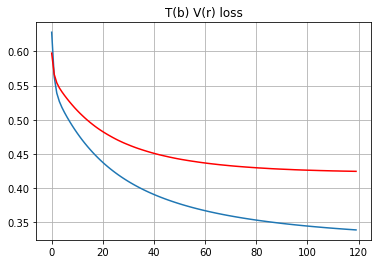

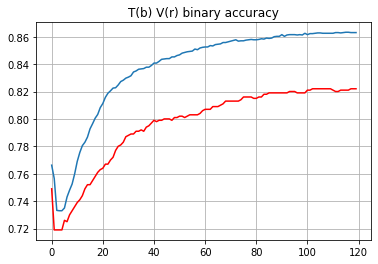

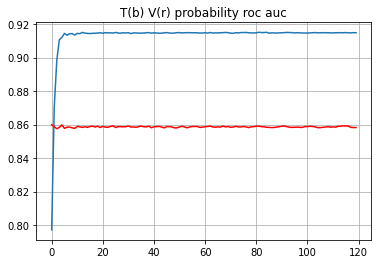



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.863
out sample binary accuracy: 0.822


 predictions in form : proba
 in sample proba roc_auc: 0.9148976360552038
out sample proba roc_auc: 0.8585124654150933

model weights:
 parameter: [[7.252311]] 
 bias: [-2.955903]


In [150]:
def UPBS_model_init():    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(1)),
        # tf.keras.layers.Activation('sigmoid'),
        # tf.keras.layers.Dense(10),
        # tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('sigmoid')
        ])

    OPT=tf.keras.optimizers.SGD( learning_rate=0.02, momentum=0.01 )

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.MeanSquaredError(),
        optimizer=OPT,
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')
        ])

    return model
#     model.summary()
tmp_mod=TV_validation(UPBS_model_init, GUF('UPBS'), V_GUF('UPBS'), tv_epochs=120, get=True) 
mod_wgt=tmp_mod.layers[0].get_weights()
print( "model weights:\n parameter:", mod_wgt[0],"\n bias:", mod_wgt[1] )
del tmp_mod

# mod_wgt=[el[0] for el in tmp_UPC_model.layers[0].get_weights()[0]]
# plt.plot(list(range(len(mod_wgt))) , mod_wgt)
# plt.show()

    # OPT=tf.keras.optimizers.SGD( learning_rate=0.02, momentum=0.01)
#rocauc si stabilizza velocemente
#i valori OS sono stabili per ep>100

# predictions in form : proba
#  in sample proba roc_auc: 0.9148976360552038
# out sample proba roc_auc: 0.8585124654150933

In [151]:
def UDBS_model_init():    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(1)),
        # tf.keras.layers.Activation('sigmoid'),
        # tf.keras.layers.Dense(10),
        # tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('sigmoid')
        ])

    OPT=tf.keras.optimizers.SGD( learning_rate=0.02, momentum=0.01 )

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.MeanSquaredError(),
        optimizer=OPT,
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')
        ])

    return model
#     model.summary()
# tmp_mod=TV_validation(UDBS_model_init, GUF('UDBS'), V_GUF('UDBS'), tv_epochs=50, get=True) 
# mod_wgt=tmp_mod.layers[0].get_weights()
# print( "model weights:\n parameter:", mod_wgt[0],"\n bias:", mod_wgt[1] )
# del tmp_mod

# plt.plot(list(range(len(mod_wgt))) , mod_wgt)
# plt.show()

training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________




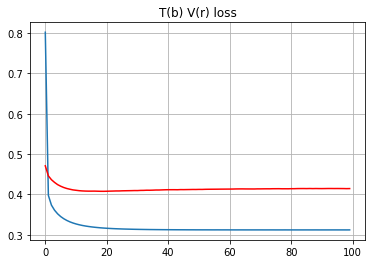

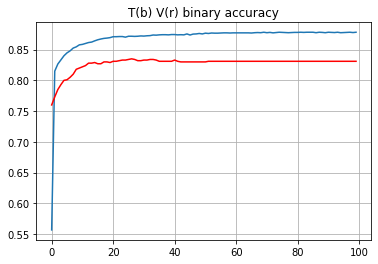

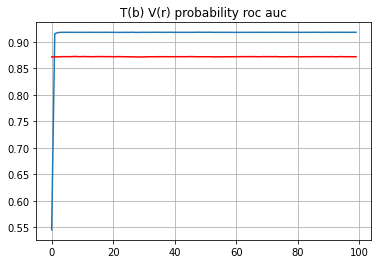



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.8775
out sample binary accuracy: 0.831


 predictions in form : proba
 in sample proba roc_auc: 0.9180951121807154
out sample proba roc_auc: 0.8721509213567677

model weights:
 parameter: [[2.0056667]] 
 bias: [1.4474012]


In [152]:
def UNBS_model_init():    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(1)),
        # tf.keras.layers.Activation('sigmoid'),
        # tf.keras.layers.Dense(10),
        # tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('sigmoid')
        ])

    OPT=tf.keras.optimizers.SGD( learning_rate=0.02, momentum=0.000 )

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.MeanSquaredError(),
        optimizer=OPT,
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')
        ])

    return model
#     model.summary()
tmp_mod=TV_validation(UNBS_model_init, GUF('UNBS'), V_GUF('UNBS'), tv_epochs=100, get=True) 
mod_wgt=tmp_mod.layers[0].get_weights()
print( "model weights:\n parameter:", mod_wgt[0],"\n bias:", mod_wgt[1] )
del tmp_mod

# OPT=tf.keras.optimizers.SGD( learning_rate=0.005, momentum=0.005 )
# per ep>100 torna a crescere la loss
# rocauc si stabilizza velocemente

#  predictions in form : proba
#  in sample proba roc_auc: 0.9180951121807154
# out sample proba roc_auc: 0.8721509213567677

In [153]:
K_REG=tf.keras.regularizers.L1L2(l1=0.001, l2=0.02)

def SCORES_model_init():    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(3)),
        # tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(9,
        kernel_regularizer='l1'),
        tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('sigmoid')
        ])

    OPT=tf.keras.optimizers.SGD( learning_rate=0.005, momentum=0.005 )

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.MeanSquaredError(),
        optimizer=OPT,
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')
        ])

    return model
#     model.summary()
# tmp_model=TV_validation(SCORES_model_init, GUF(['UPBS','UDBS','UNBS']), V_GUF(['UPBS','UDBS','UNBS']), tv_epochs=200, get=True) 
# visualize_layer_weights(tmp_model, layer='all')
# del tmp_model
# senza hidden layer dà in rocauc gli stessi risultati di UNBS da solo (migliore predittore?)
# con hidden 4 dà risultati molto simili
#rocauc si stabilizza molto velocemente

# ho usato hiddel layer(4) con attivazione sigmoide
    # OPT=tf.keras.optimizers.SGD( learning_rate=0.005, momentum=0.005 )
    # tv_epochs=200


#  predictions in form : proba
#  in sample proba roc_auc: 0.9182983774545119
# out sample proba roc_auc: 0.8722004167512214

In [154]:
K_REG=tf.keras.regularizers.L1L2(l1=0.001, l2=0.02)
A_REG=tf.keras.regularizers.L1L2(l1=0.000, l2=0.001)

def UPC_model_init():    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(len(ref_subreddit_list))),
        # tf.keras.layers.Activation('sigmoid'),
        # tf.keras.layers.Dense(4),
        # tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(
            1,
            kernel_initializer='zeros',
            kernel_regularizer=K_REG,
            # activity_regularizer=A_REG,
        ),
        # tf.keras.layers.Dense(1),
        # tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('sigmoid')
        ])

    # OPT=tf.keras.optimizers.SGD( learning_rate=0.005, momentum=0.002 )
    OPT=tf.keras.optimizers.Adam(
        learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    )

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.MeanSquaredError(),
        optimizer=OPT,
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')
        ])

    return model
#     model.summary()
# tmp_model=TV_validation(UPC_model_init, GUF('UPC'), V_GUF('UPC'), tv_epochs=100, get=True) 
# visualize_layer_weights(tmp_model, layer='all')
# del tmp_model


In [155]:
INIT_TENSOR=np.array([dictoarr(TRAIN_SPBS),dictoarr(TRAIN_SDBS),dictoarr(TRAIN_SNBS)/10, dictoarr(TRAIN_SNBS)/10]).T
# INIT_TENSOR=np.array([dictoarr(TRAIN_SDBS),dictoarr(TRAIN_SDBS),dictoarr(TRAIN_SDBS), dictoarr(TRAIN_SDBS)]).T

# INIT_TENSOR=dictoarr(TRAIN_SDBS)

In [156]:
len(INIT_TENSOR)

3317

In [157]:
def UPC_NORMED_model_init():#l1_val,l2_val,lr_val, ac_l2_val):
    print("\n inside initializer:", l1_val,l2_val,lr_val)

    K_REG=tf.keras.regularizers.L1L2(l1=l1_val, l2=l2_val)
    # A_REG=tf.keras.regularizers.L1L2(l1=0.000, l2=ac_l2_val)

    # INIT=tf.constant_initializer(INIT_TENSOR)
    # INIT=tf.constant_initializer(dictoarr(TRAIN_SNBS))
    INIT='ones'
    
    

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(len(ref_subreddit_list))),
        # tf.keras.layers.Activation('sigmoid'),
        # tf.keras.layers.Dense(4),
        # tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(
            len(INIT_TENSOR.T),
            kernel_initializer=INIT,
            kernel_regularizer=K_REG,
            # activity_regularizer=A_REG,
            use_bias=False
        ),
        # tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(1, kernel_initializer='ones'),
        tf.keras.layers.Activation('sigmoid')
        ])

    OPT=tf.keras.optimizers.SGD( learning_rate=lr_proc, momentum=0.002 )
    # OPT=tf.keras.optimizers.Adam(
    #     learning_rate=lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    # )
    # OPT='adam'

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.MeanSquaredError(),
        optimizer=OPT,
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')
        ])
    model.layers[0].set_weights([INIT_TENSOR ])
    print("layers weight initialization:")
    mod_wgt=[layer_weight for layer_weight in model.layers[0].get_weights()[0].T]
    for lay_wgt in mod_wgt:
        plt.plot(list(range(len(lay_wgt))), lay_wgt)
        plt.show()
    return model




l1_val=0.01
l2_val=0.0001
lr_val=0.005

# tmp_model=TV_validation(UPC_NORMED_model_init, GUF('UPC_NORMED'), V_GUF('UPC_NORMED'), shuffle=True, tv_epochs=200, get=True) 
# visualize_layer_weights(tmp_model, layer='all')
# del tmp_model

In [158]:
GRID_SEARCH_UPC_MODEL=False

In [159]:

if GRID_SEARCH_UPC_MODEL:
    counter=0
    for l1_val in [0.0001, 0.0002 ,0.0005, 0.001, 0.002, 0.005, 0.01]:
        print("-------------------------------------------------------------------- l1 val:", l1_val)
        for l2_val in [ 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]:
            print("-------------------------------------------------------------------- l2 val:", l2_val)
            for lr_val in [ 0.0001, 0.001, 0.005, 0.01]:
                # for ac_l2_val in [0., 0.0001, 0.0002 ,0.0005, 0.001, 0.002, 0.005, 0.01]:
                counter+=1
                print("\n\n  ---------------===========[[[ ITERATION NUMBER", counter,": l1 reg:", l1_val,"l2 reg:", l2_val, "lr reg:",lr_val,"act_l2 reg: no ]]]===========--------------- \n\n" )
                tmp_model=TV_validation(UPC_NORMED_model_init, GUF('UPC_NORMED'), V_GUF('UPC_NORMED'), tv_epochs=50, get=True) 
                mod_wgt=[el[0] for el in tmp_model.layers[0].get_weights()[0]]
                plt.plot(list(range(len(mod_wgt))), mod_wgt)
                plt.show()

                del tmp_model

training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 1001      
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________




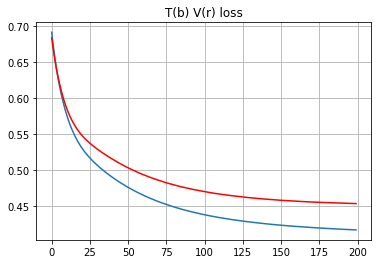

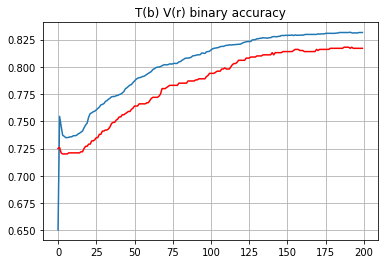

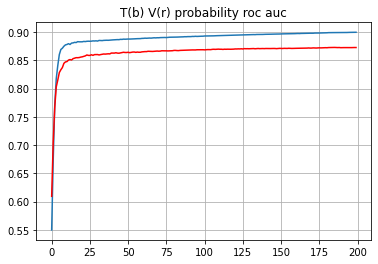



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.8315
out sample binary accuracy: 0.817


 predictions in form : proba
 in sample proba roc_auc: 0.9001301664188524
out sample proba roc_auc: 0.8731136067788892


 ######################################################################## layer 0 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Dense'>


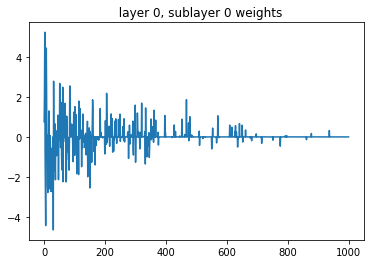





 ######################################################################## layer 1 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Activation'>





In [160]:
# K_REG=tf.keras.regularizers.L1L2(l1=0.0002, l2=0.0000)   #<----- nb default are l1=0.01, l2=0.01
# lr_proc = tf.keras.optimizers.schedules.ExponentialDecay(
#             0.005,
#             decay_steps=100000,
#             decay_rate=0.96,
#             staircase=True)
# INIT= tf.constant_initializer( np.arange(-1,1,))
truncate=5000

def AUPCA_TFIDF_model_init():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=( min(truncate, EXP_GIVEN_VAR_TFIDF)) ),
        # tf.keras.layers.Activation('sigmoid'),
        # tf.keras.layers.Dense(4),
        # tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0002, l2=0.0000)
            ),
        tf.keras.layers.Activation('sigmoid')
    ])

    # OPT=tf.keras.optimizers.SGD( learning_rate=0.1, momentum=0.001 )
    OPT=tf.keras.optimizers.Adam(
        learning_rate=0.0005,                #<-------- nb default è learning_rate =0.001
        beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    )
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.MeanSquaredError(),
        optimizer=OPT,
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')
        ])

    return model

tmp_model=TV_validation(AUPCA_TFIDF_model_init, 
                        GUF('AUPCA_TFIDF')[:,:min(truncate, EXP_GIVEN_VAR_TFIDF)], V_GUF('AUPCA_TFIDF')[:,:min(truncate, EXP_GIVEN_VAR_TFIDF)], 
                        shuffle=False, predict='proba', tv_epochs=200, get=True) 
visualize_layer_weights(tmp_model)
del tmp_model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 1001      
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
 cross validation with 10 folds of size 400



#################################################################  fold  0 :
---------------Test fold: 0
Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


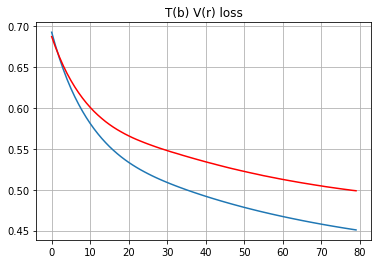

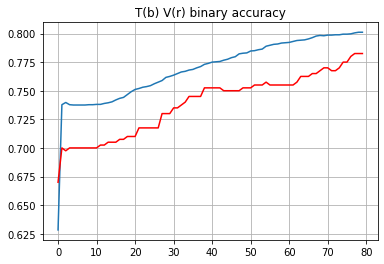

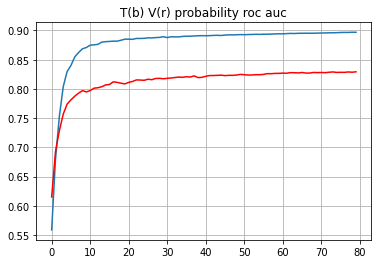

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 0 ) results:
 Accuracy in= 0.8013888597488403 ; Accuracy out= 0.7825000286102295
 class ROC_AUC_IN: 0.627924355723293 ; class ROC_AUC OUT: 0.6475162178974496
 proba ROC_AUC IN: 0.8970059156417847 ; proba ROC_AUC OUT: 0.8292455077171326



#################################################################  fold  1 :
Train fold: 0,---------------Test fold: 1
Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


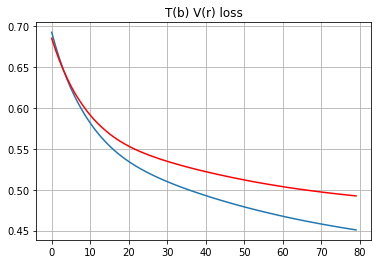

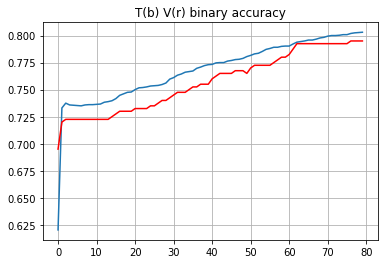

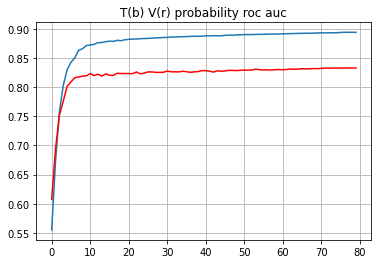

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 1 ) results:
 Accuracy in= 0.8033333420753479 ; Accuracy out= 0.7950000166893005
 class ROC_AUC_IN: 0.636426498338902 ; class ROC_AUC OUT: 0.6389538327254589
 proba ROC_AUC IN: 0.8947144746780396 ; proba ROC_AUC OUT: 0.8327410221099854



#################################################################  fold  2 :
Train fold: 0,Train fold: 1,---------------Test fold: 2
Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


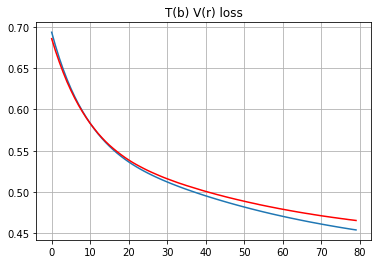

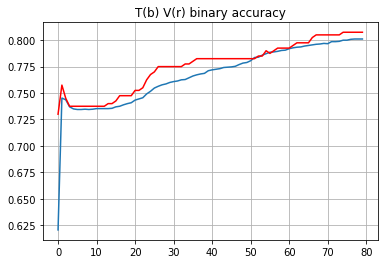

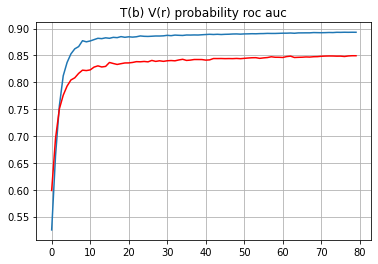

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 2 ) results:
 Accuracy in= 0.8013888597488403 ; Accuracy out= 0.8075000047683716
 class ROC_AUC_IN: 0.6336157114979463 ; class ROC_AUC OUT: 0.6490861535517207
 proba ROC_AUC IN: 0.8935765027999878 ; proba ROC_AUC OUT: 0.8493349552154541



#################################################################  fold  3 :
Train fold: 0,Train fold: 1,Train fold: 2,---------------Test fold: 3
Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


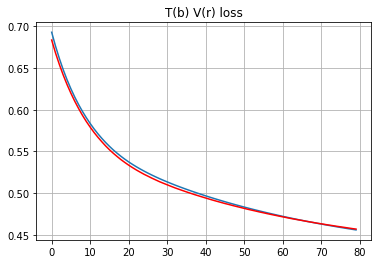

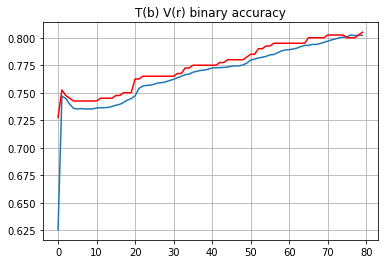

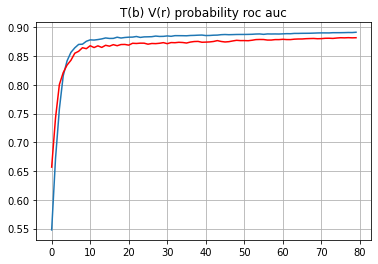

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 3 ) results:
 Accuracy in= 0.8030555844306946 ; Accuracy out= 0.8050000071525574
 class ROC_AUC_IN: 0.6395384963278309 ; class ROC_AUC OUT: 0.6277009577980451
 proba ROC_AUC IN: 0.8921317458152771 ; proba ROC_AUC OUT: 0.882105827331543



#################################################################  fold  4 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,---------------Test fold: 4
Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


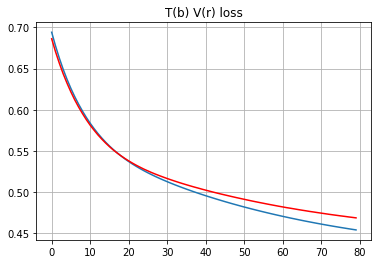

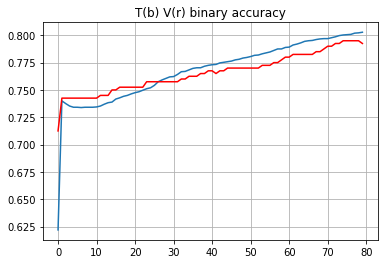

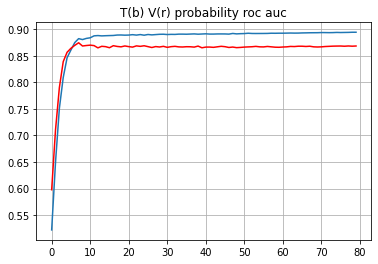

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 4 ) results:
 Accuracy in= 0.8025000095367432 ; Accuracy out= 0.7925000190734863
 class ROC_AUC_IN: 0.6371887013204077 ; class ROC_AUC OUT: 0.6065999803863882
 proba ROC_AUC IN: 0.8946047425270081 ; proba ROC_AUC OUT: 0.8684253692626953



#################################################################  fold  5 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,---------------Test fold: 5
Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


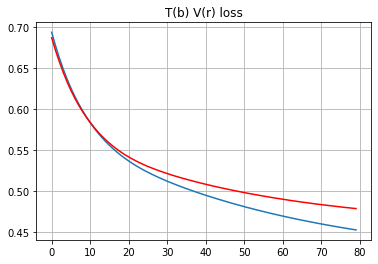

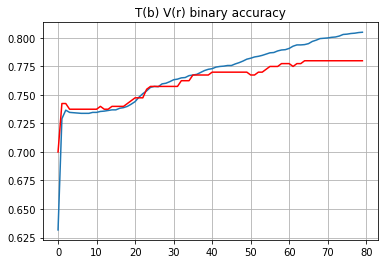

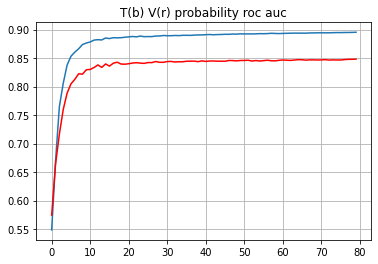

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 5 ) results:
 Accuracy in= 0.8055555820465088 ; Accuracy out= 0.7799999713897705
 class ROC_AUC_IN: 0.642485265400005 ; class ROC_AUC OUT: 0.5901533494753834
 proba ROC_AUC IN: 0.8958355784416199 ; proba ROC_AUC OUT: 0.8481840491294861



#################################################################  fold  6 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,---------------Test fold: 6
Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


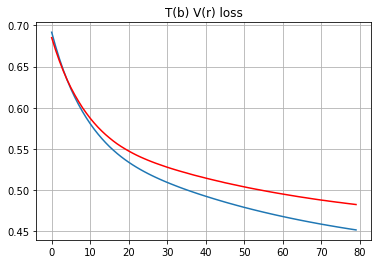

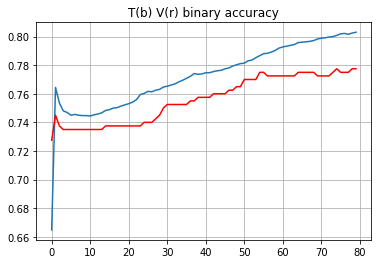

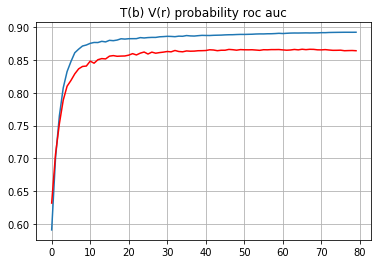

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 6 ) results:
 Accuracy in= 0.8036110997200012 ; Accuracy out= 0.7774999737739563
 class ROC_AUC_IN: 0.6397253787878788 ; class ROC_AUC OUT: 0.5996321664129883
 proba ROC_AUC IN: 0.8933351039886475 ; proba ROC_AUC OUT: 0.8643772006034851



#################################################################  fold  7 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,---------------Test fold: 7
Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


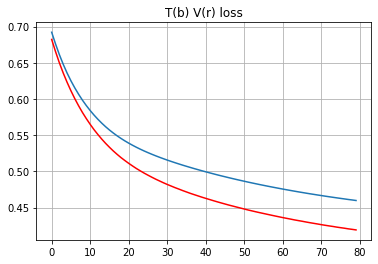

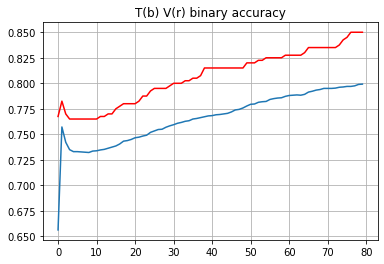

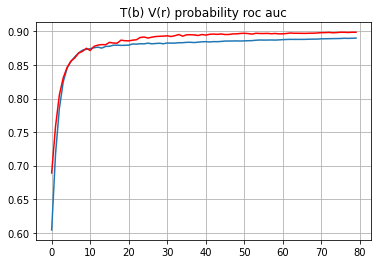

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 7 ) results:
 Accuracy in= 0.800000011920929 ; Accuracy out= 0.8500000238418579
 class ROC_AUC_IN: 0.6357883758949208 ; class ROC_AUC OUT: 0.6875
 proba ROC_AUC IN: 0.8905268907546997 ; proba ROC_AUC OUT: 0.8986773490905762



#################################################################  fold  8 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,---------------Test fold: 8
Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


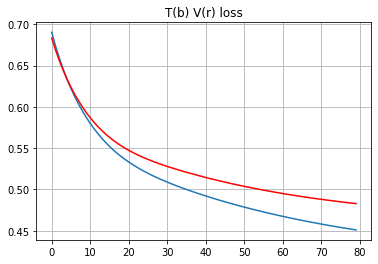

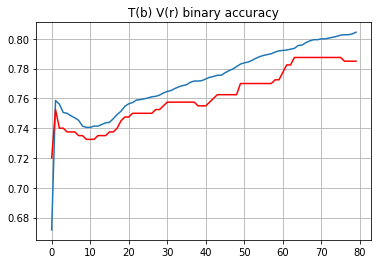

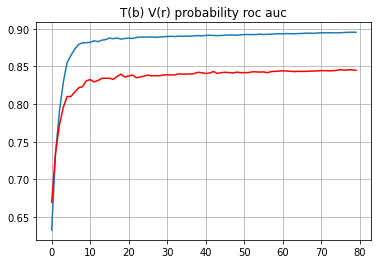

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 8 ) results:
 Accuracy in= 0.804444432258606 ; Accuracy out= 0.7850000262260437
 class ROC_AUC_IN: 0.6398495108033642 ; class ROC_AUC OUT: 0.620935814707441
 proba ROC_AUC IN: 0.8958927392959595 ; proba ROC_AUC OUT: 0.8448050022125244



#################################################################  fold  9 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,---------------Test fold: 9

initializing model
training model with sample of size 3600 for 80  epochs


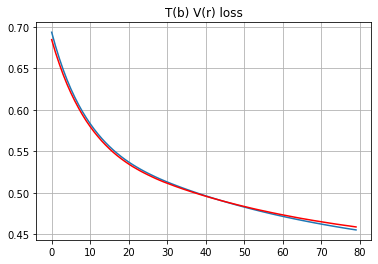

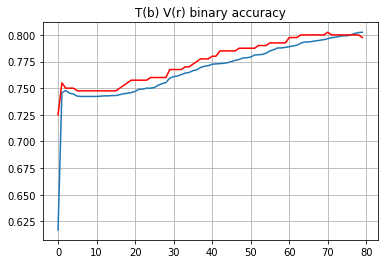

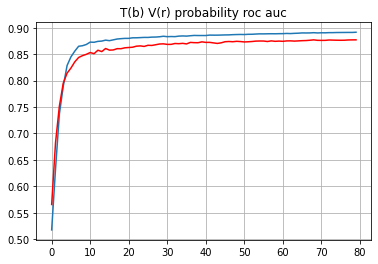

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 9 ) results:
 Accuracy in= 0.8027777671813965 ; Accuracy out= 0.7975000143051147
 class ROC_AUC_IN: 0.6393487430071477 ; class ROC_AUC OUT: 0.6131378510019286
 proba ROC_AUC IN: 0.8920270204544067 ; proba ROC_AUC OUT: 0.8771533966064453



CV results

 In Sample Accuracy:   mean 0.8028055548667907  stdev 0.0015237387133352218
Out Sample Accuracy:   mean 0.7972500085830688  stdev 0.020076424012334518

 In Sample class ROC_AUC :   mean 0.6371891037101696  stdev 0.00391013767111224
Out Sample class ROC_AUC :   mean 0.6281216323956804  stdev 0.027297502688617633

 ------------- final results ------------------------------------------------

 In Sample probability ROC_AUC :   mean 0.893965071439743  stdev 0.0019214128408500655
Out Sample probability ROC_AUC :   mean 0.8595049679279327  stdev 0.021306521580994588


(0.893965071439743, 0.8595049679279327)

In [161]:
cross_validation(GUF('AUPCA_TFIDF'), GUF('gender'), AUPCA_TFIDF_model_init, N_epochs=80, display=0)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 4)                 404       
_________________________________________________________________
activation_14 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
_________________________________________________________________
activation_15 (Activation)   (None, 1)                 0         
Total params: 409
Trainable params: 409
Non-trainable params: 0
_________________________________________________________________
 cross validation with 10 folds of size 400



#################################################################  fold  0 :
---------------Test fold: 0
Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,Tra

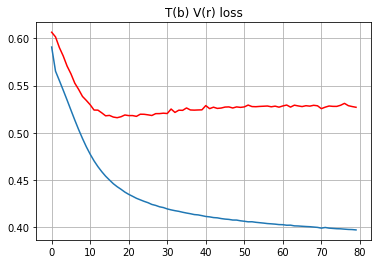

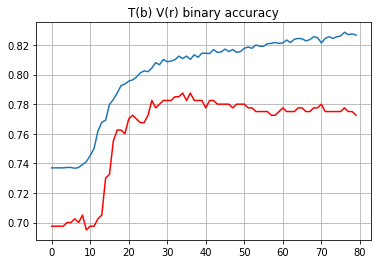

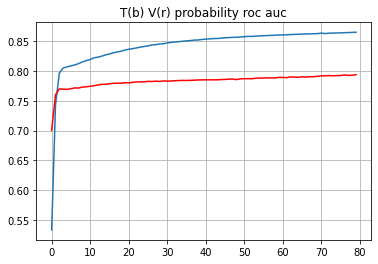

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 0 ) results:
 Accuracy in= 0.82833331823349 ; Accuracy out= 0.7724999785423279
 class ROC_AUC_IN: 0.7463631258032687 ; class ROC_AUC OUT: 0.7058710269853965
 proba ROC_AUC IN: 0.8656819462776184 ; proba ROC_AUC OUT: 0.7940253019332886



#################################################################  fold  1 :
Train fold: 0,---------------Test fold: 1
Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


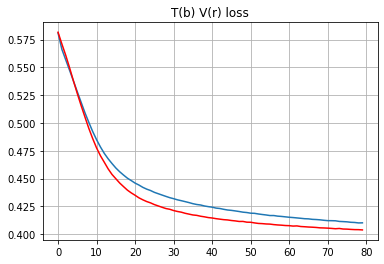

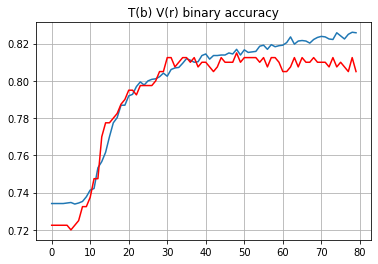

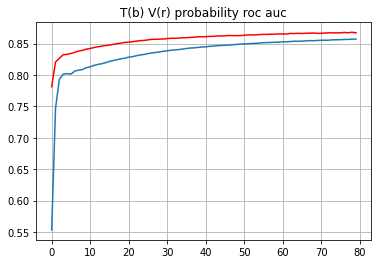

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 1 ) results:
 Accuracy in= 0.8241666555404663 ; Accuracy out= 0.8050000071525574
 class ROC_AUC_IN: 0.7346032638411987 ; class ROC_AUC OUT: 0.718008666105552
 proba ROC_AUC IN: 0.857698917388916 ; proba ROC_AUC OUT: 0.8670313954353333



#################################################################  fold  2 :
Train fold: 0,Train fold: 1,---------------Test fold: 2
Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


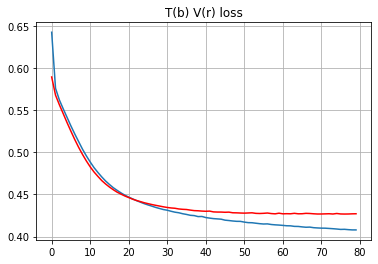

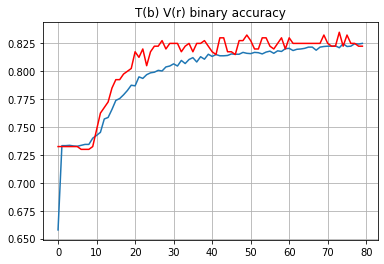

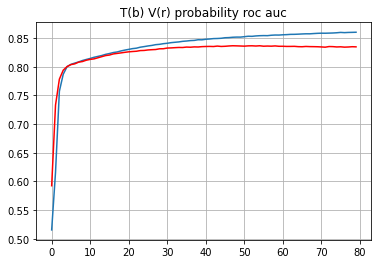

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 2 ) results:
 Accuracy in= 0.8258333206176758 ; Accuracy out= 0.8224999904632568
 class ROC_AUC_IN: 0.7402732722442794 ; class ROC_AUC OUT: 0.7275525501578898
 proba ROC_AUC IN: 0.8607051968574524 ; proba ROC_AUC OUT: 0.8346145153045654



#################################################################  fold  3 :
Train fold: 0,Train fold: 1,Train fold: 2,---------------Test fold: 3
Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


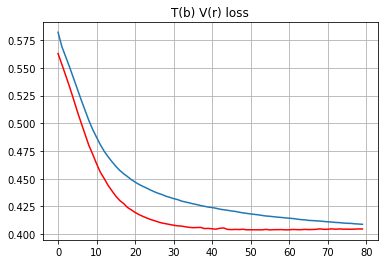

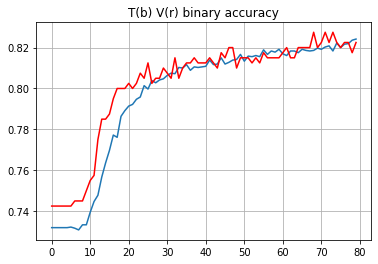

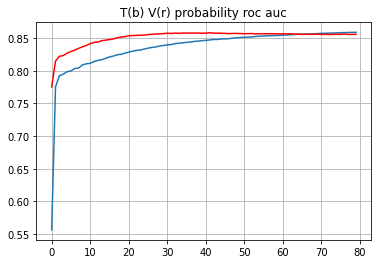

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 3 ) results:
 Accuracy in= 0.8197222352027893 ; Accuracy out= 0.8224999904632568
 class ROC_AUC_IN: 0.7310487557884595 ; class ROC_AUC OUT: 0.7187571507959858
 proba ROC_AUC IN: 0.8597956895828247 ; proba ROC_AUC OUT: 0.8560361266136169



#################################################################  fold  4 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,---------------Test fold: 4
Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


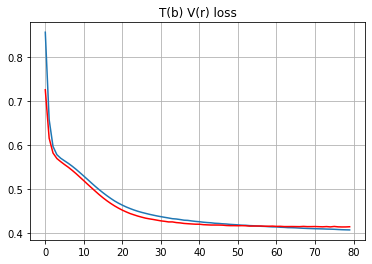

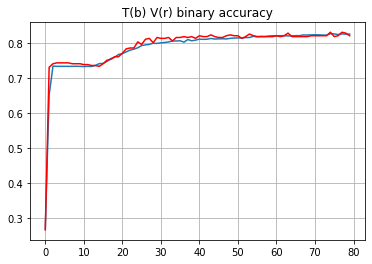

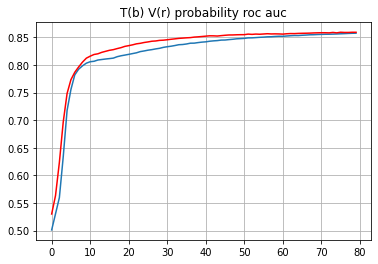

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 4 ) results:
 Accuracy in= 0.8247222304344177 ; Accuracy out= 0.8199999928474426
 class ROC_AUC_IN: 0.7364346039268123 ; class ROC_AUC OUT: 0.7139027818639468
 proba ROC_AUC IN: 0.8584870100021362 ; proba ROC_AUC OUT: 0.8593213558197021



#################################################################  fold  5 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,---------------Test fold: 5
Train fold: 6,Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


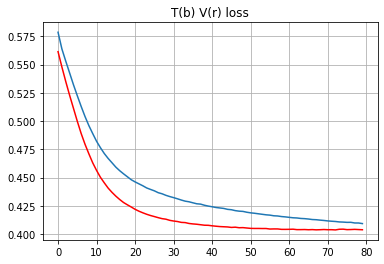

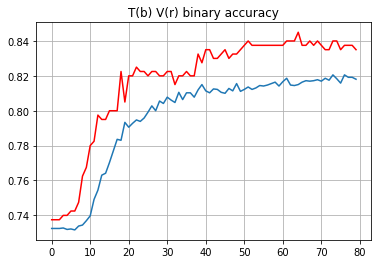

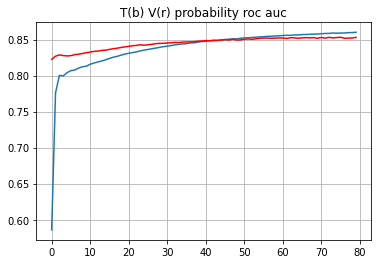

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 5 ) results:
 Accuracy in= 0.8216666579246521 ; Accuracy out= 0.8349999785423279
 class ROC_AUC_IN: 0.7385197707675459 ; class ROC_AUC OUT: 0.7531880548829701
 proba ROC_AUC IN: 0.8604427576065063 ; proba ROC_AUC OUT: 0.8529298305511475



#################################################################  fold  6 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,---------------Test fold: 6
Train fold: 7,Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


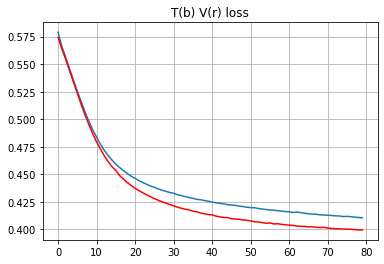

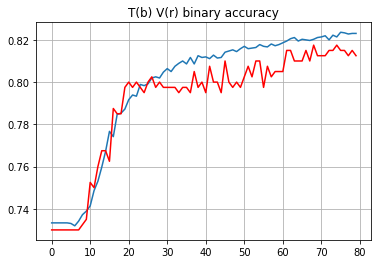

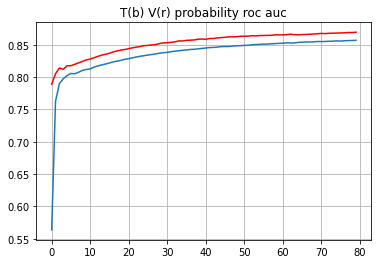

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 6 ) results:
 Accuracy in= 0.8230555653572083 ; Accuracy out= 0.8125
 class ROC_AUC_IN: 0.734185606060606 ; class ROC_AUC OUT: 0.7169583967529174
 proba ROC_AUC IN: 0.8576467633247375 ; proba ROC_AUC OUT: 0.8694666624069214



#################################################################  fold  7 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,---------------Test fold: 7
Train fold: 8,Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


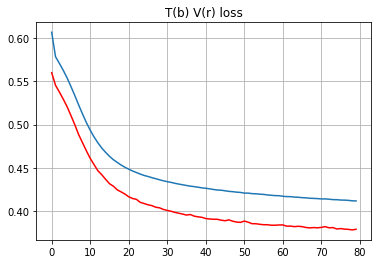

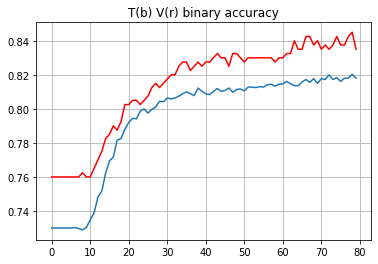

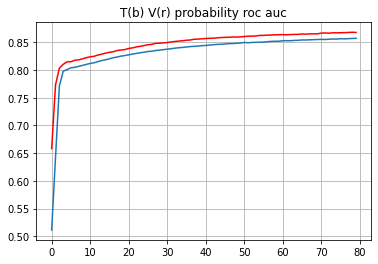

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 7 ) results:
 Accuracy in= 0.820555567741394 ; Accuracy out= 0.8349999785423279
 class ROC_AUC_IN: 0.7380348384914596 ; class ROC_AUC OUT: 0.7346491228070174
 proba ROC_AUC IN: 0.857441782951355 ; proba ROC_AUC OUT: 0.8677871227264404



#################################################################  fold  8 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,---------------Test fold: 8
Train fold: 9,
initializing model
training model with sample of size 3600 for 80  epochs


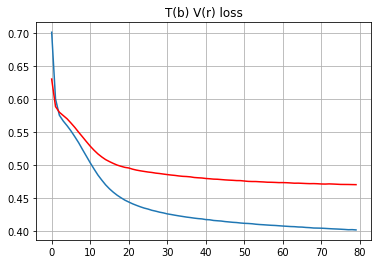

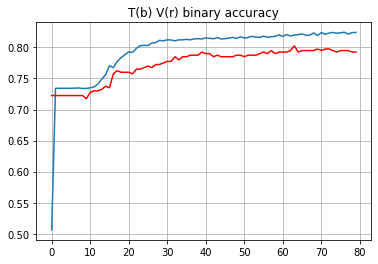

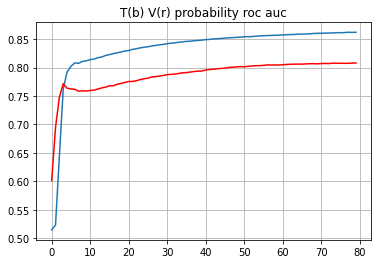

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 8 ) results:
 Accuracy in= 0.8241666555404663 ; Accuracy out= 0.7925000190734863
 class ROC_AUC_IN: 0.7409357182929533 ; class ROC_AUC OUT: 0.7010349449795817
 proba ROC_AUC IN: 0.8629278540611267 ; proba ROC_AUC OUT: 0.8081766366958618



#################################################################  fold  9 :
Train fold: 0,Train fold: 1,Train fold: 2,Train fold: 3,Train fold: 4,Train fold: 5,Train fold: 6,Train fold: 7,Train fold: 8,---------------Test fold: 9

initializing model
training model with sample of size 3600 for 80  epochs


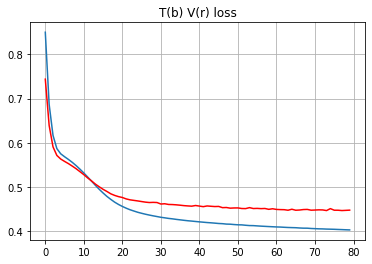

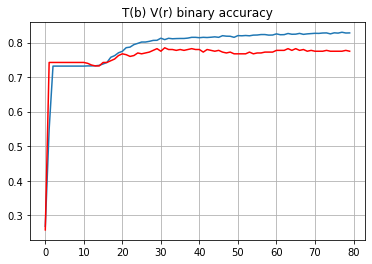

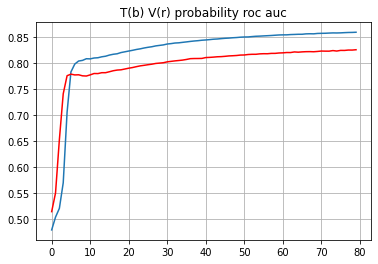

evaluating IN SAMPLE METRICS
evaluating OUT SAMPLE METRICS
#################################################
 fold 9 ) results:
 Accuracy in= 0.8311111330986023 ; Accuracy out= 0.7749999761581421
 class ROC_AUC_IN: 0.7552477116536069 ; class ROC_AUC OUT: 0.6962832205550652
 proba ROC_AUC IN: 0.8601557016372681 ; proba ROC_AUC OUT: 0.8259782791137695



CV results

 In Sample Accuracy:   mean 0.8243333339691162  stdev 0.003296555811972113
Out Sample Accuracy:   mean 0.8092499911785126  stdev 0.021507265379824225

 In Sample class ROC_AUC :   mean 0.739564666687019  stdev 0.006586796449321104
Out Sample class ROC_AUC :   mean 0.7186205915886322  stdev 0.015898998226029776

 ------------- final results ------------------------------------------------

 In Sample probability ROC_AUC :   mean 0.8600983619689941  stdev 0.002473574984153407
Out Sample probability ROC_AUC :   mean 0.8435367226600647  stdev 0.02528969104624724


(0.8600983619689941, 0.8435367226600647)

In [162]:

def U2V_model_init():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(w2v_params['size'])),
        # tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('sigmoid')
    ])

    # OPT=tf.keras.optimizers.SGD( learning_rate=0.1, momentum=0.001 )
    OPT=tf.keras.optimizers.Adam(
        learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    )
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.MeanSquaredError(),
        optimizer=OPT,
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')
        ])

    return model
#     model.summary()

cross_validation(GUF('U2V'),
                 GUF('gender'), 
                 U2V_model_init, 
                 mode='tf',
                 display=0,
                 N_epochs=80
                )

training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 4)                 404       
_________________________________________________________________
activation_36 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 5         
_________________________________________________________________
activation_37 (Activation)   (None, 1)                 0         
Total params: 409
Trainable params: 409
Non-trainable params: 0
_________________________________________________________________




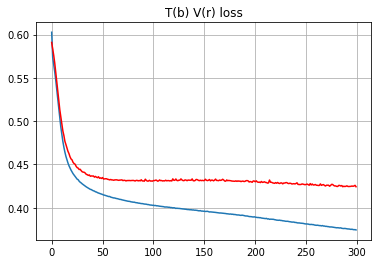

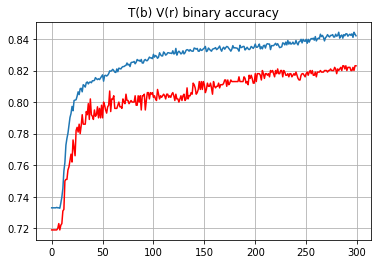

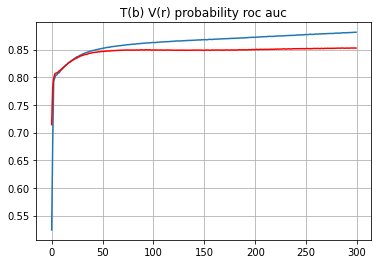



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.844
out sample binary accuracy: 0.823


 predictions in form : proba
 in sample proba roc_auc: 0.8815651649626233
out sample proba roc_auc: 0.8527017061062468


 ######################################################################## layer 0 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Dense'>


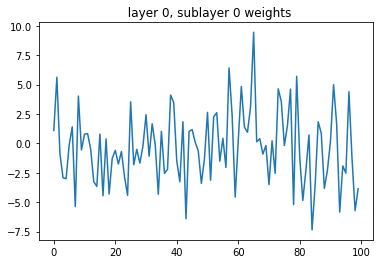

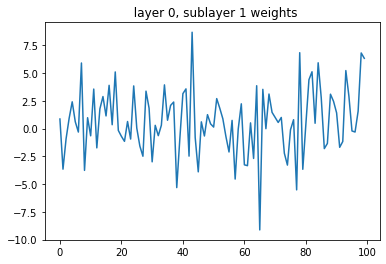

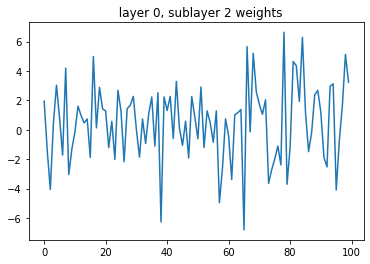

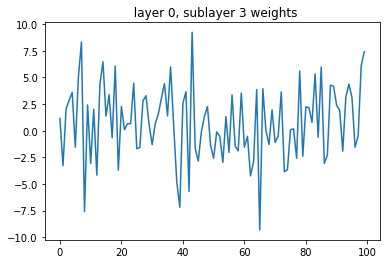

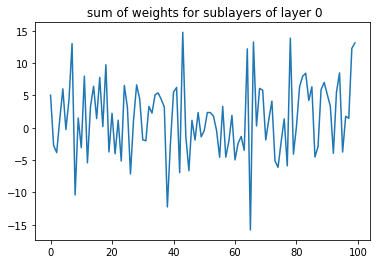





 ######################################################################## layer 1 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Activation'>




 ######################################################################## layer 2 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Dense'>


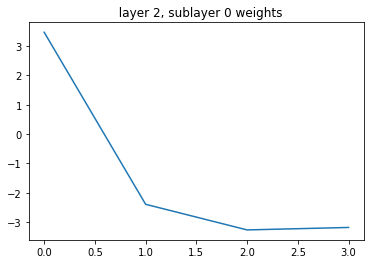





 ######################################################################## layer 3 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Activation'>





In [163]:
tmp_model=TV_validation(U2V_model_init, GUF('U2V'), V_GUF('U2V'), shuffle=False, predict='proba', tv_epochs=300, get=True)
visualize_layer_weights(tmp_model)
del tmp_model
# NB potrei provare a mettere un regolarizzatore L2 al primo layer


# no hidden layers
# OPT=tf.keras.optimizers.SGD( learning_rate=1.5, momentum=0.000 )
# TV_validation(U2V_model_init, GUF('U2V'), V_GUF('U2V'), shuffle=True, predict='proba', tv_epochs=500)
#  predictions in form : proba
#  in sample proba roc_auc: 0.863798190996562
# out sample proba roc_auc: 0.861252140934671

# hidden layer 4 con attivazione sigmoide
# OPT=tf.keras.optimizers.SGD( learning_rate=0.25, momentum=0.000 )
# TV_validation(U2V_model_init, GUF('U2V'), V_GUF('U2V'), shuffle=True, predict='proba', tv_epochs=300)
#  predictions in form : proba
#  in sample proba roc_auc: 0.8679776971379403
# out sample proba roc_auc: 0.8634253465832413
# più o meno oscilla tra 8.4 e 8.7

# hidden layer 4 con attivazione sigmoide
# OPT=tf.keras.optimizers.Adam(
#     learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
# )
#  ------------- final results ------------------------------------------------
#  In Sample probability ROC_AUC :   mean 0.8753708183765412  stdev 0.002581733738982793
# Out Sample probability ROC_AUC :   mean 0.8524503529071807  stdev 0.023451417441800456

# senza hidden layer
# OPT=tf.keras.optimizers.Adam(
#         learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#     ) 
#  ------------- final results ------------------------------------------------
#  In Sample probability ROC_AUC :   mean 0.8686794400215149  stdev 0.002636061851713495
# Out Sample probability ROC_AUC :   mean 0.8495721340179443  stdev 0.025056109840509558


training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 1)                 501       
_________________________________________________________________
activation_38 (Activation)   (None, 1)                 0         
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________




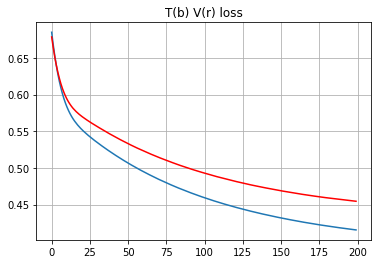

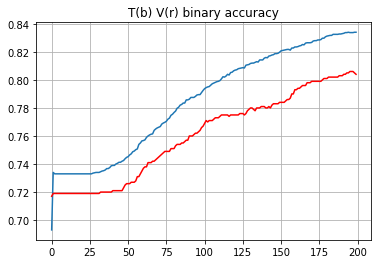

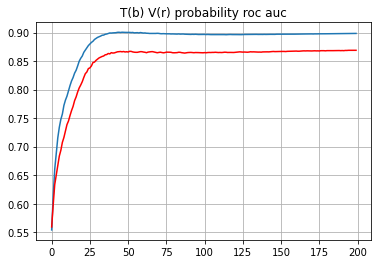



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.83375
out sample binary accuracy: 0.804


 predictions in form : proba
 in sample proba roc_auc: 0.898730142914808
out sample proba roc_auc: 0.8688867000925563


 ######################################################################## layer 0 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Dense'>


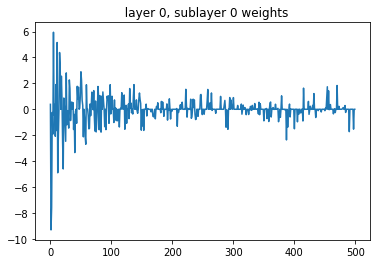





 ######################################################################## layer 1 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Activation'>





In [164]:
# K_REG=tf.keras.regularizers.L1L2(l1=0.008, l2=0.0001)   #<----- nb default are l1=0.01, l2=0.01
# lr_proc = tf.keras.optimizers.schedules.ExponentialDecay(
#             0.005,
#             decay_steps=100000,
#             decay_rate=0.96,
#             staircase=True)
# INIT= tf.constant_initializer( np.arange(-1,1,))
truncate=5000

def ULSA_model_init():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=( min(truncate, EXP_GIVEN_VAR_LSA)) ),
        # tf.keras.layers.Activation('sigmoid'),
        # tf.keras.layers.Dense(4),
        # tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0000)
            ),
        tf.keras.layers.Activation('sigmoid')
    ])

    # OPT=tf.keras.optimizers.SGD( learning_rate=0.1, momentum=0.001 )
    OPT=tf.keras.optimizers.Adam(
        learning_rate=0.0005,                #<-------- nb default è learning_rate =0.001
        beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    )
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.MeanSquaredError(),
        optimizer=OPT,
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')
        ])

    return model

tmp_model=TV_validation(ULSA_model_init, 
                        GUF('ULSA')[:,:min(truncate, EXP_GIVEN_VAR_LSA)], V_GUF('ULSA')[:,:min(truncate, EXP_GIVEN_VAR_LSA)], 
                        shuffle=False, predict='proba', tv_epochs=200, get=True) 
visualize_layer_weights(tmp_model)
del tmp_model

In [165]:
# cross_validation(GUF('ULSA'),
#                  GUF('gender'), 
#                  ULSA_model_init, 
#                  mode='tf',
#                  display=0,
#                  N_epochs=100
#                 )

In [166]:

def UNPBSU2V_model_init():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(w2v_params['size'])+2),
        # tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(4),
        # tf.keras.layers.Activation('sigmoid'),
        # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('sigmoid')
    ])

    OPT=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    )
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        # loss=tf.keras.losses.MeanSquaredError(),
        optimizer=OPT,
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')
        ])

    return model
# TV_validation(UNPBSU2V_model_init, GUF(['UNBS','UPBS','U2V']), V_GUF(['UNBS','UPBS','U2V']), tv_epochs=250)

# Ensamble dei modelli

Infine ho quindi lavorato all'ensamble di questi modelli. La prima cosa che ho fatto è stata fare una media dei risultati, e questo restituiva già buoni risultati out of sample. 

Ho poi deciso di lasciar scegliere i pesi da dare ai modelli ad un ulteriore rete neurale con hidden layer di dimensione parametrizzata, che avrebbe preso i risultati dei modelli precedentemente allenati e ne avrebbe poi restituito un unico output continuo tra zero ed uno (ultimo layer con attivazione simoide). Non conosco se sia un metodo risaputamente affidabile per fare ensamble e non ho letto nulla al riguardo, ma ha dato risultati migliori della semplice media.

Per curiosità ho anche provato a fissare il primo layer come tutte le combinazioni possibili degli output dei modelli di base, per poi lavorare su questo input da dare ad una regressione logistica o ad una rete con un hidden layer, oltre a regolarizzazioni diverse di questo modello di ensamble e varie prove con il numero di nodi nell'hidden layer. L'idea di quest'ultimo era trarre informazioni dalle possibili correlazioni dei modelli, ma il più semplice modello senza questo layer iniziale mi è sembrato dare risultati migliori.

Dopo queste considerazioni sul metodo di ensamble, avendo osservato il comportamento in validazione del modello complessivo, ho fatto un ultimo training dei modelli iniziali su tutto il train e validation set (5000 utenti) e riallenato la rete di ensamble

In [167]:

def joiner_init(hl_size, N_models):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(N_models)),
        # tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(hl_size,
        ),
        # tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,
        ),
        tf.keras.layers.Activation('sigmoid')
    ])

    OPT=tf.keras.optimizers.Adam(
        learning_rate=0.001,                #<-------- nb default è learning_rate =0.001
        beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    )

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=OPT,
        # loss_weights=dictoarr(loss_weights),
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')])

    return model

class Joint_models:

    def __init__(self, models_init_dict, hl_size=None, keep_train_and_validation_submodels_predictions=True):

        self.models_init={}
        self.models={}
        self.N_models=len(models_init_dict)
        for model_name, model_init in models_init_dict.items():
            print("  J model got", model_name," model initializer")
            self.models_init[model_name]=model_init
            self.models[model_name]=None

        print()
        if hl_size is None:
            hl_size=self.N_models**2
        self.joiner_init_starter=joiner_init
        self.joiner=None
        self.hl_size=hl_size 
        print("   joiner hidden layer of size", hl_size)
        print()

        self.trained=False
        self.keep_TV_SM_preds=keep_train_and_validation_submodels_predictions

    def joiner_init(self):
        return self.joiner_init_starter(self.hl_size, self.N_models)

    def submodels_predict(self, sm_data, out_type='nparr'):   #deve ricevere un dizionario del tipo {nome_modello: predizioni}
        predictions=None

        for model_name, model in self.models.items():
            if predictions is None:    
                predictions=model.predict(sm_data[model_name])
            else:
                predictions=np.hstack( (predictions, model.predict(sm_data[model_name])) )

        return predictions

    def predict(self, sm_data):
        sm_predictions=self.submodels_predict(sm_data)
        predictions=self.joiner.predict(sm_predictions)
        return predictions

    def train(self, J_epochs=100, epochs_dict=100, 
    models_T_data_dict=None, models_T_targ_dict=None, models_V_data_dict=None, models_V_targ_dict=None, cheaky_shuffle=False, validation=True):  
        #avrebbe bisogno di dati e target in input
        #ma per implementarlo velocemente basta dirgli di prendere quelli nel programma
        #MI DEVO RICORDARE DI DARE AI MODELLI GLI STESSI NOMI DELLE FEATURES CHE PRENDONO
        
        models_T_data_dict={}
        models_T_targ_dict={}
        models_V_data_dict={}
        models_V_targ_dict={}

        for model_name in self.models:
            models_T_data_dict[model_name]=GUF(model_name)
            models_T_targ_dict[model_name]=GUF('gender')
            models_V_data_dict[model_name]=V_GUF(model_name)  #NB i target devono essere gli stessi per tutti 
            models_V_targ_dict[model_name]=V_GUF('gender')    #perché poi saranno i target del joiner

        if type(epochs_dict) is int:
            tmp=epochs_dict
            epochs_dict={}
            for model_name in self.models:
                epochs_dict[model_name]=tmp

        for model_name, model in self.models.items():
            print("\n ######################################################################   ", end='')
            print(" training model", model_name," for", epochs_dict[model_name],"epochs")
            if self.trained is False or self.models[model_name] is None:
                if model_name=='UPBS' or model_name=='UDBS' or model_name=='UNBS':
                    cheak_shuff=False
                elif cheaky_shuffle:
                    cheak_shuff=True
                self.models[model_name]=TV_validation(
                        self.models_init[model_name],
                        models_T_data_dict[model_name], models_V_data_dict[model_name],
                        train_target=models_T_targ_dict[model_name], valid_target=models_V_targ_dict[model_name],
                        tv_epochs=epochs_dict[model_name], get=True, shuffle=cheak_shuff,
                        validation=validation
                        )
            else: 
                print("ERROR consecutive training not implemented")

        valid_predictions=self.submodels_predict(models_V_data_dict)
        train_predictions=self.submodels_predict(models_T_data_dict)
  
        if self.keep_TV_SM_preds:
            self.T_SM_preds=train_predictions
            self.V_SM_preds=valid_predictions

        if self.trained is False or self.joiner is None:
            self.joiner=TV_validation(
                self.joiner_init, 
                train_predictions, valid_predictions, 
                train_target=GUF('gender'), valid_target=V_GUF('gender'),
                tv_epochs=J_epochs, get=True,
                validation=validation
            )

        else:
            print("consecutive training not implemented")

        self.trained=True

    def retrain_J_layers(self, new_J_init=None, display=True, validation=True):

        if new_J_init != None:
            self.joiner_init=new_J_init

        if self.keep_TV_SM_preds:
            train_predictions=self.T_SM_preds
            valid_predictions=self.V_SM_preds
        else:
            valid_predictions=self.submodels_predict(models_V_data_dict)
            train_predictions=self.submodels_predict(models_T_data_dict)

        self.joiner=TV_validation(
            self.joiner_init, 
            train_predictions, valid_predictions, 
            train_target=GUF('gender'), valid_target=V_GUF('gender'),
            tv_epochs=J_epochs, get=True,
            validation=validation
        )

        if display:
            visualize_layer_weights(self.joiner)


  

                
        


  J model got UPBS  model initializer
  J model got UNBS  model initializer
  J model got U2V  model initializer
  J model got ULSA  model initializer
  J model got AUPCA_TFIDF  model initializer

   joiner hidden layer of size 10


 ######################################################################    training model UPBS  for 100 epochs
training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 1)                 2         
_________________________________________________________________
activation_39 (Activation)   (None, 1)                 0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________




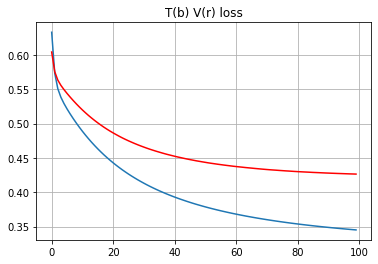

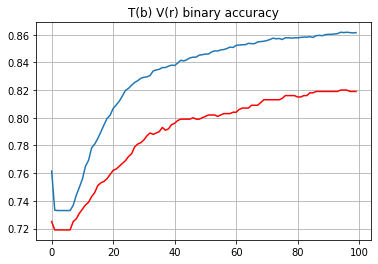

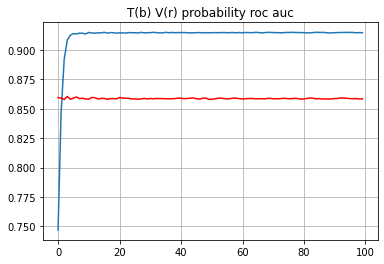



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.86125
out sample binary accuracy: 0.819


 predictions in form : proba
 in sample proba roc_auc: 0.9148976360552038
out sample proba roc_auc: 0.8585124654150933


 ######################################################################    training model UNBS  for 50 epochs
training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1)                 2         
_________________________________________________________________
activation_40 (Activation)   (None, 1)                 0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
______________________________________________________________

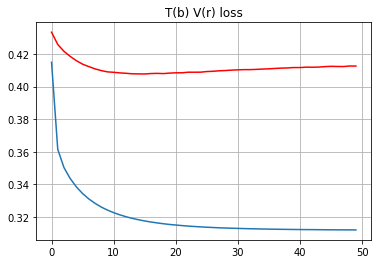

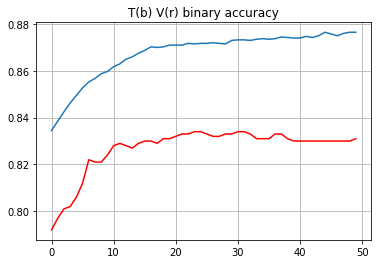

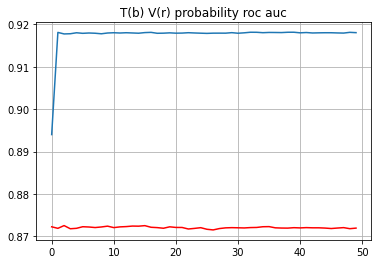



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.8765
out sample binary accuracy: 0.831


 predictions in form : proba
 in sample proba roc_auc: 0.9180951121807155
out sample proba roc_auc: 0.8721509213567677


 ######################################################################    training model U2V  for 150 epochs
training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 4)                 404       
_________________________________________________________________
activation_41 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 5 

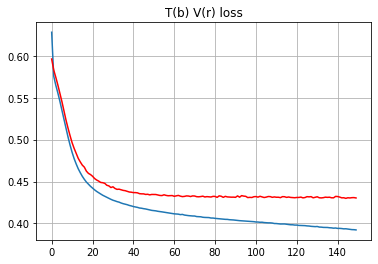

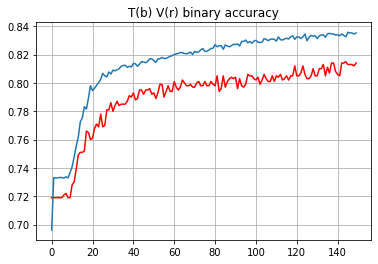

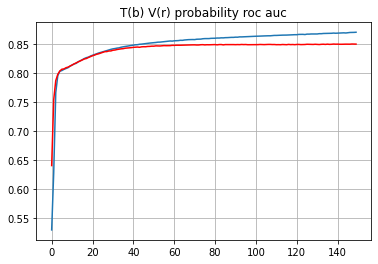



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.83575
out sample binary accuracy: 0.814


 predictions in form : proba
 in sample proba roc_auc: 0.8710391214597033
out sample proba roc_auc: 0.8500537025029821


 ######################################################################    training model ULSA  for 200 epochs
training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 1)                 501       
_________________________________________________________________
activation_43 (Activation)   (None, 1)                 0         
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________

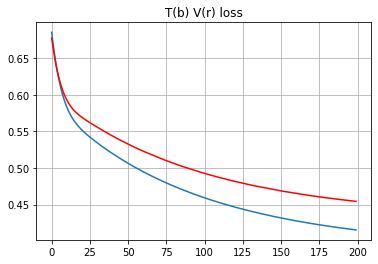

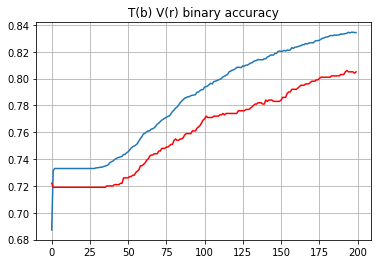

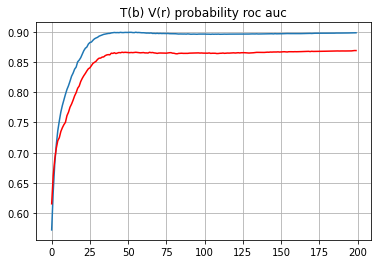



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.8345
out sample binary accuracy: 0.805


 predictions in form : proba
 in sample proba roc_auc: 0.8985446014787111
out sample proba roc_auc: 0.8688471037769936


 ######################################################################    training model AUPCA_TFIDF  for 200 epochs
training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 1)                 1001      
_________________________________________________________________
activation_44 (Activation)   (None, 1)                 0         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_______________________________________________

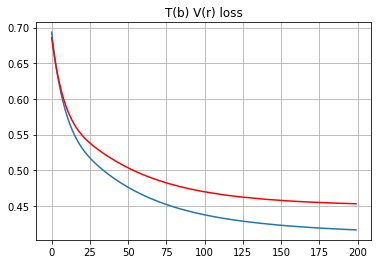

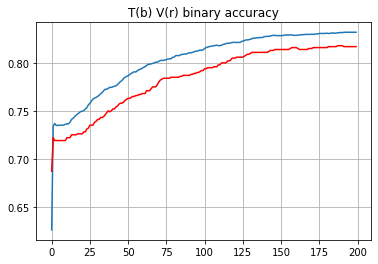

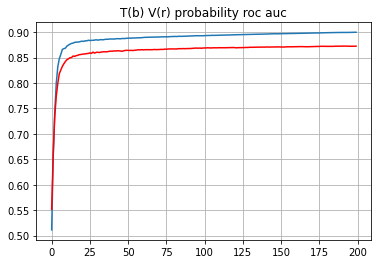



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.83175
out sample binary accuracy: 0.817


 predictions in form : proba
 in sample proba roc_auc: 0.9001427806817196
out sample proba roc_auc: 0.8728017857938319

training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 11        
_________________________________________________________________
activation_45 (Activation)   (None, 1)                 0         
Total params: 71
Trainable params: 71
Non-trainable params: 0
_______________________________________

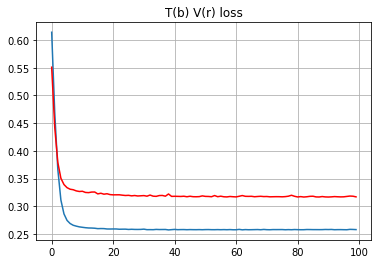

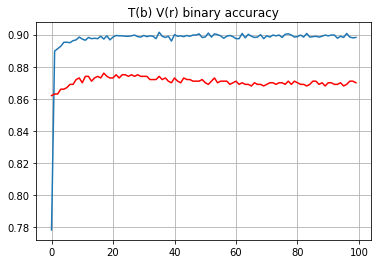

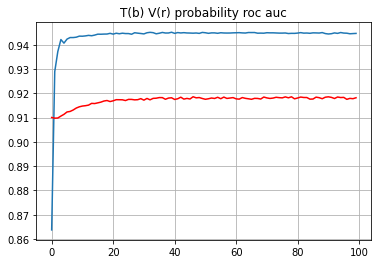



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.9005
out sample binary accuracy: 0.87


 predictions in form : proba
 in sample proba roc_auc: 0.9451201324912755
out sample proba roc_auc: 0.9181841129682884



In [168]:
J_models_dict={
    'UPBS': UPBS_model_init,
    'UNBS': UNBS_model_init,
    'U2V': U2V_model_init,
    'ULSA': ULSA_model_init,
    'AUPCA_TFIDF':AUPCA_TFIDF_model_init
}

J_model=Joint_models(J_models_dict, hl_size=10)

# J_model.train(epochs_dict={'UPBS':50, 'UNBS':20, 'U2V':50, 'AUPCA_TFIDF':50})
J_model.train(epochs_dict={'UPBS':100, 'UNBS':50, 'U2V':150, 'ULSA':200, 'AUPCA_TFIDF':200}, validation=True)



In [169]:
permutation_matrix=[]

for i1 in range(2):
    for i2 in range(2):
        for i3 in range(2):
            for i4 in range(2):
                for i5 in range(2):
                    permutation_matrix.append( np.array( [i1,i1,i3,i4,i5] ))
permutation_matrix=np.array(permutation_matrix).reshape(-1,5)
permutation_matrix.shape


(32, 5)

training on T_set of size 4000
validation on V_set of size 1000


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_46 (Activation)   (None, 1)                 0         
Total params: 193
Trainable params: 33
Non-trainable params: 160
_________________________________________________________________




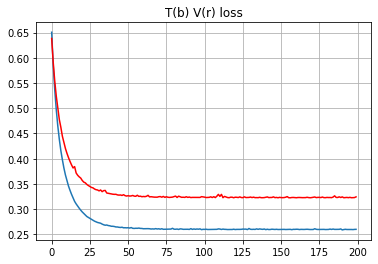

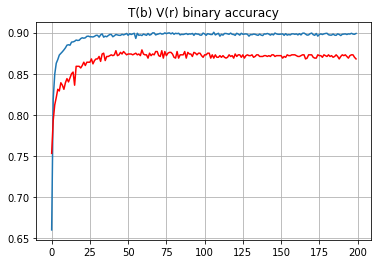

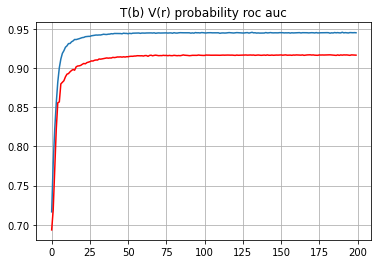



 evaluating probability results of the model ##########################################################
 train set of size 4000
 valid set of size 1000


 in sample binary accuracy: 0.89625
out sample binary accuracy: 0.868


 predictions in form : proba
 in sample proba roc_auc: 0.9454704577157134
out sample proba roc_auc: 0.9166497557402283


 ######################################################################## layer 0 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Dense'>


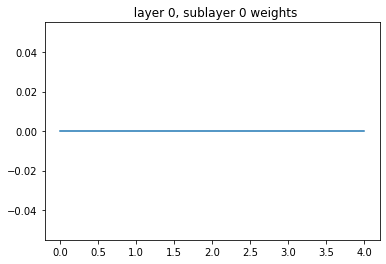

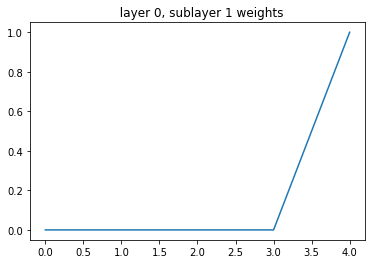

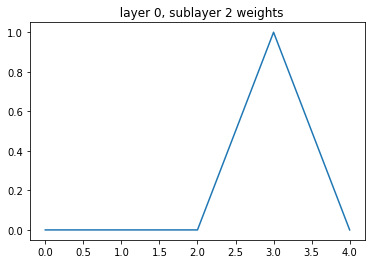

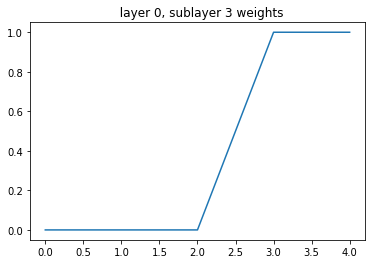

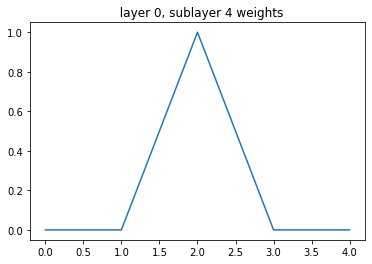

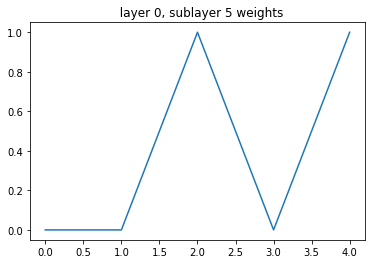

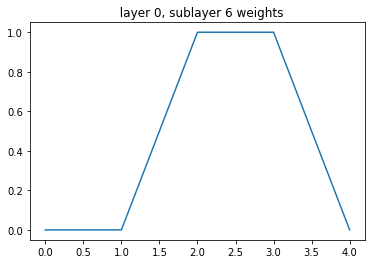

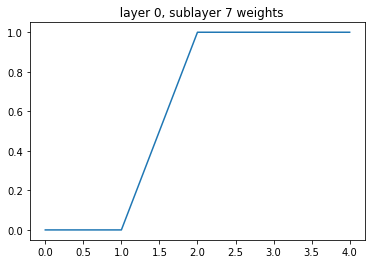

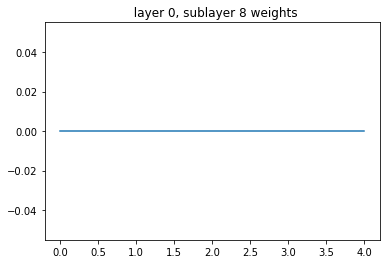

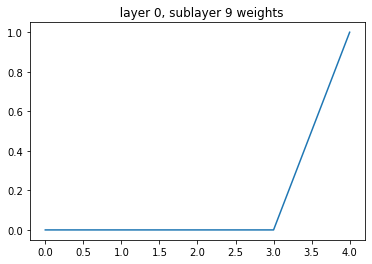

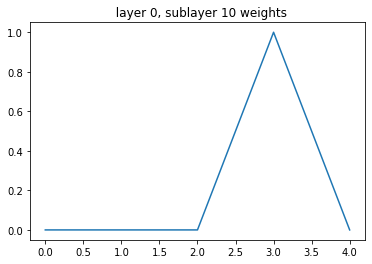

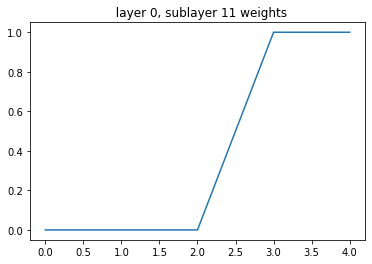

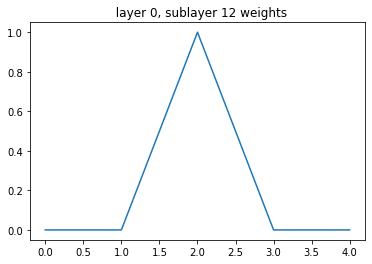

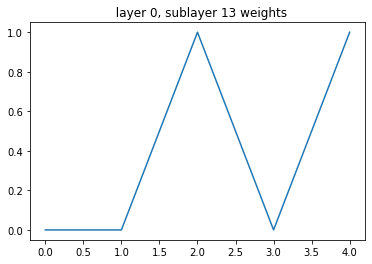

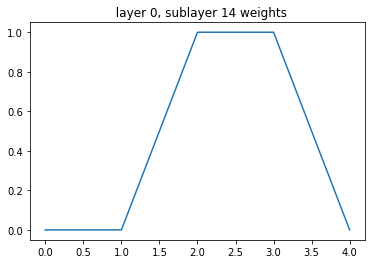

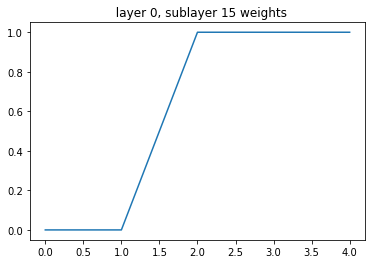

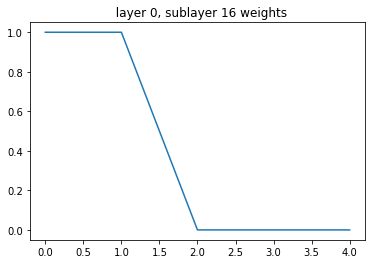

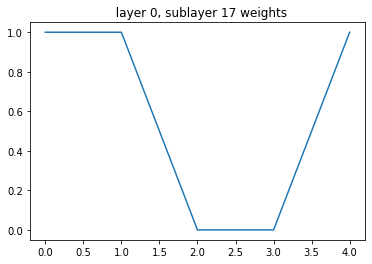

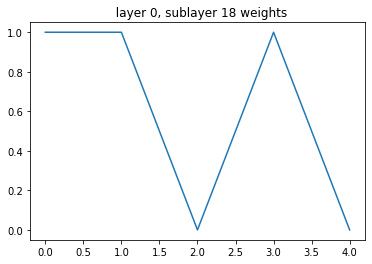

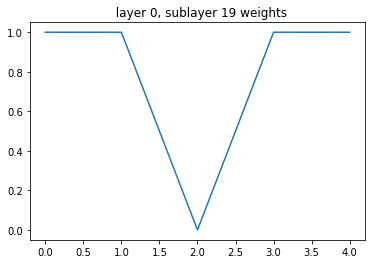

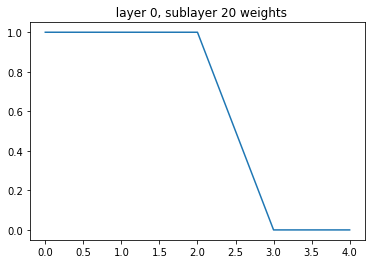

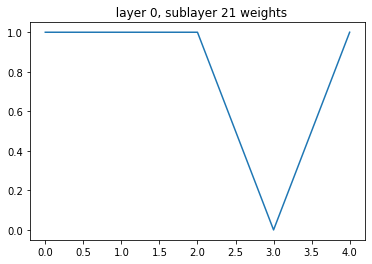

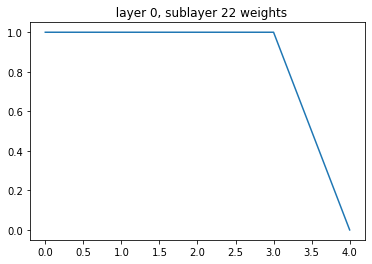

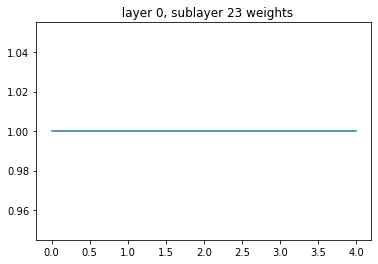

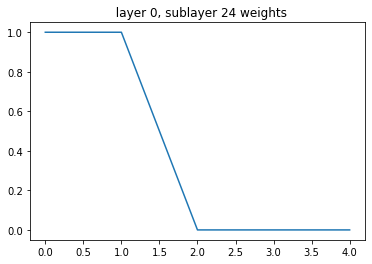

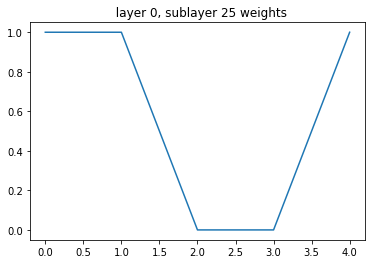

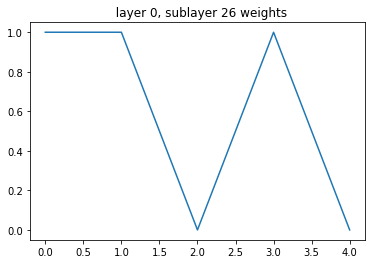

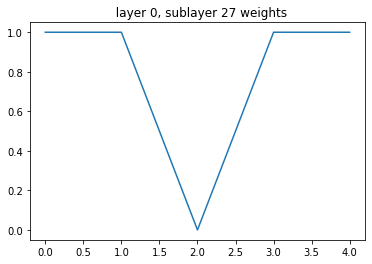

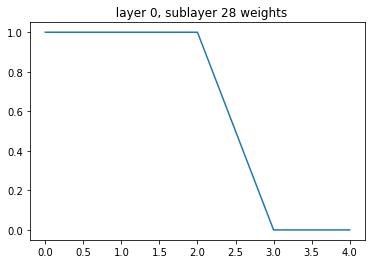

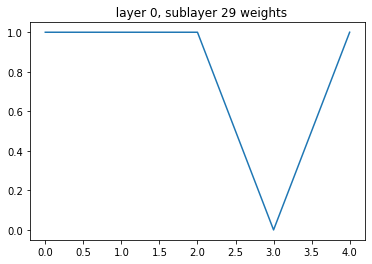

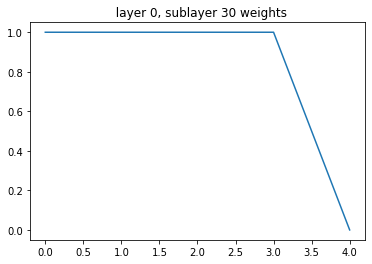

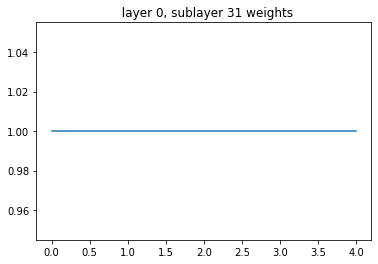

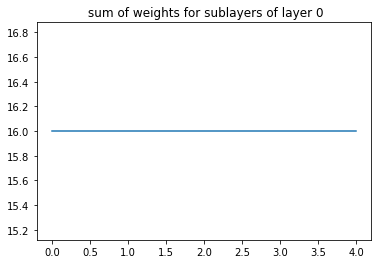





 ######################################################################## layer 1 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Dense'>


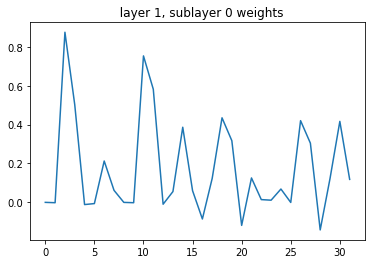





 ######################################################################## layer 2 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Activation'>





In [170]:
def new_joiner_init():

    # K_REG1=tf.keras.regularizers.L1L2(l1=0.01, l2=0.000)
    K_REG2=tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001)
    IN_size=5
    # HL_size=IN_size
    HL_size=32

    # INIT=tf.constant_initializer([np.identity(HL_size)])  #se HL=IN=5
    INIT=tf.constant_initializer([permutation_matrix.T])    #se HL=32

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IN_size)),
        # tf.keras.layers.Activation('sigmoid'),
        tf.keras.layers.Dense(HL_size,
        # kernel_regularizer=K_REG1,
        kernel_initializer=INIT,
        trainable=False,
        use_bias=False
        ),
        # tf.keras.layers.Activation('sigmoid'),
    #     tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,
        kernel_regularizer=K_REG2,
        use_bias=True
        ),
        tf.keras.layers.Activation('sigmoid')
    ])

    OPT=tf.keras.optimizers.Adam(
        learning_rate=0.002,                #<-------- nb default è learning_rate =0.001
        beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    )

    model.compile(
        # loss=tf.keras.losses.MeanSquaredError(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=OPT,
        # loss_weights=dictoarr(loss_weights),
        metrics=[tf.metrics.BinaryAccuracy(threshold=0.5), tf.metrics.AUC(name='roc_auc', curve='roc')])

    return model

J_epochs=200
J_model.retrain_J_layers(new_J_init=new_joiner_init)

In [171]:
FINAL_MODEL_BLIND_TRAIN=True

  J model got UPBS  model initializer
  J model got UNBS  model initializer
  J model got U2V  model initializer
  J model got ULSA  model initializer
  J model got AUPCA_TFIDF  model initializer

   joiner hidden layer of size 10


 ######################################################################    training model UPBS  for 100 epochs


  running blind mode: train and validation sets got joined

training on T_set of size 5000


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 1)                 2         
_________________________________________________________________
activation_47 (Activation)   (None, 1)                 0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________




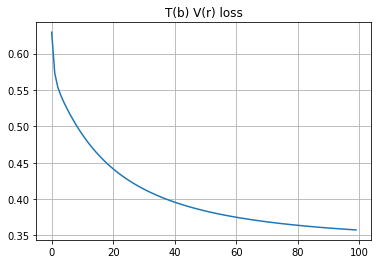

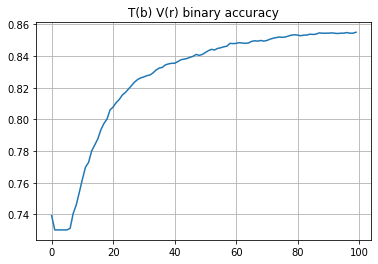

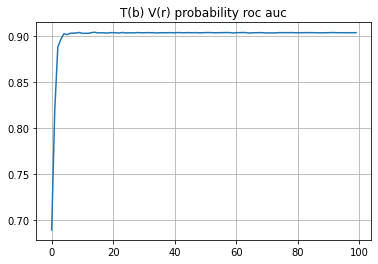


 ######################################################################    training model UNBS  for 50 epochs


  running blind mode: train and validation sets got joined

training on T_set of size 5000


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 1)                 2         
_________________________________________________________________
activation_48 (Activation)   (None, 1)                 0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________




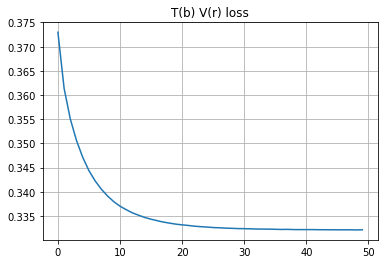

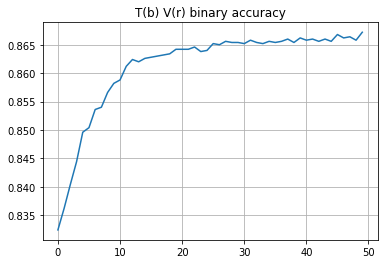

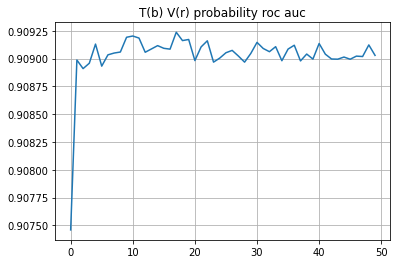


 ######################################################################    training model U2V  for 150 epochs


  running blind mode: train and validation sets got joined

training on T_set of size 5000


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 4)                 404       
_________________________________________________________________
activation_49 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 5         
_________________________________________________________________
activation_50 (Activation)   (None, 1)                 0         
Total params: 409
Trainable params: 409
Non-trainable params: 0
_________________________________________________________________




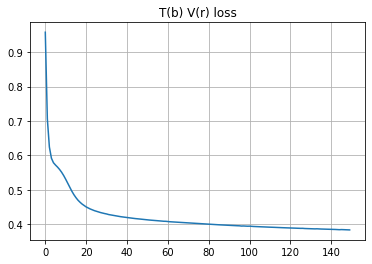

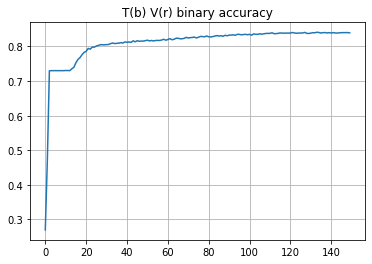

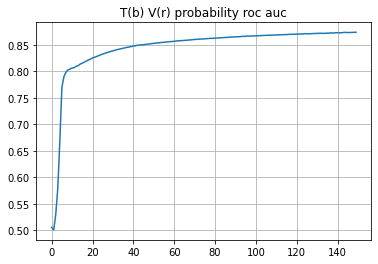


 ######################################################################    training model ULSA  for 200 epochs


  running blind mode: train and validation sets got joined

training on T_set of size 5000


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 1)                 501       
_________________________________________________________________
activation_51 (Activation)   (None, 1)                 0         
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________




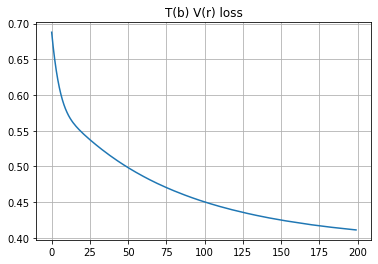

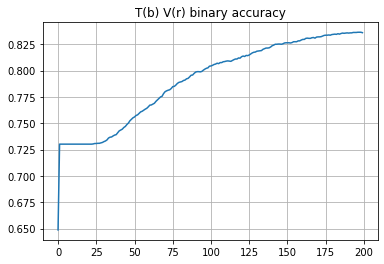

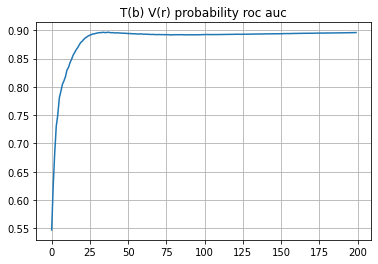


 ######################################################################    training model AUPCA_TFIDF  for 200 epochs


  running blind mode: train and validation sets got joined

training on T_set of size 5000


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 1)                 1001      
_________________________________________________________________
activation_52 (Activation)   (None, 1)                 0         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________




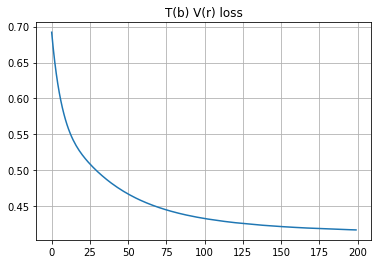

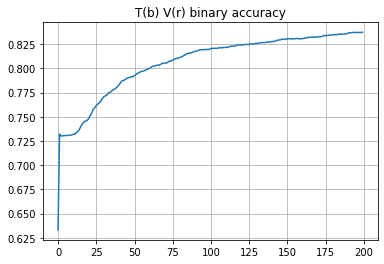

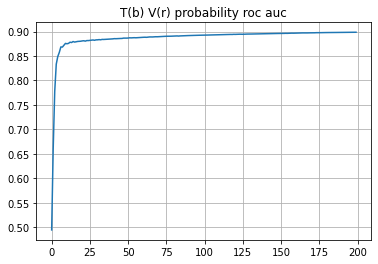



  running blind mode: train and validation sets got joined

training on T_set of size 5000


Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 11        
_________________________________________________________________
activation_53 (Activation)   (None, 1)                 0         
Total params: 71
Trainable params: 71
Non-trainable params: 0
_________________________________________________________________




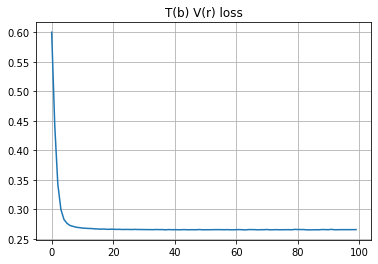

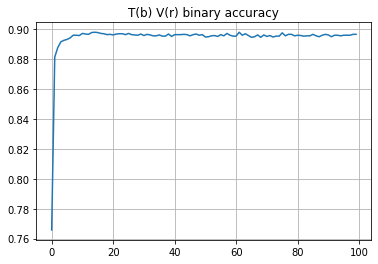

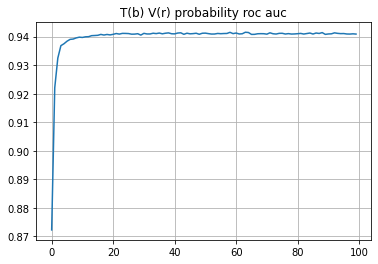



  running blind mode: train and validation sets got joined

training on T_set of size 5000


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_54 (Activation)   (None, 1)                 0         
Total params: 193
Trainable params: 33
Non-trainable params: 160
_________________________________________________________________




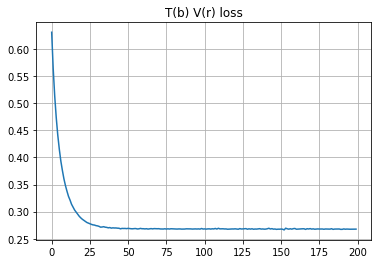

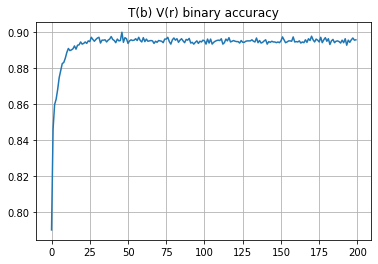

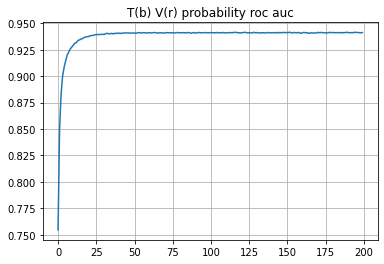


 ######################################################################## layer 0 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Dense'>


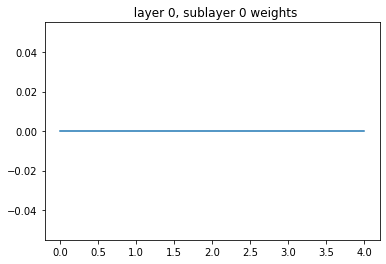

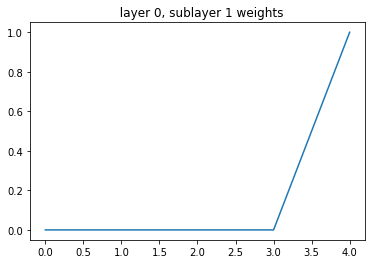

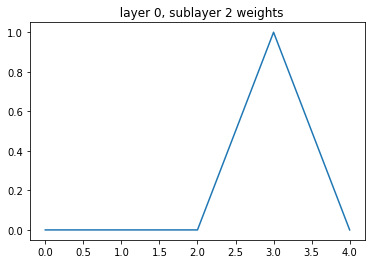

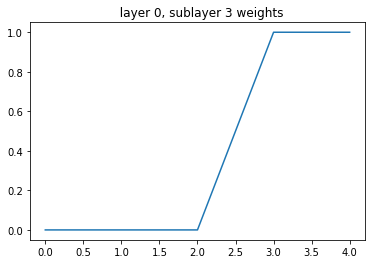

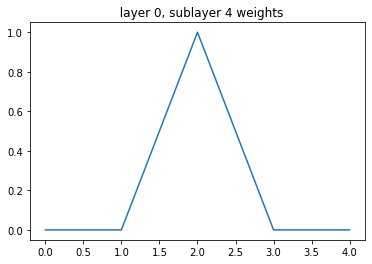

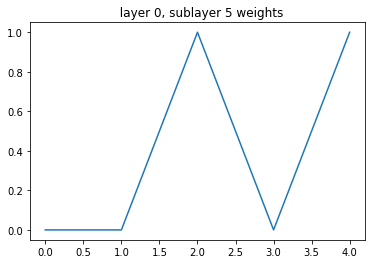

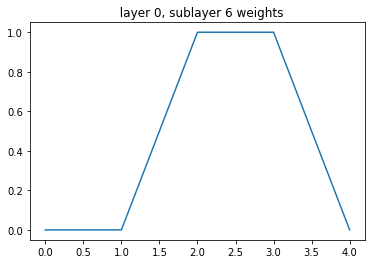

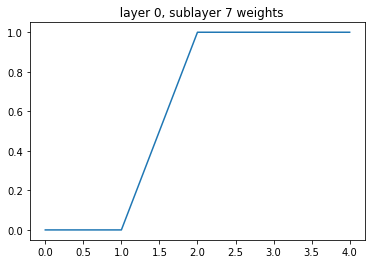

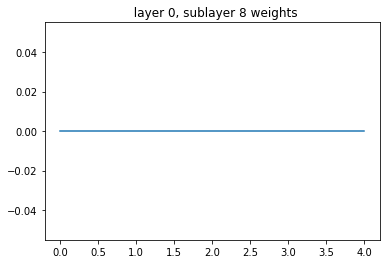

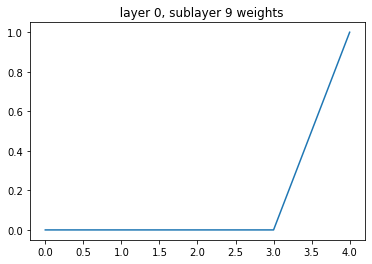

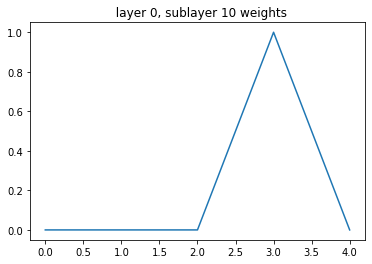

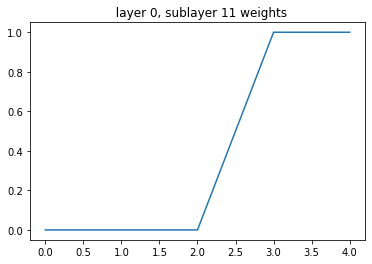

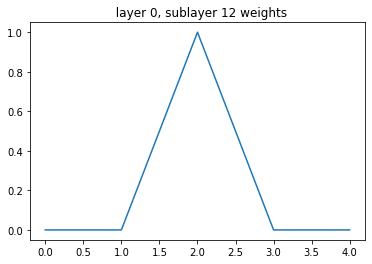

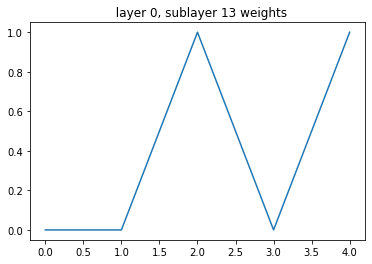

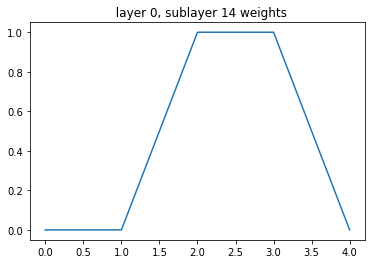

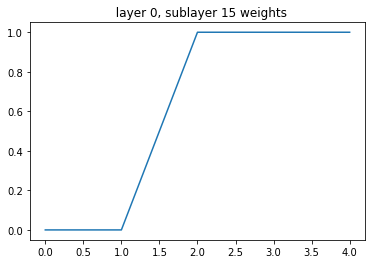

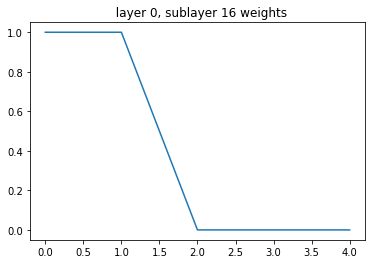

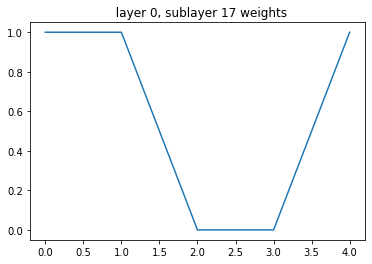

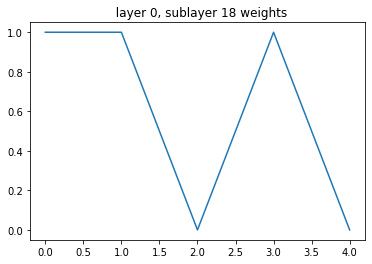

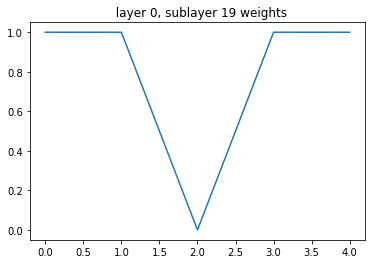

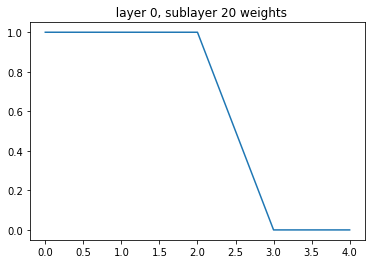

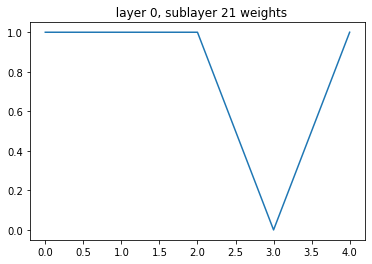

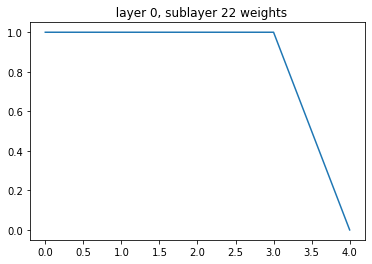

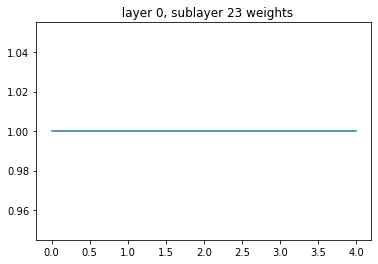

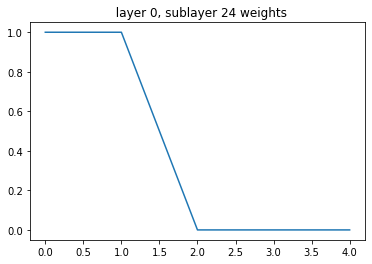

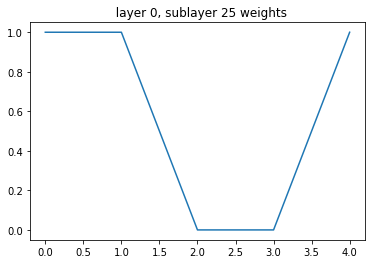

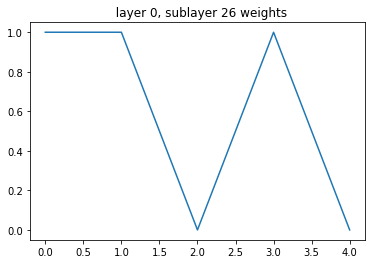

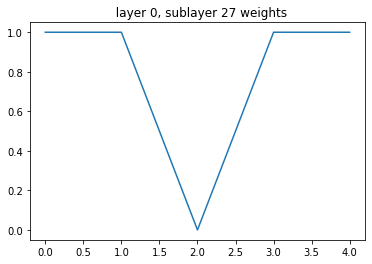

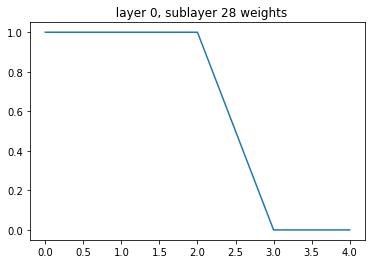

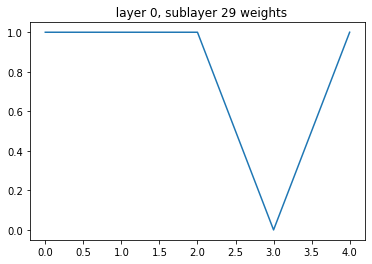

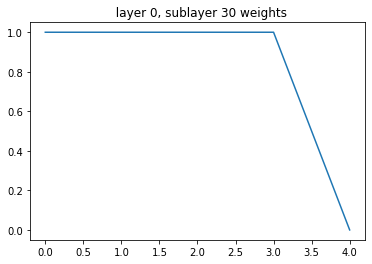

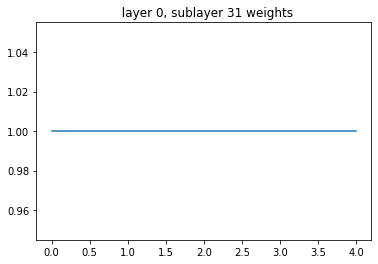

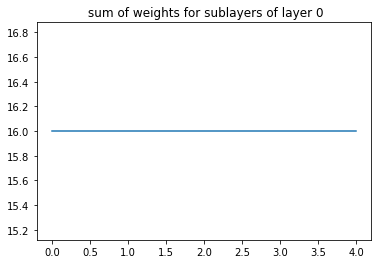





 ######################################################################## layer 1 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Dense'>


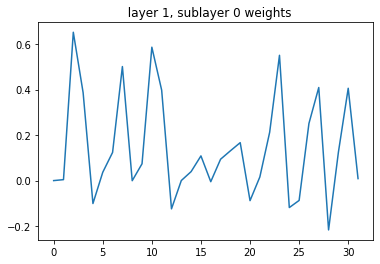





 ######################################################################## layer 2 weights

   layer of type   <class 'tensorflow.python.keras.layers.core.Activation'>





In [172]:
if FINAL_MODEL_BLIND_TRAIN:
    final_model=Joint_models(J_models_dict, hl_size=10)
    final_model.train(epochs_dict={'UPBS':100, 'UNBS':50, 'U2V':150, 'ULSA':200, 'AUPCA_TFIDF':200}, validation=False)
    final_model.retrain_J_layers(new_J_init=new_joiner_init, validation=False)
else:
    final_model=J_model

In [173]:
prediction_type='proba'
predictions={}


# tot_test_users=len(TEST_USERS)
# stepping=-1
# for n, user in enumerate(TEST_USERS):
#     if type(final_model) is not Joint_models:
#         pred=final_model.predict( T_GUF(['UNBS','UPBS','U2V', 'UPCA_TFIDF'], t_users=user) )
#     else:
#         pred=final_model.predict({
#             'UPBS':T_GUF('UPBS', t_users=user),
#             'UNBS':T_GUF('UNBS', t_users=user),
#             'U2V': T_GUF('U2V', t_users=user),
#             'ULSA': T_GUF('ULSA', t_users=user),
#             'AUPCA_TFIDF': T_GUF('AUPCA_TFIDF', t_users=user)
#         })
#     # print(pred)
#     if prediction_type is 'class':
#         pred= (pred > 0.5).astype("int32")[0][0]
#     elif prediction_type is 'proba':
#         pred=pred[0][0]
#     # print(user, pred)
#     # break
#     predictions[user]=pred
#     stepping=perc_compl(n, tot_test_users, last_step=stepping, step=0.001, text="     {:>6d}".format(n+1)+" test users gender elaborated  ")
     
prediction_values=final_model.predict({
            'UPBS':T_GUF('UPBS'),
            'UNBS':T_GUF('UNBS'),
            'U2V': T_GUF('U2V'),
            'ULSA': T_GUF('ULSA'),
            'AUPCA_TFIDF': T_GUF('AUPCA_TFIDF')
        })
for user_name, predicted_value in zip(TEST_USERS, prediction_values):
    predictions[user_name]=predicted_value[0]  

In [174]:
for user in predictions:
    print(user, predictions[user])
    break

dragontail 0.109681904


In [175]:
if prediction_type is 'class':
    score_visualization(TEST_UPBS,'PB', UG=predictions, graph_prefix="test ")

In [176]:
if prediction_type is 'class':
    score_visualization(TEST_UNBS,'NB', UG=predictions, graph_prefix="test ")

In [177]:
if prediction_type is 'class':
    visualize_u2v_similarity(TEST_U2V, UG=predictions)

In [178]:
if prediction_type is 'class':
    visualize_u2v_norms(TEST_U2V, UG=predictions, hist_steps=20)

In [179]:
if prediction_type is 'class':
    print(dictoarr(predictions).sum()/len(predictions),end=" proportion of female")


In [180]:
# submission={str(i): {'author': user, 'gender':predictions[user]} for i, user in enumerate(predictions)}

In [181]:
# submission_run_count=12

In [182]:
submission=pd.DataFrame.from_dict(predictions, orient='index', columns=['gender'])
submission.to_csv("submission_"+str(submission_run_count),index_label='author')
submission_run_count+=1
submission.head()

gender
dragontail       0.109682
carrissapaigeee  0.615184
thabigmilla      0.272025
mangleopolis     0.056080
asieting         0.050426

# Fine

Per concludere, sebbene confrontandomi con i colleghi ho visto come il mio programma avesse un certo margine di miglioramento, sono stato soddisfatto di aver testato molte varie possibilità ed aver potuto osservare come ognuna di queste influisse nello sviluppo